# Computer Graphics (0368-3236) Fall 2019, Excercise I

In this excercise you will implement basic image processing operations, such as scaling and rotation.
<br />
You will implement several sampling methods, such as Nearest Neighbour, Bilinear, and Parametric Gaussian.
<br />
As you've seen in class, it is preferred to use backward mapping instead of forward mapping, which will gurentee that the target image will be complete. You will display your results, to verify your code.
<br />

You will use Python 3 on a Jupyter Notebook environment with scientific packages. There are two ways to get started:
<ol>
    <li>Get the <b>conda</b> package management and environment system conda from <a href='https://docs.conda.io/projects/conda/en/latest/user-guide/install/#regular-installation' target='_blank'>here</a>. Conda is the preferred tool for data and algorithms development in the academia and the industry, but we can not provide support for students who have difficulities with it.</li>
    <li>Alternatively, you can manually install the needed packages. We will use <b>Python 3.7</b> or above, and some very useful packages such as <b>OpenCV</b> or <b>Pillow</b> for image deserialization, <b>Imageio</b> for animation image serialization, <b>IPython</b> for notebook support, <b>Matplotlib</b> for plotting, <b>NumPy</b> for tensor data structures, <b>SciPy</b> for statistics functions, and <b>scikit-image</b> for image comparison metrics.
        <br/>
        After installing python, run these commands:
        <ul>
            <li>pip install pip --upgrade</li>
            <ul>
                <li>or: python -m pip install pip --upgrade</li>
                <li>or: python3 -m pip install pip --upgrade</li>
                <li>or: pip3 install pip --upgrade</li>
            </ul>        
            <li>pip install jupyter numpy scipy matplotlib opencv-python pillow scikit-image imageio --upgrade</li>
            <ul>
                <li>or: python -m pip install jupyter numpy scipy matplotlib opencv-python pillow scikit-image imageio --upgrade</li>
                <li>or: python3 -m pip install jupyter numpy scipy matplotlib opencv-python pillow scikit-image imageio --upgrade</li>
                <li>or: pip3 install jupyter numpy scipy matplotlib opencv-python pillow scikit-image imageio --upgrade</li>
            </ul>                    
        </ul>
</ol>

Please post your questions on Moodle.

These are some imports, classes and functions implemented for you. You do not need to edit this section. Specifically, <b>you may not add imports anywhere else in the notebook</b>.

In [165]:
# Copyright (c) 2019 Mattan Serry,
# Computer Graphics and Vision Lab, School of Computer Science, Tel Aviv University
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

from collections import Counter
from math import sqrt, ceil, floor, radians, cos, sin
from os import remove
from sys import float_info, version_info
from random import randint, uniform
from time import process_time, sleep
from unittest import TestCase
assert version_info >= (3, 7)

# from cv2 import imread, cvtColor, COLOR_BGR2RGB
from IPython.display import HTML, display, Image
from matplotlib import rcParams
from matplotlib.pyplot import show, figure
from numpy import ndarray, iinfo, full, clip, average, array, empty, errstate, uint8
from PIL import Image as PILImage
from scipy.stats import norm as normal_dist
from skimage import __version__ as skimage_version
assert skimage_version >= '0.16.2'


display(HTML("<style>.container { width:100% !important; }</style>"))


class Timer:    
    def __enter__(self):
        self.start = process_time()
        print('*'*16)
        return self

    def __exit__(self, *args):
        self.end = process_time()
        self.interval = self.end - self.start
        print(f'Elapsed: {self.interval:.2f} seconds')
        print('*'*16)


class MyImage:

    def __init__(self, tensor: ndarray):
        self._tensor = tensor
        self._height, self._width, self._channels = tensor.shape
        self._time = None

    @property
    def tensor(self):
        return self._tensor

    @property
    def height(self):
        return self._height

    @property
    def width(self):
        return self._width

    @property
    def channels(self):
        return self._channels

    @classmethod
    def load(cls, path: str):
        tensor = array(PILImage.open(path).convert("RGB"))
        image = cls(tensor)
        return image

    def show(self) -> None:
        dpi = rcParams['figure.dpi']
        im_data = self.tensor
        height, width, depth = im_data.shape

        # What size does the figure need to be in inches to fit the image?
        figsize = width / float(dpi), height / float(dpi)

        # Create a figure of the right size with one axes that takes up the full figure
        fig = figure(figsize=figsize)
        ax = fig.add_axes([0, 0, 1, 1])

        # Hide spines, ticks, etc.
        ax.axis('off')

        # Display the image.
        ax.imshow(im_data, cmap='gray')

        show()

    def copy(self):
        return MyImage(self.tensor.copy())
    
    def print_diff(self, test_img):
        from skimage.metrics import peak_signal_noise_ratio, mean_squared_error
        
        this = self.tensor
        other = test_img.tensor
        with errstate(divide='ignore', invalid='ignore'):
            print(f'PSNR = {peak_signal_noise_ratio(this, other):.2f} dB')
        print(f'MSE = {mean_squared_error(this, other):.2f}')
    


class PartialPixels(dict):
    def get_average_color(self, ref_image: MyImage):
        # print(self.keys())
        ordered_colors = [ref_image.tensor[y, x, :] for (y, x) in self.pixels]
        ordered_weights = array(list(self.weights))
        try:
            average_color = average(ordered_colors, axis=0, weights=ordered_weights)
        except:
            print(ordered_colors)
            raise

        return average_color

    @property
    def pixels(self):
        return self.keys()

    @property
    def weights(self):
        return self.values()

    def __imul__(self, scaler):
        for k in self:
            self[k] *= scaler

    def __mul__(self, scaler):
        return PartialPixels({k: v * scaler for k, v in self.items()})

    def __rmu1__(self, other):
        return self * other
    
    def normalize(self):
        current_sum = sum(self.weights)
        for pxl in self.pixels:
            self[pxl] /= current_sum
            
    @classmethod
    def from_dict(cls, dic):
        return cls(dic)
    

def normalnd(mean: tuple, point: tuple, std: float):    
    result = 1.0
    for dim_mean, dim_point in zip(mean, point):
        result *= normal_dist.pdf(dim_point, loc=dim_mean, scale=std)
    return result

def run(source_image, method=None, backward_map=None, num_iters=1, gif=False):
    target_image = source_image.copy()
    
    targets = [source_image.tensor.astype(uint8)]
    
    with Timer():
    
        if method is not None and backward_map is not None:

            all_colors = calculate_all_partial_pixels_by_method(source_image.height, source_image.width, method, backward_map)

            for _ in range(num_iters):
                target_image = transform(target_image, all_colors)
                targets.append(target_image.tensor.astype(uint8))

            print(method.__name__)

        if not gif:
            target_image.show()
        else:
            from tempfile import mkstemp
            from imageio import mimsave
            _, fname = mkstemp(suffix='.gif')
            mimsave(fname, targets, 'GIF', duration=0.5)
            display(Image(fname))
            # sleep(1)
            # remove(fname)
            
        if source_image.tensor.shape == target_image.tensor.shape:
            source_image.print_diff(target_image)

Start by implementing a forward mapping operator. If you scale an image by **sy** and **sy**, where will each pixel translate to?

In [166]:
def bilinear(height: int, width: int, y: float, x: float) -> PartialPixels:
    x = clip_to_range(x, max_dim=width)
    y = clip_to_range(y, max_dim=height)
    
    x1, x2 = floor(x), ceil(x)
    y1, y2 = floor(y), ceil(y)
    
    q11 = y1, x1
    q21 = y2, x1
    q12 = y1, x2
    q22 = y2, x2
    
    if q11 == q12 == q21 == q22:
        return PartialPixels.from_dict({q11: 1.0})
    
    if x1 == x2:
        return PartialPixels.from_dict({q11: 1 - (y - y1), q21: 1 - (y2 - y)})
    
    if y1 == y2:
        return PartialPixels.from_dict({q11: 1 - (x - x1), q12: 1 - (x2 - x)})
    
    w1 = ((x2 - x)*(y2 - y))/((x2 - x1)*(y2 - y1))
    w2 = ((x - x1)*(y2 - y))/((x2 - x1)*(y2 - y1))
    w3 = ((x2 - x)*(y - y1))/((x2 - x1)*(y2 - y1))
    w4 = ((x - x1)*(y - y1))/((x2 - x1)*(y2 - y1))
    
    
    counter = Counter({q11:w1, q12: w2, q21: w3, q22: w4})
    return PartialPixels.from_dict(counter)

class BLTest(TestCase):
    def test(self):
        height, width = 768, 1024
        y1, x1 = 50.0, 60.0
        y2, x2 = 50.25, 60.0
        y3, x3 = 50.25, 60.50
        
        bl1 = bilinear(height=height, width=width, y=y1, x=x1)
        bl2 = bilinear(height=height, width=width, y=y2, x=x2)
        bl3 = bilinear(height=height, width=width, y=y3, x=x3)
        
        print(bl1)
        print(bl2)
        print(bl3)
        
        bl1.normalize()
        bl2.normalize()
        bl3.normalize()

        print(bl1)
        print(bl2)
        print(bl3)

        
        # assert return type is class PartialPixels
        self.assertTrue(isinstance(bl1, PartialPixels) and isinstance(bl2, PartialPixels) and isinstance(bl2, PartialPixels))
        
        # assert that NN maps to exactly one pixel (the rounded), and the weight is as expected
        self.assertTrue(
            {
                (50, 60): 1.0,
            } == bl1
        )
        
        self.assertTrue(
            {
                (50, 60): 0.75,
                (51, 60): 0.25,
            } == bl2
        )
        
                
        self.assertTrue(
            {
                (50, 60): 0.375,
                (51, 60): 0.125,
                (50, 61): 0.375,
                (51, 61): 0.125,
            } == bl3
        )
        

BLTest().test()

{(50, 60): 1.0}
{(50, 60): 0.75, (51, 60): 0.25}
{(50, 60): 0.375, (50, 61): 0.375, (51, 60): 0.125, (51, 61): 0.125}
{(50, 60): 1.0}
{(50, 60): 0.75, (51, 60): 0.25}
{(50, 60): 0.375, (50, 61): 0.375, (51, 60): 0.125, (51, 61): 0.125}


## Part 1: Sampling Methods

You will need to implement the sampling methods *nearest_neighbour*, *bilinear* and *parametric_gaussian*. Make sure the returning value class is *PartialPixels*, which is an extension of *dict*. *PartialPixels* represents the weights of the source pixels per a target pixel, by method.

For example, NN should always return a PartialPixels of size 1, with weight 1.0.

Bilinear should return PartialPixels of size 1, 2 or 4, depends on the value of the source pixel. We relax the demand that the weights are summed to 1.

Parametric Gaussian should return PartialPixels of size up to 9, by calculating over a regular grid of 3x3 with stride **d**. Again we relax the demand that the weights are summed to 1.

We are prociding some clipping and rounding methods for your assistance.

In [167]:
def clip_to_range(z: float, *, max_dim: int):
    return clip(z, 0, max_dim - 1)

def clip_and_round(z: float, *, max_dim: int):
    return clip_to_range(z, max_dim=max_dim).round().astype(int)

Implement *nearest_neighbour* and validate it. We recommend you use *clip_and_round*.

In [168]:
def nearest_neighbour(height: int, width: int, y: float, x: float) -> PartialPixels:
    
    return PartialPixels.from_dict({(clip_and_round(y, max_dim=height), clip_and_round(x, max_dim=width)): 1.0})

class NNTest(TestCase):
    def test(self):
        height, width = 768, 1024
        y1, x1 = -3.3, 58.12
        y2, x2 = 674.91, 3007.8
        
        nn1 = nearest_neighbour(height=height, width=width, y=y1, x=x1)
        nn2 = nearest_neighbour(height=height, width=width, y=y2, x=x2)
        
        print(nn1)
        print(nn2)

        # assert return type is class PartialPixels
        self.assertTrue(isinstance(nn1, PartialPixels))
        self.assertTrue(isinstance(nn2, PartialPixels))
        
        # assert that NN maps to exactly one pixel (the rounded), and the weight is as expected
        self.assertTrue({(0, 58): 1.0} == nn1)
        self.assertTrue({(675, 1023): 1.0} == nn2)
        

NNTest().test()

{(0, 58): 1.0}
{(675, 1023): 1.0}


Implement *bilinear* and validate it. We recommend you to create a *Counter* instance, populate it, and then cast it to *PartialPixels*. We recommend you use *clip_to_range*.

Implement *parametric_gaussian* and validate it. We recommend you to create a *Counter* instance, populate it, and then cast it to *PartialPixels*. We recommend you use *clip_to_range* for grid values, *normalnd* for the sampling value, and *bilinear* to project from fractional pixels to integer pixels.

Important: When you sample with *normalnd*, add **epsilon** to the result. Small values can cause numerical errors.

In [335]:
def parametric_gaussian(height: int, width: int, y: float, x: float, std: float, d: float, epsilon=float_info.epsilon):

    grid = []
    for i in range(-1, 2):
        for j in range(-1, 2):
            yi = clip_to_range(y + i*d, max_dim=height)
            xj = clip_to_range(x + j*d, max_dim=width)
            grid.append((yi, xj))
    
    result = Counter()
    for point in grid:
        norm = normalnd((y, x), point, std) + epsilon
        result.update(bilinear(height=height, width=width, y=point[0], x=point[1])*norm)
    
    return PartialPixels.from_dict(result)


from functools import partial
gaussian03 = partial(parametric_gaussian, std=0.3, d=0.025)
gaussian03.__name__ = 'gaussian 0.3'


class PGTest(TestCase):
    def test(self):
        gaussian_test = partial(parametric_gaussian, std=0.1, d=1)
        height, width = 768, 1024
        y1, x1 = 0.001, 10.500001
        
        pg = gaussian_test(height=height, width=width, y=y1, x=x1)

        print(pg)
        
        pg.normalize()

        print(pg)
        
        # assert return type is class PartialPixels
        self.assertTrue(isinstance(pg, PartialPixels))
        
        # Verify dominant values of the Gaussian sampling
        self.assertAlmostEqual(pg[(0, 10)], 0.5, places=2)
        self.assertAlmostEqual(pg[(0, 11)], 0.5, places=2)
        
        # verify the other values of the Gaussian sampling
        for i in (0, 1):
            self.assertGreater(pg[(i, 12)], pg[(i, 9)])
            self.assertGreater(pg[(i, 11)], pg[(i, 10)])


PGTest().test()

{(0, 9): 2.2193620683839962e-16, (0, 10): 15.907106870346883, (0, 11): 15.907170498901575, (0, 12): 2.2193709458500187e-16, (1, 9): 1.1102208195275819e-16, (1, 10): 0.007957731239100693, (1, 11): 0.007957763070089286, (1, 12): 1.1102252604197387e-16, (2, 9): 1.1102208041789867e-19, (2, 10): 2.2204613977229864e-19, (2, 11): 2.2204613977843803e-19, (2, 12): 1.1102252450710819e-19}
{(0, 9): 6.972505877980216e-18, (0, 10): 0.49974899425001323, (0, 11): 0.49975099324998673, (0, 12): 6.972533768059489e-18, (1, 9): 3.487948767029534e-18, (1, 10): 0.00025000574998750605, (1, 11): 0.00025000675001250527, (1, 12): 3.487962718852497e-18, (2, 9): 3.487948718809295e-21, (2, 10): 6.975959609296588e-21, (2, 11): 6.975959609489467e-21, (2, 12): 3.487962670632063e-21}


In [286]:
def calculate_all_partial_pixels_by_method(height: int, width: int, method: callable, backward_map: dict) -> ndarray:
    result = {}
    iterations = 0
    for (new_y, new_x), (old_y, old_x) in backward_map.items():
        result[(new_y, new_x)] = method(height, width, old_y, old_x)
        iterations += 1
#         if iterations % 2000 == 0:
#             print(f"backward mapping calc method: {method} iteration: {iterations}")

    return result

## Part 2: Scale Transformation

We will experiment with a photo of a mandrill. Make sure you can load the image and see the monkey.

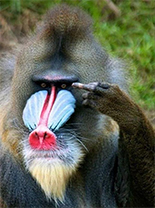

In [287]:
from base64 import b64decode
from io import BytesIO

mandrill = "/9j/4RxRRXhpZgAATU0AKgAAAAgABwESAAMAAAABAAEAAAEaAAUAAAABAAAAYgEbAAUAAAABAAAAagEoAAMAAAABAAIAAAExAAIAAAAiAAAAcgEyAAIAAAAUAAAAlIdpAAQAAAABAAAAqAAAANQACvyAAAAnEAAK/IAAACcQQWRvYmUgUGhvdG9zaG9wIENDIDIwMTUgKFdpbmRvd3MpADIwMTk6MTE6MDggMDA6MjE6MjEAAAOgAQADAAAAAQABAACgAgAEAAAAAQAAAJugAwAEAAAAAQAAANAAAAAAAAAABgEDAAMAAAABAAYAAAEaAAUAAAABAAABIgEbAAUAAAABAAABKgEoAAMAAAABAAIAAAIBAAQAAAABAAABMgICAAQAAAABAAAbFwAAAAAAAABIAAAAAQAAAEgAAAAB/9j/7QAMQWRvYmVfQ00AAf/uAA5BZG9iZQBkgAAAAAH/2wCEAAwICAgJCAwJCQwRCwoLERUPDAwPFRgTExUTExgRDAwMDAwMEQwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwBDQsLDQ4NEA4OEBQODg4UFA4ODg4UEQwMDAwMEREMDAwMDAwRDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDP/AABEIAKAAdwMBIgACEQEDEQH/3QAEAAj/xAE/AAABBQEBAQEBAQAAAAAAAAADAAECBAUGBwgJCgsBAAEFAQEBAQEBAAAAAAAAAAEAAgMEBQYHCAkKCxAAAQQBAwIEAgUHBggFAwwzAQACEQMEIRIxBUFRYRMicYEyBhSRobFCIyQVUsFiMzRygtFDByWSU/Dh8WNzNRaisoMmRJNUZEXCo3Q2F9JV4mXys4TD03Xj80YnlKSFtJXE1OT0pbXF1eX1VmZ2hpamtsbW5vY3R1dnd4eXp7fH1+f3EQACAgECBAQDBAUGBwcGBTUBAAIRAyExEgRBUWFxIhMFMoGRFKGxQiPBUtHwMyRi4XKCkkNTFWNzNPElBhaisoMHJjXC0kSTVKMXZEVVNnRl4vKzhMPTdePzRpSkhbSVxNTk9KW1xdXl9VZmdoaWprbG1ub2JzdHV2d3h5ent8f/2gAMAwEAAhEDEQA/AOS+zlhi15Lgfa0ckj91a9Nm1zWzILCdToqt1Qpt2Ws3Vu1Y/wAf/JKvSG336FzQ3VpGgiOFU4QiWPone91RFllbts/SEka/99QrrrwQK372O1mdY/rK9iuurxTU6H1CA555gmNrv5ShlYVLANs1SQS4Tz3bwgIhecdao8NjrXbXzPGp8FedUxtbmyQO+sQJHt/FRLRQAGuLjETqSf6v8rak2Q4yXAgAbmhs6+Drvbu/ca9OjiiBclDH1Q/Zdd1JLQ36Q8D3UjW5j97vc8CRE6RrMKVYG/adoLYaJkxP5u1v/VfvpzZ+lcSd4AIBmTHGn8n8+t6RxwkdqKpY92u7Ide9oktfzHkD/moxsc0kv1AALSD4f+TT2YvqbXshrtA4jiJ921QyqHPAh20T7h8OyryhKGQR1MZMUQYyru28W7Ez6n42Xy4QxxOoP5rm/wAtrlUf0xuHWWWfpHAwLPEDX/PWf1C19drW1aQ0EmO60fXvy6a6+X6EE/D81TS+Xt/BklVdiidlCj022Uk1uME8/HcrGT9ncxuxpY3byJn8EUmuuposZueNSDqZCpnOt9QmsAtPG7ny/qtUX6O6wfL+1Qe1tZq9R7i72z7pGnKSmLbTMsa1w4Hy3f8ASSRv/GVxeOr/AP/QqCn7ZjMZkBrLGwAfyrOAbVkNDYLD38D3lXmts9Z7ne9pkR2j93RQyMJ8+u2WhzgHaaidGuUAiynytrA+viPFA3DfLB4wfaFodLaHUmyyJeJYTPb2ln735qj0/pjqLJMEkSdvE/ym/nbv8IrxoFLHOAJgaM/8g1IRo+CLPRyur5Yrc8tEO0fEyOQD7fosY/8A6azsfqIs1Al75B7kwfd7Xyx30fof+dqfWG2l8OnseO8Tp9H9LtKxWgstc08STESNPdx8k4DiVIgbOxV1AUWWGY2yGtHtAJb7v3v3WfRT0ZocCSIBO1usiY3fnN+isJrzZL+J1IA/s/8AmK08Wix0QwughoA7uP8AJcgYgIt2KbfUlw0a3x1n+T/UVioUuH6Tnlzo8/8AvqBhs9MNkBxiB2Gvt9hb9H/yC0PRYxu1rWt9Ruh4iFDzMT6ZR6MWSy1rOnV5OTvrEVP7iCf6v8pUcjEyMTN3h2gJA29o7O3fyVbNmU0uaw+m36IESSP3m/yU3qOdXBh1jdPET+65VuKRHj+TGBIdWtTbk2P3kaTABmUfMxQ2sXVtG9w9wnnwRDRa6oWAwyfdGkT+6nqx/Tta660ubOrSQZMTt/8AJpxPT8Uk6NNjLLsV7HuLLq4cxwGpI92z+0ktI47BbLCPSIBd9/0kkaFVet/inijXE//Rz8C/Mra2W7iNYOv9SV0FbBm1huSxhBE7ODP5zXj/AMyQ8HHf7iHetu9opcCC0nlm2PfsRLq20UQBE+2OWx/I3fQ/qqPg0tfxXotVTRUD6HsInaZB0A3+3d/JU3sO4A/RaJaCHDR3Zrf5xu9r/wCXs/wiGLTt1EyQ6TqQXDa72gn6X0FTzOobAYBG3XUcR3bt3N/N/wCDfvS0pBLm9Z9Evdt4iGjQj91vub/0vTXJ5ZAc+By0sA83nstTqWTdc4kDThvz76fyVl24pex2/kGT930QpIRJGyyRCfptTbNu6I/OmDxq0Lrem4FdVQc5sHUn4D6Ubd30foMd/wCCLlOmC2mxu76Mwef4Ls8PLYa2NLZDnAdwSf5G4/u/mf8AnCYd9UshjD2BrZdpE8cT7nfR771HaLAWatc0kT2kawwI9mQxzNrdCQI0kAcggfnV+33qlc8bzs0giJM+befpf+CVv/nHp9RMTE6grNUfUGfoK76/eWuDXR3B0c3s72oTultNe5ziysjcW8QtfpoORS4OJG4y0n9wRLpb9Hcg5nTsiu0OOlYglhGpn+W5UZ8vISJA0RWq2L099GK47i+u3SewlCtwgMiqwuGwscP87/yTvco3WZdNTgxw+ziA5oJIaP3GH85yEy37TW21lhAYIdX2lV8plRrTZRj1BrvbbvvpbdXitbAe0A2E8xodv8lv7ySy8j1mZNOM502OO4Edmn6M/wBZJNo1ayvKn//SvMyW1gB28AeXuA/e/qtRrgMqlsndJOwx3j935+9ZuORZuc33FpkSDJPh6h/6pqu1j08Wtto9wBe9sGJcPo/2GpspekDumI1tGAxjWtMtMmBAJ2kfpNG/Tc57v9fesy+ykvc4tHA0brwNZ2/9+Rep5Wyt8EHaNQRP0Z2/9+ZXW7/hVz1X1owaR+ssc+yfdIJd/a3e121GA8aWybz8azJ3HHqn90mB/V0QndJy2tax1Ra7lxIGnxCu9O+u31b9Mtubdj3QYt0e3tDRG13u/fej5P15+rBYNzr7nbdGVsa0f1f0hU0eEDdbwE62Gng0YtZIt9jmEbXEdvj7lo0U47Xe1s1kkQBJJP8AgzPt/s3f9bWU/wCt31bs1ZRe1xHt9QtiR+c81+76X8pQo6o23KFja341TvolzXsYQT9Cqyxo+immAA0IKLN6indLCXENPuPcagu0dO0h27a3/P8A0jFWur3NhpgGS1w9zRInXX/z3+Yi1u3iBq46Rtnvv0Yzd+fv/wDRPp/QT2NsL9r2PLyNK3sewkSGy2rayzZve/8AqJlaJttdLbbuDahpM6GXl3Ie+PZ7Gu/Rf4FXMmpzZlzS7jgkkzMu0cxu5UMK803FlgIeBOx52d/c38123/v6v3Xh7SZ2zIluoI/s/wDflJVwRernFrTYaLA42uA9oaOCY/N+isa/1KH2VMZNYB08dvf/ADlvOxtobaCZ1AaHTHwfDd2//oLKuxHsZ6wPuJJcP3hPI/te1v76zJw9ZvquABNFz2dQY/G+0tEWt3BxIG46T/1SStHHoaQYDbHAuG4abv5LP6ySjqNdd6pVRt//09WjCLWB1gLQ7T7/AG+0mfTY5v8AbQOoXelLQOOA4SZGu8tn+T6q2RU54ddYPa0e0bvotPw9nuWD1d8F5Y6Hg69/+p/cdsTJdAuGxcPqDiQ4awJiOB+7x/n/APXP+MXP0dCz+tZLmdMxX5Lw4tNjQ1tQcPdsdkWluO3/AIv1Peul6J0Wz6xdUdgGx1OLQ0W5TgTJrmPQp/lX/Q3P/m16NViY1OPj049TKaWF7WVVtDWtj3Mc1g/OZ+99NTYoXqdmGciNt3xbq31b61h5ONZ1KttdmS8VUmpzXzYCP0VkOLmP93/Fo2V9UsvI+teX0jpdQssxXNe4WOHptaA11z8i327Kmuds/wCoXovU6a+qfXvpWBsBq6WHZ2S48CwhtrP7Xto+kjfVjGDmdR61t3WdZy7Lcdp/0FRdXTY/d/L9Sz3ez+bSAiZ0Bo2JQlj5fikQZy4JbfLx8df8x846r9U+udIuHU8jHYKanMcy+gtsqY4OGyzJG1jtm7/gPTWx0762fWSoW1/bBdTc0gnIBtLTqXFr3Ncx/wDVdUu56jZj1VvbfFrLWltpd7g4OEOZDvdZv+ivKMy6vB6lbiYj3WV0vH2ciCZ+lXW5rva59T/ZYpMuERiCOrUxZpGRiasPTY/1qzMINdn9OqNZJf62NAFu1vev9Bd6jP5awrevftW77Vfm3UZwYa2F0vYGA7hT/pmez+c9Kzeq3VH5uRm1Myr6si5lWyRu27iS/wBJtr/c+ze76X7/APNqjXhUmXWAVOaYOyYjSQ5pUBmQGbht6bBz+p07t2Yy1xlzK64cySPe+b/Vs9R7G/mf+fFo9N6q3Nc/GzIrvDg6r91wd9KrSNu13u97FxjnPp9tUWNOmzuB5s9rdqLiZrCA8keozh7ZBjh0N9rtrlEZyuwvERVF7gteS7GBAeNDu8vcGtHt9jvc/wBrlRvzIecawkEEOlsaj6LBWg4PVG5dYZeYuZoTBEg6N92iJmYF9wORU5ocwEOB7cfpP3f6iqZY3PishinEj+xqHHtst+0m0MpYdWEmS781s/vJI5wa/R2+4wJIEhoJ9o/l7dySZxmuHTvf/oSz3NH/1OpyrG1t9Rw9jTuY0zqeztv/AJFc31El9bj+/wA7gDEE9v8Ag1s9Qd6mS6kO2tYATHIH05aP3nrEyn1WtdXVusO4tFhkS5oHt2/m76nKKGotfI1o7f1HwGYHSa8x53XdSu32DX21tLsfGqn+T77v69q6HGa1tbfVdpW55eT4Bvv4/qrG+rV1WT0PEY3T0R9ncBoC+olgcB/wrHVvY9a2Q+n7Hkte6BaPSIBg7rBs2t/lPa/1FcFDGK6hrxHHlEf63C4vTcTJtoz+pj9Hl9ZcasWeWNtPvs/6zjtY7/0HWzZXXSxuJjwxjGNY0dq6awG11/2mt96WI1rMmnFbqMWgluke5xFLP+h6qDmZDWCtlJDrckmxr3at2M2+tl2H82jHY9vt/wAJe+itDGAC2PiObil2juB2h8sP+Yhyn47KLBafRxWgm/IJ2uiNzvd+Ztb/AIJn0P8ADLw/qV/2nquVbS7fW61wZYwbQ9rTsZbt/Nfaz3PXV/X7611dSjo/Ry+3EaYttaD7yHTt3f4X3+6z/hP/AAPmcPEe2qXVuE6Ajn/zFLNO6iOmp82nggRcj12H9VDj1vqeLGWEO0gPG5sawxX3Pt9D1G1y0CLHNhzhMNa57T/g9g27/wDBpmVEGY2zpEf3rpfq6LGsdY7aNsgbGyd37zvzf7Cg4b8GxxU8qK67TubAc7j3akfmuf7H7ePZvU/TtAl7Bu/fHu/L7l1VvSMfq19uM6MXLc11lN7BtadonY/0/c/f/wCq1zd+NlYOXbi5Q23VEbpII1Es9J5+mxzf0jPaoT1HZkGzKlzq3bjtMAy2PzXDa7bu+mz2/pP53+WtXpuW+0HED5s5pdMlzR9EGff7dzmrIFzNsRAcZMFnP+kYwbn/APbaGL213sfW3bYBukTqRq7j6Lv+gmyjar6F630sraccNBIbrZOkz4/yUkBmeLWHIY0uezc1zdRWCP3mfTd/ISTeAVdI9uN1T//V18ttr+ovZXALhtLz2Me5tf8AW9m9Uc7EFctuta4uHvZsgkjUOb6W33Vu+g3b/wBWtK2x7R9oZDnOZAIgmCdzvb/V/MVC7IGTFDbdoPuscdoABjay57/Zv2e973fzH6NVYSMSQe9AM0gCLHa3Lx7MzHzQMP1MvHzi1ltDXfpbg/8ARtdW14pdTdVe31KMyj/Qetk/o6l1XS+vdKrvdVnZdWX1c11m6+msMqf6Zsx/tFb/APCXM3OrtsbsZ/3Hr9FUL8RuJgOurPqPc17mW6sa4x6Tba6y59j7fT+n/N+//Arnen4eI7PxjcS7GdbNtcfmua6t5/k7dysynKPDEddWzyHIQzwnmJJMDw8Mfm4dzL+89lm9c6H1l+X03CzfseexjGWPsGxjmu/TfZ32/msdt9K239y5/prjet9Y61dZldNyqbKc29zG51tJ9Nhra13o4GExxd6XTff6nrMc/wC22erb6npqLMFjLLXAuFb8g3srYfaHO9mM33f8G1ja/Us/nP0auXW5Fn2bKa7bbjsbUbHNY20V+pv/AE32iuxztjv8Hb+h9P1P0tSfhyEyMZD6o+I/DhixDMJeri4eCR4vT+hL/vnkXdDaN7bKr6mNPuP6NzRp+ds9W5v/AIIkzHbjv2iHMgFr3Pa7cDxZS0Nre5n/AJ7XZ43SBkUue2hm+kwxxrFknlttFdXpVWbtvs/wSy+p9KvbkfpGmy5zp3XOY5tjv9Da3Zvw8uz6Nd1T/Stf+iytn8+n5I0HLjIk0XJrY1zw0QJ/NBmfyLawMlmPX6cCOHMdqY/klp2bf+msMuxiSW1Fv7zTII/ebsf/ANTuU/tm0xUYY0GGEaS0epun6OxVzJlp6bHosoyQWkGl7m6TBEndtbv9jf8AWtY/1/8Ad1LCFZ/SGh4rjQw17nMrd/Vl+zd/g02PnwWNfEby0g8RY3dtaN3v3furK+sWU67qVDzsihjYcdXST+efzmt2/omIDGAOLqnjN10c2m8lwa9s7ohvG4niCPd/mKFls2Eklwb7d48f3PcimyXPIc8AgAF3gfp/1eG/o2oMGAHMIdP0gOXfAJAJt18HqFldV43SbaH0PJnsz9G//wAiksupxFZbOha7XWJEt/6lJR8HqXcWj//Wu29Q27Kh9PQun6Xpz9Fjf5bW/mKhaNgfdQWireA+x8BrGkhujWb9znO9n82//rf87Xl42VZZdZuM2uEDmImNzvafp7//AANSflA0sM8jY4nWWjRryzd/n/8ABKPJiupDcFdHJVjoX0TpGJi3dMYd43EbrHSCZfq5paC923T9HX6tnqf8WsfI6TVQ55x7Wt3tMPJLi1k7CWxta52u2y3/ALaVf6uZ/wBp6M+ncZrBdZWwj3C0+k4B0epsbt/SZPp/91sZdJidNxG0RbSHvB3vLpgF30fa4u9v57alLYoX2XYs08d8EjG96eeGAW2Mofk1/o2TY0jUVklrG2a+Tfo/+Zo1WHRa17ci5vt99lbWtO8F2yu5vqBv6xTb799H8/TZ/N+qtx3TOltsbacZoe53tMbnOIEVucT9D+X++gZnSen24jWtpNbanB1bmHVsDZ9Fw2vr2/q9tD06MojsnLnyzFSmZebSqxen4h/Vw0vyGhzLSZaW/SZs/wBLRu9TfXX+l/rql1/pdOVhP9OprrIMQA+D3axlr2f9ufmfuKP2LMbaGPDXaOY6t7Rtc0HXTc37N6m/fZbRb7L/ANKs765dapw8VtA9Z7XAt3EkCW+3ZktDHP3Vu/ls/wBInZcg4e9tWMTxX2eG6hmOfc5rv6UJbc+QdxH0LLHML2Pt2+y2zd+k/nf531FCmxxcxzT9HVsHXT6YbKo1De8vOu5w51J8ldqnTaYPv8T/ACf+qUAjqyEtkPgHX2jXxEfm6rPzrxc71Y3OMN1M6Cfai32jc2lvAJL/ADjVU6yHY8nWXyR8xynnakDuy3na0ESAdsngR2Kd43jUlwn3Ro3+H0v30J2m4O4Dpjn6X/UqbHMBDnVucG67QZGp9qjpeGYrcbNoMvGu6IHBnT6W73JKZZT6jQ0ERO5h0dqD+d8/p/6RJK1P/9fAre0XZFzmlrA6HQCdSPo1t+n+ir9/+k3oNdm0tYY3NAJZB2gN2t+h9LbubtQ7bI3VNBPvNjgWiS795pH0/dtY5lijvItc6eCAADMSY9Rn0msUsaIY5aOp0jr37GyN0b6G2h9jGidwaNrQ93/Ab/U2/wClXqVOZVdhNsrdva+tthcNdbPorxiwzBIAcNCTO0lh2hrZ/wBf+3F0P1L+sbem3P6dlud9lvNYr3alhlwO7+Sz1K/+sKDPjJFxO3RfjkAaPV9Lucx0bYkvgeUOZP8AmtaoPuHrOrdoLCSB8W6/9+VfIc6usMMbmXAPPxduef8AN3KjflEuFhghjncclum38r1UlKXdn4Q5XUus1Y9W5zoc1r9p7FzWljWf1bPoOXm/1hzrOo5jsoEsBA3NaTG6AHbh9H6S1PrRkuOa6lpkOLntHhLN/wDFYTWOhxdMj5SI/lD81S4waBKyRFmkGO2B+BmI0VphAB4hg5OsSfa1vH0v5CCxhFYAMmYB7eCI1wFT3Ae5smDM6+wf+cqzFhLXytzK4/PdLSSDIA1cR+b7voqFIiph0Oh08yZap5TYYSRq32R4E/6uTMb79riS5pk7e5H6NjWtSKRsithtjhM6QeRP3fFOz1GvBH0xqXcBv9r8xya5m23a4wSTPgCR/wBSk1wAG4QGfP8AqtTCuDdY4tqduHvImdZ3Gdn0fd/1z6aSFW/a0hh26GQ4cyDus43bnN/RVpJtLrf/0ONa3bnPrd++5rgBBAne7Y36Lk9VpI9RxMl0gxBkl5fG383RjN6nmAO9azh29xOhja2GkuZ+9vWfU55sYQC1oDW8EQCS5zdzUYS0Wyjq3JaLSAQQWNM6uBbyC552ud7PY/2/pEJ7ntcR2Eubunv+a797amNh3tLt0VgTyfI7dG/mtZ/ITFtgbtiHcsO2Po/S/se1SbhY+h9D+srs3ob35Lt+XjghxPLtv81ZuI/0duxzv32KwzNY9rC+Q1tbN+skB/03af6N/wBNea052VjBwaA5rnCWn6J9rqra7I9rqrarPorcw+sW14mDbJstxxbj2VvJ/S45c39DZH/ain1NnqN/M+z2/wCnVeWAS20ZBkIaXX2u/aNrbWyRtrPkWSw/2/3lUrr2AE6tdoSOZP8Ar9JX88/aX3mC71PeHkfnQ1u5zJd+kf8Azd9bf0e/+a/RqODR6rDTt+mAIJ1M6e/+01SygANOgWCRJcu6o1tLY3bXfl02/uqGM3dfsnQRqPI7ifb/AKsWpkYbvs2/aS4aO01Ozh23+Us2hvp5JDgWtIdJ8OP3dv5v7qV7J7oMqomszqXPBkRwJ4hQDnWvdcXtbuAaXHSP5Tv/ACa0rsdzrHO26kkAgydDubH8nas1gfTlGuNoLz7nCQGzM6/9WlLRUSwyWgWQ2faAW6yYP/fkBry0y0wTpMIzyX7yGlrS4ua3XQEoLmO8D56HVMXhPVZs3ES3c1wkau1G1w3bfzkkOv1PBwIDtYPcFJCtVP8A/9n/7SRQUGhvdG9zaG9wIDMuMAA4QklNBCUAAAAAABAAAAAAAAAAAAAAAAAAAAAAOEJJTQQ6AAAAAADlAAAAEAAAAAEAAAAAAAtwcmludE91dHB1dAAAAAUAAAAAUHN0U2Jvb2wBAAAAAEludGVlbnVtAAAAAEludGUAAAAAQ2xybQAAAA9wcmludFNpeHRlZW5CaXRib29sAAAAAAtwcmludGVyTmFtZVRFWFQAAAABAAAAAAAPcHJpbnRQcm9vZlNldHVwT2JqYwAAAAwAUAByAG8AbwBmACAAUwBlAHQAdQBwAAAAAAAKcHJvb2ZTZXR1cAAAAAEAAAAAQmx0bmVudW0AAAAMYnVpbHRpblByb29mAAAACXByb29mQ01ZSwA4QklNBDsAAAAAAi0AAAAQAAAAAQAAAAAAEnByaW50T3V0cHV0T3B0aW9ucwAAABcAAAAAQ3B0bmJvb2wAAAAAAENsYnJib29sAAAAAABSZ3NNYm9vbAAAAAAAQ3JuQ2Jvb2wAAAAAAENudENib29sAAAAAABMYmxzYm9vbAAAAAAATmd0dmJvb2wAAAAAAEVtbERib29sAAAAAABJbnRyYm9vbAAAAAAAQmNrZ09iamMAAAABAAAAAAAAUkdCQwAAAAMAAAAAUmQgIGRvdWJAb+AAAAAAAAAAAABHcm4gZG91YkBv4AAAAAAAAAAAAEJsICBkb3ViQG/gAAAAAAAAAAAAQnJkVFVudEYjUmx0AAAAAAAAAAAAAAAAQmxkIFVudEYjUmx0AAAAAAAAAAAAAAAAUnNsdFVudEYjUHhsQFIAAAAAAAAAAAAKdmVjdG9yRGF0YWJvb2wBAAAAAFBnUHNlbnVtAAAAAFBnUHMAAAAAUGdQQwAAAABMZWZ0VW50RiNSbHQAAAAAAAAAAAAAAABUb3AgVW50RiNSbHQAAAAAAAAAAAAAAABTY2wgVW50RiNQcmNAWQAAAAAAAAAAABBjcm9wV2hlblByaW50aW5nYm9vbAAAAAAOY3JvcFJlY3RCb3R0b21sb25nAAAAAAAAAAxjcm9wUmVjdExlZnRsb25nAAAAAAAAAA1jcm9wUmVjdFJpZ2h0bG9uZwAAAAAAAAALY3JvcFJlY3RUb3Bsb25nAAAAAAA4QklNA+0AAAAAABAASAAAAAEAAgBIAAAAAQACOEJJTQQmAAAAAAAOAAAAAAAAAAAAAD+AAAA4QklNBA0AAAAAAAQAAABaOEJJTQQZAAAAAAAEAAAAHjhCSU0D8wAAAAAACQAAAAAAAAAAAQA4QklNJxAAAAAAAAoAAQAAAAAAAAACOEJJTQP1AAAAAABIAC9mZgABAGxmZgAGAAAAAAABAC9mZgABAKGZmgAGAAAAAAABADIAAAABAFoAAAAGAAAAAAABADUAAAABAC0AAAAGAAAAAAABOEJJTQP4AAAAAABwAAD/////////////////////////////A+gAAAAA/////////////////////////////wPoAAAAAP////////////////////////////8D6AAAAAD/////////////////////////////A+gAADhCSU0EAAAAAAAAAgABOEJJTQQCAAAAAAAEAAAAADhCSU0EMAAAAAAAAgEBOEJJTQQtAAAAAAAGAAEAAAACOEJJTQQIAAAAAAAQAAAAAQAAAkAAAAJAAAAAADhCSU0EHgAAAAAABAAAAAA4QklNBBoAAAAAA0kAAAAGAAAAAAAAAAAAAADQAAAAmwAAAAoAVQBuAHQAaQB0AGwAZQBkAC0AOAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAmwAAANAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAQAAAAAAAG51bGwAAAACAAAABmJvdW5kc09iamMAAAABAAAAAAAAUmN0MQAAAAQAAAAAVG9wIGxvbmcAAAAAAAAAAExlZnRsb25nAAAAAAAAAABCdG9tbG9uZwAAANAAAAAAUmdodGxvbmcAAACbAAAABnNsaWNlc1ZsTHMAAAABT2JqYwAAAAEAAAAAAAVzbGljZQAAABIAAAAHc2xpY2VJRGxvbmcAAAAAAAAAB2dyb3VwSURsb25nAAAAAAAAAAZvcmlnaW5lbnVtAAAADEVTbGljZU9yaWdpbgAAAA1hdXRvR2VuZXJhdGVkAAAAAFR5cGVlbnVtAAAACkVTbGljZVR5cGUAAAAASW1nIAAAAAZib3VuZHNPYmpjAAAAAQAAAAAAAFJjdDEAAAAEAAAAAFRvcCBsb25nAAAAAAAAAABMZWZ0bG9uZwAAAAAAAAAAQnRvbWxvbmcAAADQAAAAAFJnaHRsb25nAAAAmwAAAAN1cmxURVhUAAAAAQAAAAAAAG51bGxURVhUAAAAAQAAAAAAAE1zZ2VURVhUAAAAAQAAAAAABmFsdFRhZ1RFWFQAAAABAAAAAAAOY2VsbFRleHRJc0hUTUxib29sAQAAAAhjZWxsVGV4dFRFWFQAAAABAAAAAAAJaG9yekFsaWduZW51bQAAAA9FU2xpY2VIb3J6QWxpZ24AAAAHZGVmYXVsdAAAAAl2ZXJ0QWxpZ25lbnVtAAAAD0VTbGljZVZlcnRBbGlnbgAAAAdkZWZhdWx0AAAAC2JnQ29sb3JUeXBlZW51bQAAABFFU2xpY2VCR0NvbG9yVHlwZQAAAABOb25lAAAACXRvcE91dHNldGxvbmcAAAAAAAAACmxlZnRPdXRzZXRsb25nAAAAAAAAAAxib3R0b21PdXRzZXRsb25nAAAAAAAAAAtyaWdodE91dHNldGxvbmcAAAAAADhCSU0EKAAAAAAADAAAAAI/8AAAAAAAADhCSU0EFAAAAAAABAAAAAI4QklNBAwAAAAAGzMAAAABAAAAdwAAAKAAAAFoAADhAAAAGxcAGAAB/9j/7QAMQWRvYmVfQ00AAf/uAA5BZG9iZQBkgAAAAAH/2wCEAAwICAgJCAwJCQwRCwoLERUPDAwPFRgTExUTExgRDAwMDAwMEQwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwBDQsLDQ4NEA4OEBQODg4UFA4ODg4UEQwMDAwMEREMDAwMDAwRDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDP/AABEIAKAAdwMBIgACEQEDEQH/3QAEAAj/xAE/AAABBQEBAQEBAQAAAAAAAAADAAECBAUGBwgJCgsBAAEFAQEBAQEBAAAAAAAAAAEAAgMEBQYHCAkKCxAAAQQBAwIEAgUHBggFAwwzAQACEQMEIRIxBUFRYRMicYEyBhSRobFCIyQVUsFiMzRygtFDByWSU/Dh8WNzNRaisoMmRJNUZEXCo3Q2F9JV4mXys4TD03Xj80YnlKSFtJXE1OT0pbXF1eX1VmZ2hpamtsbW5vY3R1dnd4eXp7fH1+f3EQACAgECBAQDBAUGBwcGBTUBAAIRAyExEgRBUWFxIhMFMoGRFKGxQiPBUtHwMyRi4XKCkkNTFWNzNPElBhaisoMHJjXC0kSTVKMXZEVVNnRl4vKzhMPTdePzRpSkhbSVxNTk9KW1xdXl9VZmdoaWprbG1ub2JzdHV2d3h5ent8f/2gAMAwEAAhEDEQA/AOS+zlhi15Lgfa0ckj91a9Nm1zWzILCdToqt1Qpt2Ws3Vu1Y/wAf/JKvSG336FzQ3VpGgiOFU4QiWPone91RFllbts/SEka/99QrrrwQK372O1mdY/rK9iuurxTU6H1CA555gmNrv5ShlYVLANs1SQS4Tz3bwgIhecdao8NjrXbXzPGp8FedUxtbmyQO+sQJHt/FRLRQAGuLjETqSf6v8rak2Q4yXAgAbmhs6+Drvbu/ca9OjiiBclDH1Q/Zdd1JLQ36Q8D3UjW5j97vc8CRE6RrMKVYG/adoLYaJkxP5u1v/VfvpzZ+lcSd4AIBmTHGn8n8+t6RxwkdqKpY92u7Ide9oktfzHkD/moxsc0kv1AALSD4f+TT2YvqbXshrtA4jiJ921QyqHPAh20T7h8OyryhKGQR1MZMUQYyru28W7Ez6n42Xy4QxxOoP5rm/wAtrlUf0xuHWWWfpHAwLPEDX/PWf1C19drW1aQ0EmO60fXvy6a6+X6EE/D81TS+Xt/BklVdiidlCj022Uk1uME8/HcrGT9ncxuxpY3byJn8EUmuuposZueNSDqZCpnOt9QmsAtPG7ny/qtUX6O6wfL+1Qe1tZq9R7i72z7pGnKSmLbTMsa1w4Hy3f8ASSRv/GVxeOr/AP/QqCn7ZjMZkBrLGwAfyrOAbVkNDYLD38D3lXmts9Z7ne9pkR2j93RQyMJ8+u2WhzgHaaidGuUAiynytrA+viPFA3DfLB4wfaFodLaHUmyyJeJYTPb2ln735qj0/pjqLJMEkSdvE/ym/nbv8IrxoFLHOAJgaM/8g1IRo+CLPRyur5Yrc8tEO0fEyOQD7fosY/8A6azsfqIs1Al75B7kwfd7Xyx30fof+dqfWG2l8OnseO8Tp9H9LtKxWgstc08STESNPdx8k4DiVIgbOxV1AUWWGY2yGtHtAJb7v3v3WfRT0ZocCSIBO1usiY3fnN+isJrzZL+J1IA/s/8AmK08Wix0QwughoA7uP8AJcgYgIt2KbfUlw0a3x1n+T/UVioUuH6Tnlzo8/8AvqBhs9MNkBxiB2Gvt9hb9H/yC0PRYxu1rWt9Ruh4iFDzMT6ZR6MWSy1rOnV5OTvrEVP7iCf6v8pUcjEyMTN3h2gJA29o7O3fyVbNmU0uaw+m36IESSP3m/yU3qOdXBh1jdPET+65VuKRHj+TGBIdWtTbk2P3kaTABmUfMxQ2sXVtG9w9wnnwRDRa6oWAwyfdGkT+6nqx/Tta660ubOrSQZMTt/8AJpxPT8Uk6NNjLLsV7HuLLq4cxwGpI92z+0ktI47BbLCPSIBd9/0kkaFVet/inijXE//Rz8C/Mra2W7iNYOv9SV0FbBm1huSxhBE7ODP5zXj/AMyQ8HHf7iHetu9opcCC0nlm2PfsRLq20UQBE+2OWx/I3fQ/qqPg0tfxXotVTRUD6HsInaZB0A3+3d/JU3sO4A/RaJaCHDR3Zrf5xu9r/wCXs/wiGLTt1EyQ6TqQXDa72gn6X0FTzOobAYBG3XUcR3bt3N/N/wCDfvS0pBLm9Z9Evdt4iGjQj91vub/0vTXJ5ZAc+By0sA83nstTqWTdc4kDThvz76fyVl24pex2/kGT930QpIRJGyyRCfptTbNu6I/OmDxq0Lrem4FdVQc5sHUn4D6Ubd30foMd/wCCLlOmC2mxu76Mwef4Ls8PLYa2NLZDnAdwSf5G4/u/mf8AnCYd9UshjD2BrZdpE8cT7nfR771HaLAWatc0kT2kawwI9mQxzNrdCQI0kAcggfnV+33qlc8bzs0giJM+befpf+CVv/nHp9RMTE6grNUfUGfoK76/eWuDXR3B0c3s72oTultNe5ziysjcW8QtfpoORS4OJG4y0n9wRLpb9Hcg5nTsiu0OOlYglhGpn+W5UZ8vISJA0RWq2L099GK47i+u3SewlCtwgMiqwuGwscP87/yTvco3WZdNTgxw+ziA5oJIaP3GH85yEy37TW21lhAYIdX2lV8plRrTZRj1BrvbbvvpbdXitbAe0A2E8xodv8lv7ySy8j1mZNOM502OO4Edmn6M/wBZJNo1ayvKn//SvMyW1gB28AeXuA/e/qtRrgMqlsndJOwx3j935+9ZuORZuc33FpkSDJPh6h/6pqu1j08Wtto9wBe9sGJcPo/2GpspekDumI1tGAxjWtMtMmBAJ2kfpNG/Tc57v9fesy+ykvc4tHA0brwNZ2/9+Rep5Wyt8EHaNQRP0Z2/9+ZXW7/hVz1X1owaR+ssc+yfdIJd/a3e121GA8aWybz8azJ3HHqn90mB/V0QndJy2tax1Ra7lxIGnxCu9O+u31b9Mtubdj3QYt0e3tDRG13u/fej5P15+rBYNzr7nbdGVsa0f1f0hU0eEDdbwE62Gng0YtZIt9jmEbXEdvj7lo0U47Xe1s1kkQBJJP8AgzPt/s3f9bWU/wCt31bs1ZRe1xHt9QtiR+c81+76X8pQo6o23KFja341TvolzXsYQT9Cqyxo+immAA0IKLN6indLCXENPuPcagu0dO0h27a3/P8A0jFWur3NhpgGS1w9zRInXX/z3+Yi1u3iBq46Rtnvv0Yzd+fv/wDRPp/QT2NsL9r2PLyNK3sewkSGy2rayzZve/8AqJlaJttdLbbuDahpM6GXl3Ie+PZ7Gu/Rf4FXMmpzZlzS7jgkkzMu0cxu5UMK803FlgIeBOx52d/c38123/v6v3Xh7SZ2zIluoI/s/wDflJVwRernFrTYaLA42uA9oaOCY/N+isa/1KH2VMZNYB08dvf/ADlvOxtobaCZ1AaHTHwfDd2//oLKuxHsZ6wPuJJcP3hPI/te1v76zJw9ZvquABNFz2dQY/G+0tEWt3BxIG46T/1SStHHoaQYDbHAuG4abv5LP6ySjqNdd6pVRt//09WjCLWB1gLQ7T7/AG+0mfTY5v8AbQOoXelLQOOA4SZGu8tn+T6q2RU54ddYPa0e0bvotPw9nuWD1d8F5Y6Hg69/+p/cdsTJdAuGxcPqDiQ4awJiOB+7x/n/APXP+MXP0dCz+tZLmdMxX5Lw4tNjQ1tQcPdsdkWluO3/AIv1Peul6J0Wz6xdUdgGx1OLQ0W5TgTJrmPQp/lX/Q3P/m16NViY1OPj049TKaWF7WVVtDWtj3Mc1g/OZ+99NTYoXqdmGciNt3xbq31b61h5ONZ1KttdmS8VUmpzXzYCP0VkOLmP93/Fo2V9UsvI+teX0jpdQssxXNe4WOHptaA11z8i327Kmuds/wCoXovU6a+qfXvpWBsBq6WHZ2S48CwhtrP7Xto+kjfVjGDmdR61t3WdZy7Lcdp/0FRdXTY/d/L9Sz3ez+bSAiZ0Bo2JQlj5fikQZy4JbfLx8df8x846r9U+udIuHU8jHYKanMcy+gtsqY4OGyzJG1jtm7/gPTWx0762fWSoW1/bBdTc0gnIBtLTqXFr3Ncx/wDVdUu56jZj1VvbfFrLWltpd7g4OEOZDvdZv+ivKMy6vB6lbiYj3WV0vH2ciCZ+lXW5rva59T/ZYpMuERiCOrUxZpGRiasPTY/1qzMINdn9OqNZJf62NAFu1vev9Bd6jP5awrevftW77Vfm3UZwYa2F0vYGA7hT/pmez+c9Kzeq3VH5uRm1Myr6si5lWyRu27iS/wBJtr/c+ze76X7/APNqjXhUmXWAVOaYOyYjSQ5pUBmQGbht6bBz+p07t2Yy1xlzK64cySPe+b/Vs9R7G/mf+fFo9N6q3Nc/GzIrvDg6r91wd9KrSNu13u97FxjnPp9tUWNOmzuB5s9rdqLiZrCA8keozh7ZBjh0N9rtrlEZyuwvERVF7gteS7GBAeNDu8vcGtHt9jvc/wBrlRvzIecawkEEOlsaj6LBWg4PVG5dYZeYuZoTBEg6N92iJmYF9wORU5ocwEOB7cfpP3f6iqZY3PishinEj+xqHHtst+0m0MpYdWEmS781s/vJI5wa/R2+4wJIEhoJ9o/l7dySZxmuHTvf/oSz3NH/1OpyrG1t9Rw9jTuY0zqeztv/AJFc31El9bj+/wA7gDEE9v8Ag1s9Qd6mS6kO2tYATHIH05aP3nrEyn1WtdXVusO4tFhkS5oHt2/m76nKKGotfI1o7f1HwGYHSa8x53XdSu32DX21tLsfGqn+T77v69q6HGa1tbfVdpW55eT4Bvv4/qrG+rV1WT0PEY3T0R9ncBoC+olgcB/wrHVvY9a2Q+n7Hkte6BaPSIBg7rBs2t/lPa/1FcFDGK6hrxHHlEf63C4vTcTJtoz+pj9Hl9ZcasWeWNtPvs/6zjtY7/0HWzZXXSxuJjwxjGNY0dq6awG11/2mt96WI1rMmnFbqMWgluke5xFLP+h6qDmZDWCtlJDrckmxr3at2M2+tl2H82jHY9vt/wAJe+itDGAC2PiObil2juB2h8sP+Yhyn47KLBafRxWgm/IJ2uiNzvd+Ztb/AIJn0P8ADLw/qV/2nquVbS7fW61wZYwbQ9rTsZbt/Nfaz3PXV/X7611dSjo/Ry+3EaYttaD7yHTt3f4X3+6z/hP/AAPmcPEe2qXVuE6Ajn/zFLNO6iOmp82nggRcj12H9VDj1vqeLGWEO0gPG5sawxX3Pt9D1G1y0CLHNhzhMNa57T/g9g27/wDBpmVEGY2zpEf3rpfq6LGsdY7aNsgbGyd37zvzf7Cg4b8GxxU8qK67TubAc7j3akfmuf7H7ePZvU/TtAl7Bu/fHu/L7l1VvSMfq19uM6MXLc11lN7BtadonY/0/c/f/wCq1zd+NlYOXbi5Q23VEbpII1Es9J5+mxzf0jPaoT1HZkGzKlzq3bjtMAy2PzXDa7bu+mz2/pP53+WtXpuW+0HED5s5pdMlzR9EGff7dzmrIFzNsRAcZMFnP+kYwbn/APbaGL213sfW3bYBukTqRq7j6Lv+gmyjar6F630sraccNBIbrZOkz4/yUkBmeLWHIY0uezc1zdRWCP3mfTd/ISTeAVdI9uN1T//V18ttr+ovZXALhtLz2Me5tf8AW9m9Uc7EFctuta4uHvZsgkjUOb6W33Vu+g3b/wBWtK2x7R9oZDnOZAIgmCdzvb/V/MVC7IGTFDbdoPuscdoABjay57/Zv2e973fzH6NVYSMSQe9AM0gCLHa3Lx7MzHzQMP1MvHzi1ltDXfpbg/8ARtdW14pdTdVe31KMyj/Qetk/o6l1XS+vdKrvdVnZdWX1c11m6+msMqf6Zsx/tFb/APCXM3OrtsbsZ/3Hr9FUL8RuJgOurPqPc17mW6sa4x6Tba6y59j7fT+n/N+//Arnen4eI7PxjcS7GdbNtcfmua6t5/k7dysynKPDEddWzyHIQzwnmJJMDw8Mfm4dzL+89lm9c6H1l+X03CzfseexjGWPsGxjmu/TfZ32/msdt9K239y5/prjet9Y61dZldNyqbKc29zG51tJ9Nhra13o4GExxd6XTff6nrMc/wC22erb6npqLMFjLLXAuFb8g3srYfaHO9mM33f8G1ja/Us/nP0auXW5Fn2bKa7bbjsbUbHNY20V+pv/AE32iuxztjv8Hb+h9P1P0tSfhyEyMZD6o+I/DhixDMJeri4eCR4vT+hL/vnkXdDaN7bKr6mNPuP6NzRp+ds9W5v/AIIkzHbjv2iHMgFr3Pa7cDxZS0Nre5n/AJ7XZ43SBkUue2hm+kwxxrFknlttFdXpVWbtvs/wSy+p9KvbkfpGmy5zp3XOY5tjv9Da3Zvw8uz6Nd1T/Stf+iytn8+n5I0HLjIk0XJrY1zw0QJ/NBmfyLawMlmPX6cCOHMdqY/klp2bf+msMuxiSW1Fv7zTII/ebsf/ANTuU/tm0xUYY0GGEaS0epun6OxVzJlp6bHosoyQWkGl7m6TBEndtbv9jf8AWtY/1/8Ad1LCFZ/SGh4rjQw17nMrd/Vl+zd/g02PnwWNfEby0g8RY3dtaN3v3furK+sWU67qVDzsihjYcdXST+efzmt2/omIDGAOLqnjN10c2m8lwa9s7ohvG4niCPd/mKFls2Eklwb7d48f3PcimyXPIc8AgAF3gfp/1eG/o2oMGAHMIdP0gOXfAJAJt18HqFldV43SbaH0PJnsz9G//wAiksupxFZbOha7XWJEt/6lJR8HqXcWj//Wu29Q27Kh9PQun6Xpz9Fjf5bW/mKhaNgfdQWireA+x8BrGkhujWb9znO9n82//rf87Xl42VZZdZuM2uEDmImNzvafp7//AANSflA0sM8jY4nWWjRryzd/n/8ABKPJiupDcFdHJVjoX0TpGJi3dMYd43EbrHSCZfq5paC923T9HX6tnqf8WsfI6TVQ55x7Wt3tMPJLi1k7CWxta52u2y3/ALaVf6uZ/wBp6M+ncZrBdZWwj3C0+k4B0epsbt/SZPp/91sZdJidNxG0RbSHvB3vLpgF30fa4u9v57alLYoX2XYs08d8EjG96eeGAW2Mofk1/o2TY0jUVklrG2a+Tfo/+Zo1WHRa17ci5vt99lbWtO8F2yu5vqBv6xTb799H8/TZ/N+qtx3TOltsbacZoe53tMbnOIEVucT9D+X++gZnSen24jWtpNbanB1bmHVsDZ9Fw2vr2/q9tD06MojsnLnyzFSmZebSqxen4h/Vw0vyGhzLSZaW/SZs/wBLRu9TfXX+l/rql1/pdOVhP9OprrIMQA+D3axlr2f9ufmfuKP2LMbaGPDXaOY6t7Rtc0HXTc37N6m/fZbRb7L/ANKs765dapw8VtA9Z7XAt3EkCW+3ZktDHP3Vu/ls/wBInZcg4e9tWMTxX2eG6hmOfc5rv6UJbc+QdxH0LLHML2Pt2+y2zd+k/nf531FCmxxcxzT9HVsHXT6YbKo1De8vOu5w51J8ldqnTaYPv8T/ACf+qUAjqyEtkPgHX2jXxEfm6rPzrxc71Y3OMN1M6Cfai32jc2lvAJL/ADjVU6yHY8nWXyR8xynnakDuy3na0ESAdsngR2Kd43jUlwn3Ro3+H0v30J2m4O4Dpjn6X/UqbHMBDnVucG67QZGp9qjpeGYrcbNoMvGu6IHBnT6W73JKZZT6jQ0ERO5h0dqD+d8/p/6RJK1P/9fAre0XZFzmlrA6HQCdSPo1t+n+ir9/+k3oNdm0tYY3NAJZB2gN2t+h9LbubtQ7bI3VNBPvNjgWiS795pH0/dtY5lijvItc6eCAADMSY9Rn0msUsaIY5aOp0jr37GyN0b6G2h9jGidwaNrQ93/Ab/U2/wClXqVOZVdhNsrdva+tthcNdbPorxiwzBIAcNCTO0lh2hrZ/wBf+3F0P1L+sbem3P6dlud9lvNYr3alhlwO7+Sz1K/+sKDPjJFxO3RfjkAaPV9Lucx0bYkvgeUOZP8AmtaoPuHrOrdoLCSB8W6/9+VfIc6usMMbmXAPPxduef8AN3KjflEuFhghjncclum38r1UlKXdn4Q5XUus1Y9W5zoc1r9p7FzWljWf1bPoOXm/1hzrOo5jsoEsBA3NaTG6AHbh9H6S1PrRkuOa6lpkOLntHhLN/wDFYTWOhxdMj5SI/lD81S4waBKyRFmkGO2B+BmI0VphAB4hg5OsSfa1vH0v5CCxhFYAMmYB7eCI1wFT3Ae5smDM6+wf+cqzFhLXytzK4/PdLSSDIA1cR+b7voqFIiph0Oh08yZap5TYYSRq32R4E/6uTMb79riS5pk7e5H6NjWtSKRsithtjhM6QeRP3fFOz1GvBH0xqXcBv9r8xya5m23a4wSTPgCR/wBSk1wAG4QGfP8AqtTCuDdY4tqduHvImdZ3Gdn0fd/1z6aSFW/a0hh26GQ4cyDus43bnN/RVpJtLrf/0ONa3bnPrd++5rgBBAne7Y36Lk9VpI9RxMl0gxBkl5fG383RjN6nmAO9azh29xOhja2GkuZ+9vWfU55sYQC1oDW8EQCS5zdzUYS0Wyjq3JaLSAQQWNM6uBbyC552ud7PY/2/pEJ7ntcR2Eubunv+a797amNh3tLt0VgTyfI7dG/mtZ/ITFtgbtiHcsO2Po/S/se1SbhY+h9D+srs3ob35Lt+XjghxPLtv81ZuI/0duxzv32KwzNY9rC+Q1tbN+skB/03af6N/wBNea052VjBwaA5rnCWn6J9rqra7I9rqrarPorcw+sW14mDbJstxxbj2VvJ/S45c39DZH/ain1NnqN/M+z2/wCnVeWAS20ZBkIaXX2u/aNrbWyRtrPkWSw/2/3lUrr2AE6tdoSOZP8Ar9JX88/aX3mC71PeHkfnQ1u5zJd+kf8Azd9bf0e/+a/RqODR6rDTt+mAIJ1M6e/+01SygANOgWCRJcu6o1tLY3bXfl02/uqGM3dfsnQRqPI7ifb/AKsWpkYbvs2/aS4aO01Ozh23+Us2hvp5JDgWtIdJ8OP3dv5v7qV7J7oMqomszqXPBkRwJ4hQDnWvdcXtbuAaXHSP5Tv/ACa0rsdzrHO26kkAgydDubH8nas1gfTlGuNoLz7nCQGzM6/9WlLRUSwyWgWQ2faAW6yYP/fkBry0y0wTpMIzyX7yGlrS4ua3XQEoLmO8D56HVMXhPVZs3ES3c1wkau1G1w3bfzkkOv1PBwIDtYPcFJCtVP8A/9kAOEJJTQQhAAAAAABdAAAAAQEAAAAPAEEAZABvAGIAZQAgAFAAaABvAHQAbwBzAGgAbwBwAAAAFwBBAGQAbwBiAGUAIABQAGgAbwB0AG8AcwBoAG8AcAAgAEMAQwAgADIAMAAxADUAAAABADhCSU0EBgAAAAAABwAIAAAAAQEA/+EOBGh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC8APD94cGFja2V0IGJlZ2luPSLvu78iIGlkPSJXNU0wTXBDZWhpSHpyZVN6TlRjemtjOWQiPz4gPHg6eG1wbWV0YSB4bWxuczp4PSJhZG9iZTpuczptZXRhLyIgeDp4bXB0az0iQWRvYmUgWE1QIENvcmUgNS42LWMwNjcgNzkuMTU3NzQ3LCAyMDE1LzAzLzMwLTIzOjQwOjQyICAgICAgICAiPiA8cmRmOlJERiB4bWxuczpyZGY9Imh0dHA6Ly93d3cudzMub3JnLzE5OTkvMDIvMjItcmRmLXN5bnRheC1ucyMiPiA8cmRmOkRlc2NyaXB0aW9uIHJkZjphYm91dD0iIiB4bWxuczp4bXA9Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC8iIHhtbG5zOnhtcE1NPSJodHRwOi8vbnMuYWRvYmUuY29tL3hhcC8xLjAvbW0vIiB4bWxuczpzdEV2dD0iaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wL3NUeXBlL1Jlc291cmNlRXZlbnQjIiB4bWxuczpkYz0iaHR0cDovL3B1cmwub3JnL2RjL2VsZW1lbnRzLzEuMS8iIHhtbG5zOnBob3Rvc2hvcD0iaHR0cDovL25zLmFkb2JlLmNvbS9waG90b3Nob3AvMS4wLyIgeG1wOkNyZWF0b3JUb29sPSJBZG9iZSBQaG90b3Nob3AgQ0MgMjAxNSAoV2luZG93cykiIHhtcDpDcmVhdGVEYXRlPSIyMDE5LTExLTA4VDAwOjIxOjIxKzAyOjAwIiB4bXA6TWV0YWRhdGFEYXRlPSIyMDE5LTExLTA4VDAwOjIxOjIxKzAyOjAwIiB4bXA6TW9kaWZ5RGF0ZT0iMjAxOS0xMS0wOFQwMDoyMToyMSswMjowMCIgeG1wTU06SW5zdGFuY2VJRD0ieG1wLmlpZDo5M2EwYzc4Ny0xMjhkLWE2NDQtYTU4Ni1mMDQwMDUzMTQzN2YiIHhtcE1NOkRvY3VtZW50SUQ9ImFkb2JlOmRvY2lkOnBob3Rvc2hvcDpjNWI0YmYyMS0wMWFjLTExZWEtOTUzZi1kOGE3ODhkMGY5MDYiIHhtcE1NOk9yaWdpbmFsRG9jdW1lbnRJRD0ieG1wLmRpZDo5ZjRjNjU1My0yOGExLWFmNDMtOWI2Yy04ODBiMWU1NWMzYzEiIGRjOmZvcm1hdD0iaW1hZ2UvanBlZyIgcGhvdG9zaG9wOkNvbG9yTW9kZT0iMyIgcGhvdG9zaG9wOklDQ1Byb2ZpbGU9InNSR0IgSUVDNjE5NjYtMi4xIj4gPHhtcE1NOkhpc3Rvcnk+IDxyZGY6U2VxPiA8cmRmOmxpIHN0RXZ0OmFjdGlvbj0iY3JlYXRlZCIgc3RFdnQ6aW5zdGFuY2VJRD0ieG1wLmlpZDo5ZjRjNjU1My0yOGExLWFmNDMtOWI2Yy04ODBiMWU1NWMzYzEiIHN0RXZ0OndoZW49IjIwMTktMTEtMDhUMDA6MjE6MjErMDI6MDAiIHN0RXZ0OnNvZnR3YXJlQWdlbnQ9IkFkb2JlIFBob3Rvc2hvcCBDQyAyMDE1IChXaW5kb3dzKSIvPiA8cmRmOmxpIHN0RXZ0OmFjdGlvbj0ic2F2ZWQiIHN0RXZ0Omluc3RhbmNlSUQ9InhtcC5paWQ6OTNhMGM3ODctMTI4ZC1hNjQ0LWE1ODYtZjA0MDA1MzE0MzdmIiBzdEV2dDp3aGVuPSIyMDE5LTExLTA4VDAwOjIxOjIxKzAyOjAwIiBzdEV2dDpzb2Z0d2FyZUFnZW50PSJBZG9iZSBQaG90b3Nob3AgQ0MgMjAxNSAoV2luZG93cykiIHN0RXZ0OmNoYW5nZWQ9Ii8iLz4gPC9yZGY6U2VxPiA8L3htcE1NOkhpc3Rvcnk+IDwvcmRmOkRlc2NyaXB0aW9uPiA8L3JkZjpSREY+IDwveDp4bXBtZXRhPiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIDw/eHBhY2tldCBlbmQ9InciPz7/4gxYSUNDX1BST0ZJTEUAAQEAAAxITGlubwIQAABtbnRyUkdCIFhZWiAHzgACAAkABgAxAABhY3NwTVNGVAAAAABJRUMgc1JHQgAAAAAAAAAAAAAAAQAA9tYAAQAAAADTLUhQICAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFjcHJ0AAABUAAAADNkZXNjAAABhAAAAGx3dHB0AAAB8AAAABRia3B0AAACBAAAABRyWFlaAAACGAAAABRnWFlaAAACLAAAABRiWFlaAAACQAAAABRkbW5kAAACVAAAAHBkbWRkAAACxAAAAIh2dWVkAAADTAAAAIZ2aWV3AAAD1AAAACRsdW1pAAAD+AAAABRtZWFzAAAEDAAAACR0ZWNoAAAEMAAAAAxyVFJDAAAEPAAACAxnVFJDAAAEPAAACAxiVFJDAAAEPAAACAx0ZXh0AAAAAENvcHlyaWdodCAoYykgMTk5OCBIZXdsZXR0LVBhY2thcmQgQ29tcGFueQAAZGVzYwAAAAAAAAASc1JHQiBJRUM2MTk2Ni0yLjEAAAAAAAAAAAAAABJzUkdCIElFQzYxOTY2LTIuMQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAWFlaIAAAAAAAAPNRAAEAAAABFsxYWVogAAAAAAAAAAAAAAAAAAAAAFhZWiAAAAAAAABvogAAOPUAAAOQWFlaIAAAAAAAAGKZAAC3hQAAGNpYWVogAAAAAAAAJKAAAA+EAAC2z2Rlc2MAAAAAAAAAFklFQyBodHRwOi8vd3d3LmllYy5jaAAAAAAAAAAAAAAAFklFQyBodHRwOi8vd3d3LmllYy5jaAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABkZXNjAAAAAAAAAC5JRUMgNjE5NjYtMi4xIERlZmF1bHQgUkdCIGNvbG91ciBzcGFjZSAtIHNSR0IAAAAAAAAAAAAAAC5JRUMgNjE5NjYtMi4xIERlZmF1bHQgUkdCIGNvbG91ciBzcGFjZSAtIHNSR0IAAAAAAAAAAAAAAAAAAAAAAAAAAAAAZGVzYwAAAAAAAAAsUmVmZXJlbmNlIFZpZXdpbmcgQ29uZGl0aW9uIGluIElFQzYxOTY2LTIuMQAAAAAAAAAAAAAALFJlZmVyZW5jZSBWaWV3aW5nIENvbmRpdGlvbiBpbiBJRUM2MTk2Ni0yLjEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHZpZXcAAAAAABOk/gAUXy4AEM8UAAPtzAAEEwsAA1yeAAAAAVhZWiAAAAAAAEwJVgBQAAAAVx/nbWVhcwAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAo8AAAACc2lnIAAAAABDUlQgY3VydgAAAAAAAAQAAAAABQAKAA8AFAAZAB4AIwAoAC0AMgA3ADsAQABFAEoATwBUAFkAXgBjAGgAbQByAHcAfACBAIYAiwCQAJUAmgCfAKQAqQCuALIAtwC8AMEAxgDLANAA1QDbAOAA5QDrAPAA9gD7AQEBBwENARMBGQEfASUBKwEyATgBPgFFAUwBUgFZAWABZwFuAXUBfAGDAYsBkgGaAaEBqQGxAbkBwQHJAdEB2QHhAekB8gH6AgMCDAIUAh0CJgIvAjgCQQJLAlQCXQJnAnECegKEAo4CmAKiAqwCtgLBAssC1QLgAusC9QMAAwsDFgMhAy0DOANDA08DWgNmA3IDfgOKA5YDogOuA7oDxwPTA+AD7AP5BAYEEwQgBC0EOwRIBFUEYwRxBH4EjASaBKgEtgTEBNME4QTwBP4FDQUcBSsFOgVJBVgFZwV3BYYFlgWmBbUFxQXVBeUF9gYGBhYGJwY3BkgGWQZqBnsGjAadBq8GwAbRBuMG9QcHBxkHKwc9B08HYQd0B4YHmQesB78H0gflB/gICwgfCDIIRghaCG4IggiWCKoIvgjSCOcI+wkQCSUJOglPCWQJeQmPCaQJugnPCeUJ+woRCicKPQpUCmoKgQqYCq4KxQrcCvMLCwsiCzkLUQtpC4ALmAuwC8gL4Qv5DBIMKgxDDFwMdQyODKcMwAzZDPMNDQ0mDUANWg10DY4NqQ3DDd4N+A4TDi4OSQ5kDn8Omw62DtIO7g8JDyUPQQ9eD3oPlg+zD88P7BAJECYQQxBhEH4QmxC5ENcQ9RETETERTxFtEYwRqhHJEegSBxImEkUSZBKEEqMSwxLjEwMTIxNDE2MTgxOkE8UT5RQGFCcUSRRqFIsUrRTOFPAVEhU0FVYVeBWbFb0V4BYDFiYWSRZsFo8WshbWFvoXHRdBF2UXiReuF9IX9xgbGEAYZRiKGK8Y1Rj6GSAZRRlrGZEZtxndGgQaKhpRGncanhrFGuwbFBs7G2MbihuyG9ocAhwqHFIcexyjHMwc9R0eHUcdcB2ZHcMd7B4WHkAeah6UHr4e6R8THz4faR+UH78f6iAVIEEgbCCYIMQg8CEcIUghdSGhIc4h+yInIlUigiKvIt0jCiM4I2YjlCPCI/AkHyRNJHwkqyTaJQklOCVoJZclxyX3JicmVyaHJrcm6CcYJ0kneierJ9woDSg/KHEooijUKQYpOClrKZ0p0CoCKjUqaCqbKs8rAis2K2krnSvRLAUsOSxuLKIs1y0MLUEtdi2rLeEuFi5MLoIuty7uLyQvWi+RL8cv/jA1MGwwpDDbMRIxSjGCMbox8jIqMmMymzLUMw0zRjN/M7gz8TQrNGU0njTYNRM1TTWHNcI1/TY3NnI2rjbpNyQ3YDecN9c4FDhQOIw4yDkFOUI5fzm8Ofk6Njp0OrI67zstO2s7qjvoPCc8ZTykPOM9Ij1hPaE94D4gPmA+oD7gPyE/YT+iP+JAI0BkQKZA50EpQWpBrEHuQjBCckK1QvdDOkN9Q8BEA0RHRIpEzkUSRVVFmkXeRiJGZ0arRvBHNUd7R8BIBUhLSJFI10kdSWNJqUnwSjdKfUrESwxLU0uaS+JMKkxyTLpNAk1KTZNN3E4lTm5Ot08AT0lPk0/dUCdQcVC7UQZRUFGbUeZSMVJ8UsdTE1NfU6pT9lRCVI9U21UoVXVVwlYPVlxWqVb3V0RXklfgWC9YfVjLWRpZaVm4WgdaVlqmWvVbRVuVW+VcNVyGXNZdJ114XcleGl5sXr1fD19hX7NgBWBXYKpg/GFPYaJh9WJJYpxi8GNDY5dj62RAZJRk6WU9ZZJl52Y9ZpJm6Gc9Z5Nn6Wg/aJZo7GlDaZpp8WpIap9q92tPa6dr/2xXbK9tCG1gbbluEm5rbsRvHm94b9FwK3CGcOBxOnGVcfByS3KmcwFzXXO4dBR0cHTMdSh1hXXhdj52m3b4d1Z3s3gReG54zHkqeYl553pGeqV7BHtje8J8IXyBfOF9QX2hfgF+Yn7CfyN/hH/lgEeAqIEKgWuBzYIwgpKC9INXg7qEHYSAhOOFR4Wrhg6GcobXhzuHn4gEiGmIzokziZmJ/opkisqLMIuWi/yMY4zKjTGNmI3/jmaOzo82j56QBpBukNaRP5GokhGSepLjk02TtpQglIqU9JVflcmWNJaflwqXdZfgmEyYuJkkmZCZ/JpomtWbQpuvnByciZz3nWSd0p5Anq6fHZ+Ln/qgaaDYoUehtqImopajBqN2o+akVqTHpTilqaYapoum/adup+CoUqjEqTepqaocqo+rAqt1q+msXKzQrUStuK4trqGvFq+LsACwdbDqsWCx1rJLssKzOLOutCW0nLUTtYq2AbZ5tvC3aLfguFm40blKucK6O7q1uy67p7whvJu9Fb2Pvgq+hL7/v3q/9cBwwOzBZ8Hjwl/C28NYw9TEUcTOxUvFyMZGxsPHQce/yD3IvMk6ybnKOMq3yzbLtsw1zLXNNc21zjbOts83z7jQOdC60TzRvtI/0sHTRNPG1EnUy9VO1dHWVdbY11zX4Nhk2OjZbNnx2nba+9uA3AXcit0Q3ZbeHN6i3ynfr+A24L3hROHM4lPi2+Nj4+vkc+T85YTmDeaW5x/nqegy6LzpRunQ6lvq5etw6/vshu0R7ZzuKO6070DvzPBY8OXxcvH/8ozzGfOn9DT0wvVQ9d72bfb794r4Gfio+Tj5x/pX+uf7d/wH/Jj9Kf26/kv+3P9t////7gAOQWRvYmUAZEAAAAAB/9sAhAABAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAgICAgICAgICAgIDAwMDAwMDAwMDAQEBAQEBAQEBAQECAgECAgMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwP/wAARCADQAJsDAREAAhEBAxEB/90ABAAU/8QBogAAAAYCAwEAAAAAAAAAAAAABwgGBQQJAwoCAQALAQAABgMBAQEAAAAAAAAAAAAGBQQDBwIIAQkACgsQAAIBAwQBAwMCAwMDAgYJdQECAwQRBRIGIQcTIgAIMRRBMiMVCVFCFmEkMxdScYEYYpElQ6Gx8CY0cgoZwdE1J+FTNoLxkqJEVHNFRjdHYyhVVlcassLS4vJkg3SThGWjs8PT4yk4ZvN1Kjk6SElKWFlaZ2hpanZ3eHl6hYaHiImKlJWWl5iZmqSlpqeoqaq0tba3uLm6xMXGx8jJytTV1tfY2drk5ebn6Onq9PX29/j5+hEAAgEDAgQEAwUEBAQGBgVtAQIDEQQhEgUxBgAiE0FRBzJhFHEIQoEjkRVSoWIWMwmxJMHRQ3LwF+GCNCWSUxhjRPGisiY1GVQ2RWQnCnODk0Z0wtLi8lVldVY3hIWjs8PT4/MpGpSktMTU5PSVpbXF1eX1KEdXZjh2hpamtsbW5vZnd4eXp7fH1+f3SFhoeIiYqLjI2Oj4OUlZaXmJmam5ydnp+So6SlpqeoqaqrrK2ur6/9oADAMBAAIRAxEAPwDXPx2yN5Vs8tDlKiriT7iV3p2r6iSeKEzSkSSzvKTH4QulyWu31J94w3e2xrO3Fc+vQSnb6hfDhVnk+Qr0cDpiN8DtWpaky9Qz49a6PyxSVFTG9VAkx8F2cswBsDJfQR9PZbY2Es097M9cKVp9nn0T31lcqJAy04dDD2DuaKp2TtvIJS180bUspqqxJZJY6eTxRu0ihz5EhSXn08A+0+7QyMsOhifDA/OnSnlxLlpZ4nz+mc9ABht0bfpsi0U1fXU2Rq4CsaNM7VKTSsNFY1He80SEfUKVt9fdLK0kuFVWrTozl27wpVlMTNXyA4fb0lN7dmb12ivillqcglTJHEaiIMsooS5Xz1EMch8c7vwsa3IuPxx7UNsMJdEZiK1/1ceju226xkUySoRIfP16bts7lr89KsdflsrdmjmhWokbySRSsFYS+pdAgTj1Di3sNbxt1xaK7eOZAfKtTj06Ltwi8NWWFK049HN2v14ZY6ergnkhrfuaeShmkaZwVgXVURB9Swxmqi5Gs+lufx7VbZyvPvEUcLa1jPGhPSDbbe+XQVjp08762nQ11PBQ1OUqI8TDJNPMapppopahKpIwjSRMWmqIJZSrXF2Auot9BbsHt1DtN4yNJKIy1S1f2CnQqtNk8KsoZm1KRQ5pXoHMh1vmsBkFOGnWmpKZBHTNLVzXpL+JqmtlUTSusJaVVTSTqke3Huu/cgqJ/EtpZfOuf2dbv9nWNfGRPy9enivwmXycEBzKZCmo6N3eeohlqTK1OkGtqmB2Iv5pLpcAtGPxz7BZ5J3mC4a5SaXRF3Jn04j88dF0gvxEula6f8vT4ex4dt0Ue1I5JqGFoqiWnFJUkTyIdA1/fansNT3ZImLFr6iD9CXdpLlfqUuHlhuitNXDj5086dAa9trhrhndNNekftvJ5yPNPWrkqjJUigy1BFTLVSvEsg8imTyyOJNPp0E/X2A7Tdrq0uytxfO1OFfP/N0r2m68OeOKdv1B5enQgUO5Vnmqq3IQVlHX0dY1UjtL441xzLqhQD0myL9T9Q3+39jq5vJdyi2sQSO08umtBXh1KkN0J4I7e3b9Q9GO6b7I2z2RWf3S3hVvlMc0bxxRVQ0wV8c0Pgdah2cp44V5YC+u1/r7mbly2vbC0jsLyVmSvwk8OjS2tmntHt55WdCa56LB2l8KqrY3Y+RrsNWyZDrLOtCcWGadv7v0L1Qqqik1xPrFM87nUObLa3Hvd5ENqMlDojLEk8ePD9nRLewPtSuxRj9g/wBVOkVmcDs3bmXb7X7laSlkjgKstQKudI9SiRGRwgRpCA5U3sAL+4936+llEskchMZ4H7Oo/wBx3CW5cpKrfnjj6evShxvafXGV3RS7S3BH9pHIkdNJQyz1CVUoFMJaeWolJZfupQupQSq2+lz71yn4Z283U7ku0h/l0INuCPt6qslehg33gNkrj8dSYOrqKaoqYI/FWxVk1PWGNU1U7QVEb6dMbWDPyxuQPabmW7tleO4ikPbSo+z/AD9JHurjbWMiCkg4HoCto4XP4DMyz1O7qyqxrVM1ZDQVGW+6ialQXmp0Zpboms6QG9TD2vG+rebQkUUx19HcG/XN3amO5b7D6V49Lv8AvbBr/wCB58nk8Gr+Jx6f4l9vf+H28+nxfbenx2tr5/Vz7DdZ/D+D8Hr/AE+mfBi/g6//0KVs3t6XcmQyeIrsg+FyU9UrTUEEiU0fmEjO4nnB8tculVFiwXTwRb3jrMtw8jO61qf2dH8+0WdqngWq6SOB9OsOQrM91/QNhqWqWZ8lK6pAsQpyv7fjNPHYmMuQDJ5GsCLAD29braB9APHoL3+23MYM1wVf0APD1r1xwHZ296Sk2pFuHAxNiqTNT0VXK6OaeHHyQrHHPWQG8czykBhbhvx7Yv7CK4/sjWvHHD/i+m9j2Z2uA6R/ExP2V8ujOb6686n39tvD1eGpzSbrmSRKKupUEVVSRRIKqWSTwsskSzSarIfwPpb2VW3+K3BWXz4dSMdrjgtBptlNfX/J0W7dnV+99t0UtfVSw7jbGtFPRRyyLDkJKNlJKSurtHWVCKw0jRe/I9mk5Hgv69BW/sJZPF8JWWnoadCN19sybJYZc7ktr/w+akpzFIayeOKaeGuCj9oRupkmVJSw4I1gA8XsV2OzXF9fxtdR1gHH5dNWFlI3heJCwHzFP+L6Mm2fWjxcWGpXjlpY1q4g8hkCh4o/23pmViYqsUsqMXbWBJ6Ppf3L1hZWFjaJOkdJBw6P7XbV8UaYqdN81bl8lhZ5oMZm8nMlbPN97RY6KHGUK1lJStU5TdFBTEvNQ0cBWMmN7ReRnbUV9oLvcbdwZ47lUkQhhX5eXR1b7fGrJC1uz18x5fb027fr2o5ZKT7iko6APS/epk6VshmI55YZKsVPhjaZlpa9KUvAzMqHWJCOCFTpu8U1fEn1U+VOPXtz2yU2+iJOPHpx3Nk08GLwyUkdHO9NJVRVoyhqKXLRRKk2QiVdQn/iAgqU1E2hljQlGYce1y3dlKi2saqzn1FeiGbangjMskVEHHpObo66x24q5zRkvk4KaKaCOlgCQziSk8QKAqIKOaFmYIi2DN6nBuD7Bu9cpwztIyWyt9orT/i+gZum0mVNapx6DHregrdvVUez5UlWXG0jVNdUAX0PNOWghqJiwHkmdCQPVe17n8Yn+6O1XGxXZufp2XVTIFaV6j6+sTY3TsSx+01/4rqD2TmshSTxUEVC7z5SuphcB5akRuxjiUAXF6h1JP40gk+zz2r3mCeaGa7D+HEhIx5noa8tbjpeNPE4dIvc2YTq+DG7ggrajHS1yI6inDIaevjUCRYFLeMCWQgFf6m9uPc0pHvW5zx3Vu/+KBq6qcflToYQXFxJcl0/4ro5XQvyli7D2acTudKfI1lBOtFClWrXWawKU8hLKJoVN7uD6iSpFgB7PruNjC1luUiv8geH29HV1It1tzK51Eefp0FUuQpM12Hk8bEkmVhbI1lFRhViEVHC0padGmVViP7nq0pqZFUC9/cU7pFBEhjinVUFaA46i3cLCMxySBl/PHS63B8eNq5TM43OV8kNHW0yUzVVREUiOQ+2cPBV6nJnvELxhQC2hubD2s2aJRAlstxGYGYmlaU6WbVGbUINaPqFPWnTFlNw7Fx1bFg89VUeOipEpoMfDNUvUVtRUam11H7TyS0yyxm6xtpP5913Pa7Yv4Us0fhtxFePRbemW5MjeAy1YjPy8x68emLI4bq7IPG2PrhCGeeGBSHVD5ImeeR2vrfT9ebf4eyq325IJXW11eGvkTX9nVorEi4t0+oj7lrx4dJv+4nXenxfdxePw+LV4n028n3v8U+v+Z+59Or9Wr2d+NH4fwJ/ZU+E/wAfRz4EfD6uPhp4/nXr/9EhPdfRUuZ23R7/AMHG0uYWKvrpqagcWp4St5ZiC2o+Cnj1EC/q5P0948QSoLhLGU0qe7z+zqVd42+2mtIry0Smtag+ny+fRGNxbS3XuGuhk/iNXBRFKQwqSJWMkKJGD5ZTeMz/AFb6Mb+1F9F9NORopX+fUaTxStLDEE/0QZ6MNjMNLQbTw0lWEqIqKpigrpaqMzQNUaIft569QHYQRnlAbgstjb2h8dwyImNXQh2lkgIiVMjz9ehPzUeF2LRbOm+2qzNlMzWVuXmdfJTx0UcMTvMIYrTapxKSirZQP6j3cW6yE6zWnQq75bUhm+E/4ehBn29X9kGc7TnleuoFho1qMhQUYxkGPqIZJGkcai/3NNTSCRQF8jkWH5Pt36LVDN4XlSvSG7ihmREgjrPpAGfTifz6XeQ2TuDae0NsY7O1uKhqcpjp4aNqWkeL7xqRJZYIFURzPjxUNaR2k1IFYgkA2Ap2exeCBnd+FPLj0Sg3RZbeQatPnw6L+1RS01Bl6g10Vc9RBJh6ejxOIpKiH+8dJSxVNTi6b7d5Kp6qOhQvVw6FaaND4yHtdXPNI6eHFNRPIU4f5+jqJ1ihi1t8TU/b59TKapbI4ilkp6bP5doEqoHo6Xd0GHyy0iRQRvj6SmEhi3TteOrlpkaKZFmpw7JIqO6kBB4o5JZjIKyFqk/b/wAV09c3UUU0VZGGlaYNK/M9Q9jZP+M5qWgo5cHicjk3yKsJMXWtVpSY94Ip8fXY2eV6v7HIS65KNEbVCyFdWgyD29DaVleWJftH+DpPe3qpCVjeieQ65bozlFuLP5KSGbEuXyNJ91Tw1sdHT0tXQmrjwmVipxQCWpmzuFmBliCU9NDCln/T5Pai1uGtZhKgrTiOqSXST2LRmSr+Q6WOClSKukX/ACdhWVEgX/LlqnmhqY0nWhhqoWlpoZeFVojKeWQltJA9iu2vluGjZm9eiWSz/wAVXxR0rIqLE1Inr0pzTyJTxitYmnMtNAscr0v8QjiMkcLRvHII7u4VtN7X5jD3Z5e2u+2ZprzSJo6VBPE+Q/PqPOYbCL9PPBq/s6TWc2zU5hYatMNMjA0xeWQJMaWmlCxQ1qqoaaTXCdZWMEgGxsT7h72227bFtyZV0/qGnz6b2iTbrFXuZ5P09JHD18/y6KT8iertzZPI4fE1KSpBjkhmSrlVovNJWs01FUR0YBKxzR3ILWNhpvb3MltvUFkZYIpqR6aAfb0c2/NFgE0QGM044/Z0h9ibequtcTkchk6tkp6rI+JFpVYSTkMJmV5CVhEkdrHSTb6cn2G923xy3hxmkh4fPpFc79NdStBby956Oj1fU9e5vbTbmkqKahylHVtLSUyVKyTyoko8i1BQMkQDXYkAk8829gvmJLSV7ZSazuyn7a+X5dFO4wtcJGrzN45rwxX/AIrqbnqzJbsfIUeIya0xmTyRpA7SAtZljhjqxeSmWYAa9IBI4tb2nhuRBNFChHiIKMP8HT9hdw2aIksTORwp/l6LFm9nZukzD02ehs0lHFO2fnhaQVtZAhiZIYgD49EZ+p9TWFgB7W387TozsOl27Xllc2jyopFfI+XS82psvE1iUxx7hMrT1CVGRpZXOlqaVUSlVUchIqt3uGQi5R7W4B97m3WCOFIrcfaegs31spt5LZquFpT1p518uov8dovHo0jX99/o2tob/j5PuvP/AA39N/uvDzb/ADn+w59ln+N+Hq1yUp4nHy8TT6evSDxd1/33/ovX/9IvPU1E+3sDJtreOb+/10NbiqdHlaaesyktSs0oV57MFSFgp/saPcGXoRbwzxpSTy6kqJZorSKKaRnHkT5euOgT72xG0sd5qLA06RJWUtNW4+enYwxGrSILWYmeVVYl6adVug5K2IPszS3huoi061kPn0Xu9i9w7Ka6FJ6LxNvefa+xJaPJionq8jk8ZiIfJqalF6kVVZzp+v20JA1X4/r7pJt8Xb4adWiu4c56FXc226/fWz8PktvzCSvx4mySzJVOT9mtG9QaSVReBUqIadlj1G6vHYfX2WyI8CszrxBA6Uz3KC31pJSvRtvjRi4dsbboM/mkqUg3RQ6p46ulFbWNkaasqaM5ExN4Xp5cax8cWkF4Eclr3Ue13JMLzvcm5FYzqx/s9FL37shdWrp65/Ije+UwODWKkyNebSCGHGRrHV5mucFo8fSNWweU08FYiFH0nwSKvJ1/UU7pdWNhbPEopTzrx/4roy2i2u7sJcSFVkb1P+DqkzsLurKYnsFslTzzRUdXuSJ6iaOoglpqVp6eP+I66/HlXQUlUmhpwPPGVVbi5HsqtU+qQsO1/JfUevTl+62Uj50yeY49CHhO2hlKSSkr8pjIYaX7VIYt35CixbQ6ElT+LY3JUFOK2fIONLSxnUauPgqG02dewCoyeCTq9BWnQYubtblw7PTpJbX70g2q+Zq4pUoErs/WY8StXrlpYKODDyCrw1GjxSV8xqWkHkE0ivM0YVWUF70sbPRD4kvBeHz6UTB50Ku/TpsjtncGVzq5HKZeqrIsXjJK0vlKfG3q6pZ0kpqJBTO1zk3eGGKV/IYo4SDZR7q9rElK6TX0Nf29Oq9EVKcOjFbW7Ir84lLR0M0M1RlJBUtRyU6r9pUSK7xNBSSGOjiNWU0+kXWRUViAfZvtttEzW/bwav7PLpA906xS6pPs6MokOLpcRTzRsJqfyCqyMjVrUUkhkWOsqcdlK6njWneqMjCMFlRUsBGvHMfe6e3vPts5uW0WmvVq1ULfIdA3eIvqQGmasZ8v9noa9q7p0p97WYuKrgx0tFM6Ucj3InUtDTqwHjlhp/Tdv1GxNufeKuybnBtRktYJGEfiH4jX9nUfbzETEIbaZhVgDTHHh097h25j+4MpT56BoYZZ6iCkrTJT+KSsx+Oj8VJHRqfTA1MtyCoJcf6/s0feZr7cANrumZ+DA5/IenRLZ21zZ0oK/wCXpNd6/HjZeZ2tiYlnjoFjhq4I48VWKU8jIahKmqhju8NRUzAI7MqhwCoIF/ZteXcNvcJcSXDGRIaiv8x+fS2Ca6iuNempb58KdV/w7Q3dgdvy4zFUq0NXVs9L5KOPxmSOCXT5nB4hEqE+heFB+tz7DG0bhNuW+CUnXAppq9K/LoTWW4RzTRSzSgUrQf4ehg2DsnO4qoxLzZHKRVTFKypgRUiiUEhRJKJiHdNF1UA3b3Ittt21pcm7dx4/qcdGlxudg66DbFK+gpX/AD9GO7B25jMvtWhpf4pCNwwwyTiRYvHkY9CBQ50BowCgBYH1H8D2Vbus8mowXEbJ61/ydBye4uHmRwP8UHFfT0z0T/Zu09wbT3VT1h/yt8xkC0qx1Mr/AHMFGyyz1VSkgLBlvZBZWJ5+nsjsoL/cGV4hREk4+tOj+xaqItrgnj0bn7TYP3X3X936vyfx/wDv5p8UNv71fwb+D+e2i2n7X1avrq/tX9jT6c+FTSf9xqfn4lejHwpv4R1//9MoWRpc6+958nU1VXURUuTSkp9KiSmoKGSV6oa0XjzVLAK7W5UAE2X3Ec1okdCDSPNT6dSddrM8v6hp0ot0bMpN/wBLDjY4oaaqhq5akwJFIvgq0ZxDWLKQfI8StaRQwBjP+HtTEvh+HmtOg1LYapX8L8+i7N0furdGRbbifb1E2KydXT5bEVUEn2UzFFDyVA1FZqVEW9wRJGrXU8W9maxgV8KP7eqmNleNnWlK49eji9G9QSbXxlVQTQK9TSirgjhNA9fi8/BOI2nw5E3hajrMVG58U5DqYCWIuR7QybQJ5hUcenLptURxgdD1jth0WGWoylO89RHSUiS1McdRopKeXVO9LUwLKG/y6emjEDzQsI6iRCxFuPaxLVdpSRbV1xSlM09a9W2m0LSStKOMZp1Xp8kc3X5LD1FfDU/a4upyFbBTIkz46qeSI07ZDH4qmho/LDCtNUmOFP2RJGTK0dyW9h671X12fFTUD8X+To6a8SKIFX4fz6pY7OxVTImTRqenpWgraZoqLHUElJTUUK1LDGRQSiRo2yBeINVxHWXVSysVNgJ9psfAQySH9QUp8vXoL7nfzXLzMQy8OI6RWH3PJgMPl8pS5KkE+JjgpZWkpRPK7ZN0M9PGJUm8VSjK50xhkjBUq1/oJ0sYnheWtKDh0HvqYv4uk1Q1MmVNTLSVggctU10sFL41kmPljgXJ6pQk7MqFmDH9JP6Te4IrmLTqiDfn0ugumeVNa8Pn0Y/r3GyZkUlD4p3grGWvyE9G1LR1gofCgo1lx8nlMrxsjyLJdYI3+l2BuQPC8dNQpXo1+pT8WOjx9WbbyM9ZSyLSZKmpYQce8dVj3o8hV18f+UzUMlTHRzRQLXY+H7hLKVWdCFF7ezDZ3+mmFRqp0kuik1dB4/y6sC67p8dkaegxQw1FVUgeCvpK+kDVEEcVU0VVHkshDGwgyeReNBbyqVL8/k+6+4XL9rzJy8WUarkNWnr0Dd0D6yjLSvDoYqrCw0+PzG3qbE0qT1SQ5OOtpneJp6qdjItNO8w1aKaMaECgCznnge8Lt95OG3GdLl6OWJox/wAHQZks3kZmZOiv1u5N7UOfyeL20Y8JUbfE71c1SJWjunji8tGdLRExyS6Dp9IIH1PsF7Wt5td9JchKhWpTzNPP+fTkNhFImuUg+maU/wA/XDB7o3O2Xq/49UQ5RaqoPnrLPBUPL4A09O1OzFJbnj086r/T2JLwT7nZrLHDJ4efw+vScWyy18eM44Z6wVtVUVeVixuOjpZsbk0F6wwt/FKaWSoZJ6GlWS0euOJNXkvqI/HHs95c22Gy25H8FRcL65p1W5tbS0QOVbPoK/8AFdez2wtyfcUEVVVVpx0okNBUQTOsjRKGRfKygSyzQkgm/C/0933Y3upVR1XU1MmnH06OIp7MWiStCG+R8vs6x4bqTO0WVpanKbnyppjJQz5MTz/c/ZUEkqIkrGTSFectp03uCebXt7JfCu4LiOO4dVgK1JJpWvkOiS8mAV5II2WNvUcfs6MTv/YmLrNvtlduyxffRVUMlO6JpMjULiIQP49MkMeQS6vcG5t9PY/eO22uwhu7VqO61p6dEGw8x3e3XrW13DqjLEtitPTpJ/wHLfcX/hWP1/Z+bT5qvx/ffwvR/DL6f814PVf9Xl/PtH+/B4WrTnwfE4+fiafTqRP6xWlK+Cnw1/KtKdf/1CZ9Pdy4rMU9VXZugppqiaoFO0ohdC0znTTiq12RXp4ST5LgXH09xQ6zxu6Ouqn5dSSsvior66/5OrNut8/0nlsFSFcbVvWqGoa2tp4Y4QmTmjklMsk7KEFPTyC8jH0kA2v7orSsSTDRBxNeHp0XyxaXNxBP+sOAp+3ptznxiyr56bd2J3bUY2XJGmaTHfbQS43IIwpzD4K2mLRvGY1V4hyAoIe6k2PbQStEPEx6dIGZ5HZ3boWdu7Gm2nRNFPS/x2fI1aUXmNaxo6emlH3NDVGGjed48osaTvG5Xz1YQfbpeMD2sRGZ1RRUn+XSqeSGJNcy1Hl17MUtDWJRUDU8DjCyx5CpqaXHTVWWq6I5LwVIy2AlWljerSAeUPQSEQhbyL5i10E1vdTSy+ItNLEfbTovXcVSug0r0S35M9eUdHt+lp456CrlyVbk62CeMVEcUdJVwsataeNkmyTTDxmMJkEWVKj/ADlowtvW9ivirrFOi+4vHD6keur+XVD/AHVtGix0yUiJPBqXHTGhdJFtTIJZ75GaYqKjMw1HrcRhHj8WnSsBW4otreK301XVTomkuJbhGXXQ/t6rzz+R8O2gi1KCoyW7qemhh1RUa1GNp6Sop6ernqHJjipxkpgzkkFBYG319mcyqLLWq0of216QU8Vo04dwP7Ohs652am4ocbiVpqx3ytLTRyJTGnMdLC+RmSZYaqtKUsEryr47ux8+q4upv7Ir2JBD2w1P29GkH6Ok8adWwfHH4+TZLIz1AdYY6amhjo6rKwYuoSSlmeop8glRS06CrnocTRU0yqtP5TPUVAAF1X2Vywosr64qfn1uWaU07uj/AOK6bxmMpsCmKpU/hdBtarbGJTV5nyjUeRrkWF6IUTwz1dfNNKKpZ5qdftJJXhuFZWBla2kIhFR0XvPKiM+rh080G0qHAVdXUVVWsUkfhFF9qtSkRx9FLVRyVg+4Jqsek2UgYeElGgETOAR7Fm3WcE8Tw3A1RutPs+fRRfXDyOjP0qtyY7NVktLkadBXVkLuTDQx1NQzUccReQtS000ghnHl1ag92LlgNIC+4L92Pbp7q3a9tLfvEg0j19c9JpbjXC/bSnz6CPtTbNf/AHHqt1Y+hkhmxkCZUQRzpfJQUsgWvWeY2e8DXkVWVRIymw/Ixm3rZbxEa1NqsRRQKD/D8+iOXchExXVXoq82K3Nu5MPuPb082XhuZRRwJ4DSNpLuyJT3VXkkN9ZZiWH+w9h/Yru9s9yNjdBmjZaYH86eVOllheQTqqiqn5jrBT7X7oqchPlMfHWGkqpFZMeKFZJqTI0cixrUJJdTomc3YWNyT/rexhDm6WA5Tz+fp1d9xs7n6iKQMmiuSKVp6dH+oMXnc11rjxuHFx0+boMhQ18McdM0eREzHw1lIY3KsIKkG7N9B9T7pzOYVjhjApI2kAevQfW4urkGKGJhAZNKk/zPz6ALsLD7rpc/sjFP5pcdWbgWqzixNNprpGlWSlp2kQEOuEL/ALqj0NILm+keybmzcNptNv2qG4lpIFXoyjeOLVEdMmn0PDo0u2Ng4zCbJy+c3dlqbG01LnKoz1lbUMkUdAkoaGEOTeaqqJJFVQl2Y8C3sP2vMT3VrNZXVwBCqVXHr5dA+4smNwbi2H654Dpi/vVtryX+9pv8z97/AJt7fYfaaPJ+q/1/5Dv7KKHwdH7wk+HT+Xi6q/5KdLf8a0eVfB/41q4fsz1//9UFurOhNhV+bo9qYzIVdblaapWmrcZRYTJmqgyMolMLy1TxtTtTSRnhwOX9Ia5FwXBa+KpeQU9OhWbqaCURVrXz6OlsHrLJ9V5OvpqbGZCTH1ApYK3NU0L5nHVup5USqyFJUhFxogpozEZXjljjY/WxHu1vt/eWWKtOrS3cMiFK0+fQ7bl3lOlAmHaChgahw9bO9RioaKSKWE04oY8e0NqQwrAtUk0D0ABP6ZE0s3vzOkaM7tSnTMUJjiaXXWvl11L9xSUbR0VRHR0FXt7Hw0FbR/wjFy43NUc0NVMtFU1E8s0FXjGUslYqqgnB8LFTIA/YSI83fHX8+iy5ncuFcVp1H3luaioqqXKUutZceGSlhyu4KCWnxn8SpT9pLhclJPUvDW5JkmmrHqqYR1Z8kjCNmhs/fXELuyl6V6QrA8juy9Vf/KXtqhjp8xElYnhhmn8scbOuWy1LTUcaUkmaLVM1PmIauu0uk8LwGRAPSdLEllvdwpcaA2qQcB69beJcas9USd39kxZRKuKq+2md556yT7StqKmOYSCPGRUuNqSTVVNNEfVKsgWbyFtTFQtxTYi4vpogyMv2j/VXosuZIrOOVaZYU6IfvSuqVy+OoshRlqODGRwnxmORYnkqzMa8IsZo545KgcrIuohRa1vZvd2rC2kt0jpTz9fy6LYLtBKmtadHn+L9dS11RhKRZZHyMErRY8U9DRZN7yU5SdUpauWPG5SOPWHlWQeSCIkRDWoBBMk1xZkQOakefr/h6ECrqUNXj1sYfHHZONbAUz02MSnE+GirIclS0LzQ48UNTFNNU0szV395KDKZaoHhqGLxqJorCM+Vj7filt53CP0ieK4icon59Gij25LW1VdlsmtTBQzwUcMZmFKw++ofItVAMjiqCA5I1tPRIXaGd6ko37iB0cAQWqW7+Lqk4D06KbiW4ibQ56SW4qSjwMWQxJo6/NZLJ4uGs+5yLVFdkmxy6KWRHlMcGRyOOUFZcrKksdoJyt2KFfa+FmhTSp6bCJdI6MKU6ArE7iTbvkx0o+5g1VGPzFXUz5SOohpDHI9ZnshGKany2H8NVLTw09UIJ4plZHbSAB7MN1jt7+28GQ6o/PpGkemvipjy6EDbODj3/g87gZ8pHlairpZ2hfLUfnp46GctjZVqpqaKkbJT0cy+GU1BEYZTIeDzih7h8pbnDJeXe2Q1jBoPl/xfTF1YRjVM9vX5cOgj2xsDC9IY3IUJjymQpHEuqsyawY9Drk8apRNG9Srg1UgETxkq0Y1L/T3C222t61x4t1ZURGIqg/bX/J03ZzQlkX6SPHWXbe+TkNy4/J0dHTfwDBTS02ZFHKzw09BStGZcrK6xBAI7sqqdTvJzyT7VzyJZ7h490dEC8T9vRxNc2kMtqJrKMo9Kj7f83Rld5dudWZHAYPN7bkc5Q1VVRFK6pgaeoqYl8tP5EUaVijUeQKLgMov+fZPzLe2928MlgmqQKpU1/wBXHpfudnZTWatafpzlagJgZ6BnsftbbyY3atPWRmlyVHS1s0JSmWab7mR40lrTMqWkNSX9I1WUEsR7jLnyzl3C3tpHMiXSqCq8KeufOv8ALqOI+Xdwjled3CwMxNVbjXyP2dBL2B2hS7v25VbSrKtaasx8QqcUS6rBS1kkWsVbUi6PualVvIjEtYfTj2XcvQC/21rkIwniXTUimF+XTws54P1guqn5dFJ/v/kPttH8al838D/guvzQ/wDF7/ivm/iN9P6/sf29H6L8X/PsTaZvA/ssfS6f+q3xf5KdEf1cn/KOf7avHr//1jPdW7NxF4ZMrtmGmyVNHVQU259v5jx/xtooI44cjUUMEsUNQsLWApZFjmJAIbWgITbdturR2dKJb24kbU7f7HRmqTYVTiXpK6hyf3uTmoljkrnqhVUdetRSvUzR10dc8EsL0pKoyPD5pGAKySW9iGfZLfb7W6ZFI1w16R211K9xBmlHHzr0SzJ7ooF3pVVUdbjaNhl6+ITvQVdVTwTSVH8AhrsTjamWIVPgyold0jiSmWM6HsXQmIJ5Xaco+ehvdrpMWeK1/b0/VFVXUtLHFHIunEU0tA38SSZ58JBrCUeRyMNFS1E8EVX45JaWj8kSxhxI8l5dIM4VkMKfpnoOysqyvranRR+z+zNwzVU9A1bTirAeSSoxU2F2rnzQ1M00mSoFxVLjv4/lF8Cxn+JJUxxVcUiAsNCN7Rz7Rd3czzRlhGeFPPpEdzih8aKRaahQGvVU/ctNuzdFW5qqaojX7msx1NHPpp8ev2w81LWwEyoaRpqZ42aKoLlfJqU3BX2fbRsHh6ZplZtPCp/y9FtzvCLWJZNR9eiNV/WmQirKvKV0ExlaZ/tIzJJWyzBjDHSyS1BjjhRoKnSxJUBRyQbH3Jm07dqiWUpgeXQbv72WQy/Lpi3H1YZ4KOmajj87JR0lfJOp8RhgE8stZCkDAtM87ojoLeNTwbE2XX1lbrFLM7Ujx+XRdHcytNHmlOhL6l6k3BhcthVgxVbXVaVayzU4WZnmKPrjihSFoi1NEwUmSFortaMyajf2A73b47uSUREfOvl0LEvmWKPW1OrqemN7ZPFK1JlaSloJMM1LX1tE+P3BPVPUUBWnkqGqllxENBmVghFOv31UaOEB6eWB5ArkKjbJbWE/EftP+DpfHdwyVo3Do3WI7KzmPwNNPXS3qqCiqVkOXqPtaoVeRDZb+79ZFLUQYqavrIahHx2QoFSgcxku48wAVwXc0GjWpx6efSKaJZ3LP1Cy+6Mp5WqKqKCCamCrTCrTIinxtfkacwzbiZI604zKYDO088lLX1MMjRxNG0iNqBYGSTTMgfXx8utGNE+BaV6L3uOrqXSlGTaRooKjItj1qJocqKOj+4DyVyZl6iKsNH43RqWjrJZIZ4I49AYgn2YDcGZkRDWvTcVp40qY1Ur0Y/4rRVr5vI/cSUstflqaClqqSWSnxE23NtUNNJI9XXZrw11BQZTG0vjrZTIW++SVYtagGyh9jTdrQfVrXVx69ImtStadHb7K6b2xuHbEk9fLh6SjrsVE9BjchPW08eQxQqYlq6mcUXiXb1NWVvrjCyXqFkYAAG3sKXPIO1xx3EUFioq1TTHH16LY4ktLgXCxqwPkR/g6JHkunsVtM1eKwuPyMOGmkinixeGxtRTU+Smg1+T79plkkrKV1Y+A0zqsaqCw1HV7hPm32+tI4rh0jY08ia/s9OlphS7VHYUp0Vns/r2TbeJXd220mNWsdfTx4umqJ2o8bjaqJvHU53yRpKlWJUvHpUNIgBHJ5h7fdssLKO2kCaJoyop1uS8ayCwqpb5gdN3WG7abfG2zSboxrRzYuglFLVZAxss60qtFUyCVFXSkkvJUkkAWJJv7j/m8SzW9tLDCrx9uT/k6R3e6wPYiluop6in7Okv2im18b1zkN37fQ5Pdk9PLRYekCT1MiJUuKH751RVRaanVCqyH0re30v7L+WDHI0dqkSpOeIH+XoORbpJNch4o2NofiJx9lOidf3I3v9p/wBk1/wCj/wDiV9H/AC8/43fVbwX+y+39Pktpv+Pz7GX7oPh6arTXTj5a6/6h1b6ja61+lj/ta/yp1//XMhid94fFw1TM+4aKH7pZI6OqgabI5SejkniY0c9D4GzU0kTEmSyBlF2KuAxd2q8omqU8OH59NymiF6YHQ1bQ3rgdzzwY/DVOTmjmMkmUxLmJ1pMmqST/AHMkTy1GSpz5NN4oiyx3YCyi4Nd63OFtplg0mp869V2qFpryNV8ugo3TtClethzVPRv++mRkrAGeGkx1TJQpWNV1NalTIQMfTRKz00s6O9W62RiFIiCwK+MdZof29CzcKiUZ6ZdxV2MpfHF/EaqDKJt6qx+RpKuWsbOZHNZKnjy+Jpcr9jVhqfHUBX7qqqZ4giY/SkrIAvsR28niIbelD69By6P6p6JpvnemNr89kpsuTU0VfT4iZMLV1VPWzH7p6WaKrfAwULZqmpopKeURKs5KsFYmEJ+4Jdshe3Uu+aqRT/L0Gb+Ka7dHBwK9Fj3VlW3llf4bt/F1mTnmSppqlD/DqR5KxbTiWApTS0lFTZAgOlKPNIYSXGkuQTGC0vZrjVGlOkTXNrZxAsKf5egrrPjj2xkdyxZH+7WSbHwQPTrR0sLVEUTuqmWmq7ftwCpo2LxIbyfQg/X2Nts2+W3jFs9x+p56jw+zohvb1ZPibj/L/P0w1PRu7Xy09fksVNj8VQlqciup4KgV9DHL4E+6RxGsdKfEglivcsP9q9s71Z3BtpI1StOn7OWFPAIk1ampw4f5+jH9KY7Y1Hi63H7ljajqoK6OENlITSJDT0xkiknmWNpIDio2YRwCA+enBVwr6QCAbaC6iuPDK6XHEcehFdOkioingtP2efRoI8Zs5auurMHHSx0aJiKrcOukq1p4KaFYoqTJ5/FTQ1609PV07NFFmQk8SJJEHCyoWU0ubSI2ni04+XRSPEilMSTMSfM56GCpixsOIilxkrQ47HUUNLR+Wqx1RSVNdV1S/wAMhxkGWxmSxn932yCCgqYDBUSQm9pFYooDIih/hPRmJ0HxY6Sc2CMtFSx00JSii81JW4tqrIVdBWNkK1qmqwEn8Y1Y2npcFlSRReVhFFTDwIAdQ9rUsLd0DuD/AJunfrZvl0CW5ttR5R3x80tbSvUUz0P95KHHTVmAGQo3kfGVeYnqXtPipmhaF6yk0hJZFvoQCxVMiRSpoXg1Ptr5/l1WOWYuGD0p0P3UuIr6SmpsRh4aXF4NHo63N0VdW/eV2SgqaKiFBPUusgqK7CRZzVUQoJWaoiGmMGwBHm1KWtRnh0kuLxY30pJTqxer2VuSXDtVVk/8HqszSzaf4lReXG0UiuqLV4WJyVo8HkaRWkhhn1zgsQyo3HsymsLhLV5WWgPl0wt2j11PWnRXuwMLLNVyJhsrFl4RPC1RR4CTNYHzCJFp4qSlp6z7mKkE88d6l9KBV41FTb3CPOrXMKTJNZq0HkoU1/M9GdtdI4WJpOHQMRPtDdyVW2Amdr8m2QagyFPVUFXNRrVSUklO1VSvCIcUsVFOgUAr5JSuo+j3iXzJbQ7juktsDJHOqlgP6Q4H5063e3MVurEtXT1WvvyTce393vS4ejq6THRSPSUgVBS01bSxyPTgzU6sT4quSK+hFCRjj+pLFrtUd3tapcOPHHHHRjBstvf2tukrKI3WtCacfLoLeuO9aeq39n9mZqmq6SdWyFGjCLz09PTxxSoIYYKgeNKelKeVL8GQk+y+LlU2Ezzrp8R2qKeXy6RbrsyWKBbX+zLAUpw+fSg/v3XeHT/F6/yfw3+CXsf89995v45e/k/4DcW/V+NOjj3v91Xej4pPi1cR/F0W/uaGn+4kfw+h9ev/0HvCVOX3RkpYJHzmaqvuaiqpqylqTRUL16Tll+2Mbr5qOOEPZqeRYBp0SAkt7KdsmZ7cu+enLhdUreXQz9H10dR2LlKjHpXxYnamPpY8zkpaOCaikymQgq8dT46gjogk1c7MJDIXa0+kprOnkt5g3No4FgY0LLWv+To12K1ijkWQj9McT6dCDmJ/4RRLWfcywVtLNPknNWPuqPF/xOanmkyNXRyVaY0VEQ0iKKCKqKPC4iuW5JrONJLJHRdJX861+fT17M7vIrmpPA9V6/IXt2n2LisjkBBLiaKnmnr7Lk2lo5sdkVqK1MnuNaNoa2unrK6H7uGOvkSpqKSZIfAIwygTbfaRSSxS5+zoM3s/hxusTVI49FW2J3R1RmMauX3tuRMdV1YFVlK2AY3GYJlq3+5nq4KelEMlPLoqPFcyvMaIfs6NQHuStr2zb71YpLq6Ecg+KuKenQamu7yNJXQU1U/l0eDoDdPxN3PnZ8Pmu7Ou9qmmfJzlMrVU1PXVFPEI55IsVPWV9Jjs1V0z+GeRBGZ1LxqJHaN4yKEj2vbUDW94JXHwiox656c2raLferkG5naMHjXtr9lfTqzfGw7LwFeME2T2JksdkKCinpJG3DgVxr46o+2ppMhWxrXQzzxzN4xCr3l+4cpGx1Ffazb5tu8M3dwFlHkDxH59Ht9yBaS3kNuL9QdVa6hTHr9vRbuz6PoSlpS25+9OkNrSyzQxUsNVuzGQz/xCVp53EePqazy/wpIqeKTyLGIJtWlwksZIWWy7feoyNpj1MTk/6q06K915MsrCJpI7/VPWtQ2MfLy6KRuXAfFdZsvW4nvjrfI05V4qP+EZKavyGZpqKlWpiqY5Kmpgx00EuQjaNIJDLEGI8oIYWck5S2ifXP8AviJgPInuz8ugUs25WlYljJ+fRPN+9y7Ewm4cZSdY7uzMR+4oafGU0tNLgstTZoun8QqMOA2uGSsAcHHPO8DRq0a6Gf1BPddpiEsttYstApNCacPTpTZz3oImuF0oOjU9f72r91UmM+6FLIwphLlYPPk3xcWFzCJjNw0lTTY7RnDiDJ9rVU+Uo2nqKOeJFkSEqW9xo9tMt5TT0fi7hKq/r0KUbVFYtDj/AOD1G5a2eixseUlrJIKh6ySCSWnotwZvFYyKioI5YGRKmgrqeNqhYae1zy/sylGlNdeHTBpIjIMZ6TNa9ZWyyV2U+8Aqqelrlfb+NjNcKaup5aWjnxc7TyYmShqqikasghkQ1AY6SzOwAJZzHCviSozJ5kDh9vRnbRpEmlRw6ETqTOpjM3ij97gcJTTSmTCzrUPjaqKKno0ilgQSUs0EkElOwaGoWeNo5neOxso9jDlw+IUk4D06Q34RvE0MDT5dWLtvLAZ7D01J97UVOQqHAWfcdFT0Iir4nWKRRBT5CJ3aOoQDzBitOzqVuGsJCuwRbCOq49TToMCf/GFaJsHiOi99n1WRnNM5zNRgqaI1VFBUfaVJhWNIC+LxGUqaFMjaOpq1kVZalUhMn7bkagRCXO1ndKsrs6tGeBHQg2+eT9PI8+i6Ha24Ng1earnnOHyNRjDJNDi8a9LHD99TyVFBkooDU1sNVNXhvFLEfIzTCwKIR7xM5q2aQbg93JHTUwVj6V4dKr+DVaBpEpqNB0RTcGyt2UsFVvWlibJSwionyGOBbyU9BWyR02PKQTGb7OV5GM8yMQU+nB49odrRIra8dV+FWX7aefQi2O5EvgRE6tKgV+zz6DaXqHD7lrajeBEeHqKbz4nJZG0MdXVmOlVkrlVeAstY3hYDnSCb39kXMG53Nk1jU6LU6Kj5eeelt94ULu82R5dcP9BUF/D9vUaP4V9xr8kX69H3332ryf8AAPz+jRfzW4v+Paj66z0U8f8AD/LX0SfU2X8a/wC9df/RXvXXWn8Pqqmrra7KTSjXNJW5fLVVZiJvHVyS1FJiqbGvIlFPXxFmpaSEIs6x2JYsB7LdrTXb1B4dOzmkr46NljdoQ4XFZmpqcPNRGrr4KWSoqJ2x2SyccixNtrHSLNFTpQzVFRIry+YJGgi8dgZD7DfMcLiS3jcULEEH7ejvbIXMUukV7CeivdsbgpaKCoePLY0QzUGOkiqXqmqgu3sdlpIsvmJKeu107UNXnoxjqColRIXL+QLKIzZPaxPC6I4/1fZ0lupUHi6jQ46qP+SWaXdGBy+LJnenfw1WWqXZqSWNMzXNUY+Cpx8P20YqsdHUDHVsjLqEUMUylIqhvYmsTQRdBe74T/l1rvdtbI3Zjauph2/mMu+Dp5aiKCh/iWSkoHWC4cU+s+HSV9Ih/wA2FQ6foT7F4s2uEDQqfn/k6Rw39lEgSdVb0J6TmTwuP2z17t/c+39+5Wq3XWeMZXC1kmLcLlHnMT4bFbe01OepavEwKJpa+oVaaZbCHUbeyaCe9F2YRZy1ViMg+X+rh0Ims9vEUdws6CQKCM8K9CvsN/klvfrPe29tt7o37k4urjBFn8fDVSHG4rGSLZ56uasqoqV6ICBnkgdpdUqllVWAPtfJuX08wguGaOQ+RFB+Q6Odu5U3Tf7C93Da4HnhtCGk8M1ovqT/AIB0BmwV3t2zu+HbOQ3bPF9zRZWvjORpjmquoiiDZCfH7bw8ktNJl8nVS+qmpVmijb1NqUAn3q53R7VDLLcy+F5MM/yxToihsVmeXw1BljBOknJ+Q9enetw/YeE35PszC7nnro8XXwUc24MfBUQ0UEUq0zZCorKOCSqSaTCmUiqjiMoE0JVHdrXvt+57hcWqzWsjmNvNhn/V9tekt1Z7ck6RzSRiRlBI1cK8R9o+XWzn8Yfj/wDyYMx2FsXA9pb9+XeJyuRq9rY/C9tb47Qxe2KnO5GswtNFkdybR242Cye08Xispmo3qaWCSad6ShdaeokDq5Y0k5m2e1tmedbg7pQglydI9KL/AIaZ6bl5Uub6WC3s9xjNiZB/CD+ZAqfzr8+rM5OlvinjN6/3E6e+XEGegoKzC1eHqO4tk0lJXvVVktQ8OOxGU2dnWxeZyNRWMo89BHTQF4AhU6wqptqFpvUonF8sVQTQmh/MH+XSPeOWTsMiRTh5i1Mr3jPzFB/Loy8/Ufxq662lubePamdy+7tlbMkx1Fk46PuXMbH3K2RpgsLZrE4CnwEVNip6MmSSSljr5WZ5GWchna4pg5fsUWkshlk8zXA/Ly6RxpGlREpEfkGFD1SZ2r8zer9g9wdhpJ1buXbnQdPV7f8A9FeH3cc/gWy0lHkxkqXP1O9karw1HjDVt93U0FSYp5pDG6/tF1BXuNjYNbBI04sAfz8+qJcJK4jjqZDwHQqbF+X/AMbt67wEGByGQ2fksrWY2owEexclR9p4cURyJnlx25dvx06TUscFFFJVUklA61BbXG0LaVIJrx59jjS4jaOS0LBR8unYbeO+dlmWRCrEelf8/Vh23O6Osc9W4DFYLfNVuCHc0lVQYVcztuDGfc1tRWytFR1MkySnB1W5ayMCCnnR5pvGwVo2W3tKPcNJL22sLy1TS9EBr6efy6el5Me3tpLuBV1qpbBrw/z9Y8juLcW3Mp9zDQTU0WMyU+KqIPuatqgSGZKzI0tJVTRyU1PE1LfxCdVVpV0LpNiU/NDzR20sLOpLKDUZAr0X2YjLFUWhanTf2FvuKbHYqvqv4RQ1FYdFDS1CHDx/a1hdKWpqan144ZHSFb0GFi4YBbke8Kfcbmltsa8tmkVlHCvV7u58W2mg1atDEV6CDOZraf8Ac/JS0ksT0uKbROKajaphy24MmEppJql5bNV1MUnpQetUt6VuSfYF5d51soLNJL+6HjtJw+3/ADdJNs5jsNqYQxxlpvI8ftx0RXsveeI6+29VOcdU4uCVXkkylSyzVlKIFdJauloHLIKmtqpvFHrBJcgqAFPs9v2/ftxCquskcq1ABr0vk3KS+xI2qF+Hlw6Lz/p/zHh1ff5Pxf3R1+P/ACfT/APv/D/Br2/4G/efu/d31auP9p9iT+qF/wCHX6Y6vpK/n4lKfbTNelX7p27+JPh/iHX/0rZMZ1riOtcHh5JMk9NmaisabGYpaeFnxuWytVAC+KwdPDU0aVVSJDGldVMz0kJKowPIvbNbW6aVP29Xfy6DruSOsptppVyyXslbC2Jg+3XxvJHH/Ep67L1s4rKuhJpbSugZCmqKza0BAPM908l7FokGJB5dCfZ9QiuNS0/TPVUfZWZlocvLWZDIRQnIz41KPx1UUtRQZKnnqajFSq1VTwU4lymKoVp6iPSIQZPBEWnVh79aLrRF1ZJ6De6fj6rS7p3bjmovtP4omWyGThw9DQ7bpJsllcxV1uRgWpxibfpZADNJVffLQRlgHaSnjR4hp9Qt26xnkuLW3iX/ABgtRT9vy6Dtzd+FbC6nP6Y/l0Zn43/yGPk13zT4jsz5MV+X+Pmysxnman63pcLRZ/vTcm0YacyPkccK2oqNrbElro/8mpvvfPVaI5C1OjAasguTeSo5Le4k3y8EbxguVU+vBX/hqaUoGIBrQY6h/mDnS4trj/dVtamN20qzcB86ef7R+Y6PV8kv+E8/wj6W6c7O3tgcj3fHV7e6j3Tv/F9lZLs0/d4Q4fbmQyq0mSxlHgKfBZFoKmnSNqcxKJ1JS6sdQGEW1chNy9u17dQvFfQI4FWJ7h8LDIx5kFT/AJetcr2vubzLzpsXL203qSxXcqjRoU1Q/FUhdWPkR1Vj8Tujaml/kifOH5S75w9ZicnvDM7Y6l2SZZRjDVDbv8IocvUUePhSM1U38WzBSSRo1QlWAZirn3jNzN9Hfx2W5RISaqF9fn9v+SvXTj7u+0brtm0c/wDJd7swtr65tLl2BTv0QRgKQSe3WakDj2kevR+v5VP8gr4/dlfGTbHeHzMwGZ33ureeOqMn1v1hjtx1O0dobI65iyU8WD3jvnO4wQZSrz+4o4jUQRrVeOnp3jVEZ3dhOey7Zsu17ftdpd7RBcPPEGlMoLDuyERQRmmS9SM0FKE9c0+dt15oHMW7RbffSWtvbzkBlpqAGKV9Kg09eJ8qPvy8/wCE+vSlPsfdW5fhVuLeWx96Yqhkrj1zkZ6zcuw98TY+V66XbS5bcbncGEkyCRFI5IKhYZJip0+on2OLnk7Yt1t3bbNpWwlRBpRTRWp6A1P88efQIs+fN0266hg3mYXVo50lip1qa11Ejj9h/wAgpQLs3A4l5v4NndtYzAybfrHw+SweZx0rVkBop5I6/DSxOYMjiJsTWRsC90qGe3pK+r3jrzLsb2t/d28kVJFpXqcdo3UvZW0tlcK7rVhQ1rTiPkejsYD449b9z7UXcldJtjZGOp8PlGxu7drbtymzd/LBtcmsq/4bh8a0mMzNBRS000ReWGJKqoIkjcXYsDxt8DGpn0fmBXoSw3u53MsM8c5YVqQ2aU6rk7m+QvY9N1zluvNgdw9tZvY8maT+IYncuPpw+7MVTSlaWSti2llJ6cbuPjL1MzRszQFGmC3Pu9vd31m9wlpuVYCtAdQ6XXZjmJnkiUP50xXpF9afPTfH2OQ2Hu/H4zPYispxHkNv7jx9XPRRimpYqApW4Sqc/wB5aSro4Ypa16h2qEmhVxriBT2w26b3Yro8ZGgX8IzX8/LpGu1W0rr4RaOXyIPr69HK6y7j6d27HBk9h9ebe67rszBWpkWx1Btzbq1c+S0Kk9dBhqGOOto3oUdsfGk1NJHLrqUAYN7INy5gF6hivdIibgFx9teji126S1oQzP8A6bP7OlFuXfmGk3JVbl2BX7nps5S5JMtTTUhyByj/AGLxTLNU1mS8P8cZVivR18MUJeWD/Kk9Yd433UMJYRA2jS1RWppT/P0MdqkiPbJArxspBB+fn1c58f8A5P7a+SuyTBuOfCUG948bLT0lVBQLQ+f+CeOkqcm2MpDehr8jNqmCvBLrrRJHFpAuog2/mq6eL6LdWpEVIDfM/Lj/AD6Id05YimimvdujpMfw9K+gyO3Y6jJw7zw9HBXV8dNXzrBUioop8pDJJj6etjp65fuJMdlKcK+qMyeFn1C/PvHvnvY4r+9ube6tj4Unwn1H8X2H06jW6tHQXGlCH1UYfZ/n6Iv3FunPbP37DR4qrqajE1cczpjVqZA2Krah1jWkoKGnijgmmjRrxzOzHQ5JGoAe4wt+TbA0WaIm0jYj5gjga/5Og9LYWMK+LIO88Twr0mqLL7X3XuKrp95g5yCkUS5KWelMiQzLFp+2VbpFUPTO3iCqToN72Nz7NkuLW3lg/dGpZ4VooIpX1p0qj3KyhUJACXXz8hX5dPf97ekvP4/9He3fsfv/AO5Fvuhb+7f8N+5++8n22n7v+8PNreG/ovq59iH+uG+eFXVnw9HHz8Tj+zPRz9TDp4/6FX/jXX//074dpbMzOYys24ZZsfTyZGhQ09HjVmn+0x8Us8oH8ZrPGK7JzTOy/czPFSLGXKKQB7LQyRukkhog4npU1tKaY6K58hctjsdR0jOuMlnpvLDSU+Pm1U6y0jeSvWk8qyTwBqORRI5tS1qgqtjZlBO8lZbyCeNqx+IPz6FG3RGOGY6q/pnqg75J1zYyszFTj8nWVtHTRr9i9TDJJBkcfDkq/cOJ+3eCoE9CIITMsdKhC08UzSavI4se7bHrGsH4f8vQS3Nqvpp8XR9/5In8vrZXfYyHzZ7Zpq6so+oN15Wg6V2GyoMdFu/ErSVFbvTKTlZZ8xV4CXJinoqYaqannQSOzulvc2cqJbWcW3blPbq1y76Vr5ep/wAHUW7+t7du9kshitQwJNafl8+tpaux9Mdl7DlpE8lfQbxeOEtPoklStmkV6SWeSN3QSM5ZgUv5bsf1X9yCtxPDvO8u3wvbA/n0GLu0s3sLSK3bVKs+n5k/5Oqvf52/Zs/U/wAG6nrzbMJm3d35n811th6CnlMubi2rjvDmd0T4zHTsrVzSz08NKWJEMYcqWs4vF/Ou/SR2F5aQtmZQoPzNa19aChPyI6za+5pyTFccz7zz7c2rSSbHZyGMAdv1DnQgbyxkj7D69FA70+KWZg/ls/y4v5Zu2xGnZHyy33sLJb+kggmmfGYYzDs7szdFdIwklo4MXhopC4OrRMg5t9Qj9BHNZ7Htk/bamRJJTkmiUaopmjZAA8+Neshds5tbZ7L309yNznKXVjthsbU00h7ydgNGk+anVU+hHHq92v2hgds4LB9Y7BhpNudabBw+A24Z5oHlQ02BpIMdjaXXc/xCSOipk8EC8s4Z2AJHvIPY7lIUF7ewGbeCmmJOIWPy/wCL65Nb2Z725mllk0tLUzNQ5csW1fIZpT5dFB7u39jNjUVbDDTePB6ZUq6uskqxl5o0kcq0OLpIaiWRpdWpjGCyqbMQfc08u25mjj3Ddpl8WmFGaeueHUJ803drZnwIrhSXfSSDWnp1o2/zVN69dYP5Nwbj6+E9Hkd44yfO9g4OerWqOG3Esgp6LcbEH+KLJuKkVTLFU/5soHGu5tCPvO+1fvOOS0DfVtpqSKVHp8+pY9oLm+udkuUmcfTJK0aYyR9vy6Lb12Mjn9i787Lyfaed692muBrNrYLrXbQoqvJ74y7l6c1NNlZxULtXbzMZEqVRZI6mNLkpYg4/7pDHFIHnZTVQRQ149T7t8h8GKFIyfn0Xfbe0M1X7Tqajbe7qiepwOUTI5bBNhaCtq6DHUyPjoK2k+2WKVDWNIBLUwny1IIEiadPsk/dj3J+osJkA8ieH7OjAGtcdvr0qsLs7adRisfV7sD5GXGGhVsrFRQU8kVIa2fINU1lbWT0tVHk4HVDFTSeMOja2V11aSO/3G6E/hyChX+fRzbW9u6F1Na/y6jbnpqPGD7zaGblw+QrkiaLFyK0WTrCiyVM0NFLkSVkq5IJXhd6do4Wk1BmKgaw3K2qZz4RMI/FXAr8uja28F0ZpT9nSKwvY+4MNn45NxVtfLkKilpJ/4fUtXVOOovHFS1FJkaGOkanlizSRobwAPTNFxIGbSotJbxS2tdYYfZw6s114VKELXo4W0u6crSZZc7g6rJjIySQ5WQ4OV3pK0osSuivTCjqMFlBThG1Fo44SrRAGI+ym+tgbEwldR9eFOl1vfImmVXpXy6uB6n+QWC7LwmOrshLU0WbSifF1kmTjXFQvl6JllrJFyNU1LHh8rTY+RahFMTJkIiDCW9gjf3uby2ETL+oiAD1P2dE2+bFDPG24W8f6zCp/ydCZuzoj/SpTpX0e40otz4mcx4+CCeCKko/Lj5zLkKqvLRp5KsKpiYAaf8T9QBJaSR25dmw/l549R1FUu13e5+KLm0ZYwxFDitOJHQTdfdU4XbGGFDk4Z9zZalq5qWjqIXlp4KT7iX7aubyyqf4lKl2czelTyfx7DKX9o7yQmxaO4DUUgcacT1HMljPaX0xj8VLcei8Pt6WH+jnbv3P2f90KbyfxT+6fg8k/+Z/hX8d+/wBWj/gR9v8A5R919Pxb2TfuvdPDpXP1Ov8A43Wn7Py6f+tan4/4fhPrx/2Ov//U2Dt5s0lPk6CiqKiHCtUQ/wARqaOWZMdUIhWF6KA0khnijpEJ8scUYgp4tICc8RrHu5m0ASsoNeB/w16HK2CWsOpsyDgeq5+/twY/P1ldicNLBHTYLECEYyGdJp6qrpG8mOqqios6zwGnEwjiMcskiEBwFBA1JbvJLbBDWjV69ZtF4DjxR3KR+3qkb5Q7X3RvvdmM21tDFU8+6t5bow20sPBQSJRy1W7c9VUGLx1DIkU9dFT4evq66Fng8jFWikMWmIsgE22IXuYLTV/aNSnr/wAV0CN4TTFO1eHW518ZejMD8UenOu/i/iska1do9R5fbhzUUY8+f3xJTf3h3jna6OARK/8AFtzzz+AKQTTogv8AUe8jLDbpINj2y5RQViuEL/JTwNfszQjiaeXUP7nfaru4g8WsjRtQfZ0OmwMZXZDaOMFUgnqabduMq0qqeAkFdAgdzExtGKhmKOq8rYFeT7MuZbqO13O5uIj2SWvD/V6f5einaIUmsoo5MSLMAflTNeqovmX17XfLX+YHsDqfHL99snofCYraO66wBJqTF1O6skN6dmVL1EwkV8muPShxaLGA8KymxDXtB+62f713O1Vcx0DMPl+H7CVAJ+deuzP3f9s232k+65zBzhug/wB3e8ztNbq9AzKo0AgejMCfOnVhe2Npybx+S3Z/bVLTRvjeldj4r4x9KVTGKWkp9ybijody9y57GoNMsFRh8dT4rDTPbUFM6hhqYexNtsSvu9q13H/iUKiq+dBkVP8ApuH+lI4dYV+73Mt1acgbXyxFMyXW43Eu4XdD3FpTSKvyKVPGg1H06dd1LVbgrk2tt54Uwu3ZJpMjkT5IqOty7eN8nuislR+aSGUFIlT1hQFW5IHuaNoVdoiG7XqFtyuB+jHx7T8Kn0/4vrBrfpZ5mNpYyqynEtDWi+fDgR69A5uwbWydGNh7YpasfdUNdFmdzVNB4s/lI38pra9Z5Jrbb25AxspkKrZLXZzwLuXzuUE8u67tcJpJ7YNWFrgKFGWbqLN5vdkgV9pggElwmXcjVjyJb5dfN+/nS1dXtj51b96vSqxNZWdbUmNoaTfOKqY5Jd9YfPY6nzmImzEYihlp8jiVqZKRyzSuCgI9BHuCPePdfqeZUto6r4ca1B4o3mp+Y6nr2l2tYuUre7Y9k7OQOBoeB6rOpMfunP0sUFNuqvxDTUjY+qcVNVTU0lCxSUQyJT1MUemRudNgGP1IvzEOhZZfFYcPLqW4JBGgSJ6049GU60y29dk0MOPyzUuSxDVeKqaLdFNT0pzGNkoER4aZQJF8/wBpT0wLGfz0+gi4JYe0kkKxK0trcMrD9n7D0pjuQzBBECT6+X7Ohp3TvLE4dHoKXD4/buOyGCh+xqcsuSrMRkoK2rmSuMNLQRCiqcjj/uSIYJFqqtvM8UTRhdYCNzJdSExXK0I4H19ehLarCqRssqCn9Lj0gJtt0O4aqsmxsWWqclg4o4UyNLijkoGloqNKhsFJV1Mwp5K6bFsXkjRBUUiJHbzBW9lqN4DNHSsWKDy+dfX5dL38uoyUVTh6iXFV+39xVmFj0VNJU5nb9OkNWVqTNJSV+OaqnTH1q1E1RIY1liramoQiKJkKBXgjt/Zyxgeeeql4R/ar9nStw81OjRnF0GIno5lnp4p56ueAvWQvKgqcjka2Klr6mkFayO0EhkUlxEq3icqX6JG7ZZy8fmD/AJOnIYYu4RN/LoftiZ6pwU9Xj8hQ0jvnsPQ0FS9TVwsMu+MjK0FqGaqrcfXxUdVEamKox9YXoQEkMZW6+yy+tbfxqoauOB9OlC7kxgMSmp9f9jo+nx97qyeRXL9fZqproN2Y0PhqPLZWSsjyWXxn2cWZoFleJpKWuenh/wA1KwimaFfSCAR7Ce7cuqblGinpqUEhTXj69Nblt0G828M8dUuUpVUxWnqejH7dz24Nr47J53d9DVyU9ZJDQ0ySz1Ff5aieBi+SpvAzRiNJYgBa4PB4Nx7J7nlVpruIpCdKtUH16Ae78uvd3VukOpYxTUB56eFelV/fHL/f+b+DZPX/ABP+NaPumt95/dr7Dwa9VtPg9dr6b+m9+Pa/+r8umngLx9D/ABdJv6pHhp86cPz/AG9f/9W8HvneEO2KKkw0ENPTvUUVXkZ654v4dKmNd5HWnkaNY4aaqzE5QEogENLGWe7OLwPtcpe4gjdtSawD+fDqVt1VIIbjUNOpaCv+Tqt3LxZV457bfq6APRvkqyrnekosZLjZBrqtwV4rpFp4C7yQlJml+4iRNOkBuJMgsPqHdFQrRSf2dR+12lrHEqyVq1OixdYYOlb5t/HDEbgr8fRY6Lu3bGrKQioklrfuqo5vbkomq0rGQDMCJIKxXaOSGtszR2B9m3LqJa73tS3g0lZl/n0S7pNJLb3T6a0Q462sScnUbj2xuCKNhPRANUT3inp6yqFU9Hk6esVWIjlEZITksjjn8+8rC1olhfWTyDVJ8NMUBzw+WOsd2luLrdJdBygb58Ohs64o6fGVktFVtrpMXl6DNrVc2raZKiSojFRECsKpSzSCHgEGwb8D2COaZGuoEKdshj0gcTigNOhrytt0z3VjbMgZWmQnHFXbT/lr8x0R/wCONLN19je/+39/QxU+8Nxbq3tu/KzNBJITHkanIZYSUtUI2iqYaiqnhjDD1CKILey2AQ26xaO5V5l7/kMU/wBjrqb7mX8e5WPtnyVsUzfuDbrGBGAOCaVYkfLPRwcdgs7tLqTZmzsaHn3RXYGOrzWTnkVWkzW6yc7uPLVNSyLI1bkqzINTqxF9CCx9Ps/2GK2e/nuZ2rAhJK046OAr6A1OfM9c7/drep923/f5YSzRh2hQ1wIkNFAHl0Bm6qikwRoNnYaanmzWfyT0GIxdXNHSz7o3NSUM+TrzUSxl6mHbG0aCnetq59BWCBdbXLxj3JC3bSlN0uxhf7NR8KrwUAU+JiKU8zXTw6xi3udrZf3bYNS/lAz/AAjzJpkgefVBf87D+YzQfC3pDcGyusc7iKzuHd2PpqKKtrA1LW1OVyn7dPn66gjU/wAXjpUWd8bhlkRaemUVFQyppMpjv/MA5S2KXdLkRnfpxSJK1WJSMEeppxzU0406I+TOW4ebeYhtkSs+0W4rcy0p4jLxo3Cn+D0PWgps2j3L2lunJ7p3hl6/dW4M/lZMll8zlqmavymQqp6ryyzSvWSM8qxkC4uDGlkVSLe8XLieTd72W83C5Z7t+LHPWXNvaWm3QxWdjbrHbRoFAX5ef7KZ4k5OejDps6PGUyipkSjWnpAGDkSzVlPDHVNWzywSgLHHW1AEShLyKqi3Nh7RXMcVv+lG2osoNfT5dajQo4evQg7W2xhKKWmbIJksbT64aGongppY6SOdKWjeGeroi7pSrTM9yFLeabhja49p0FuHAdSqHia4H5dODz6uW+Nvxy6L7h2Vk8TvGjyG78FizDl65aeqlbI4XISmUR12CmShjpqR6uVVidaZo5YmlJBfSLmZ2LbLuxN3I9W6LxutxYTxpGAYywA+XQXdmfy9MFXVWXxvx9z2dzq4ClraiHZO4Tlp8S7EGsVKbKY+Yz1OdcRmESVcTO3KaxrJ9xfvNsLG5m+nNIypFDx/b0ObK+kkji+pjbxHUGoyPs6rUyW4d1bWyFRtncuzo9tZTFZWowuSRRU1WR2rNDjBHQzVArmfHY2ppJKsv5a6jljpomCPN45GHsnTVnwGDevRorBlDHz6VNLLjMjU1VRRiGDKTWpzVUOOxldTU4p6T7REyYhqJEIq6enWSeJbRSeEPT6VYr79FMj3At37W+fVXPgIinPH5dLKvwv8Pw81OuOzFBElU7V2EWXEf3fM41vkq/E1EMBqMNU1E4kLxorxAL42HC+9XW3zyya4O5D5069I4ijL6agdJShy+6+vtx7f3DQbxpYaKhWGtUKYMXTNTxQSGRNwxVcktJWVKiVFDUrMGW6vGFsPaK7s5ms5YZFqRShGP9npdt0+i4t2Dada1/2Or2Nm9sR9ldc7ey+HoqTOZP8AhgNXhKGmL01BkgqCioybUyiDIeJnaW/4BIHFw9aTXM7IqH+zYqfn0Y39ukbiYRlgyg0GKV6X396c/wCXx/3d2F5/7tfY/beSfR/ef7L7n+4/k8vi/i38P/yu97+T9vX5PT7N/D3LTXwPLVx8tVKfb516J9WePn/k6//WtV+Qu5Kip7cxdEkVPXmohooshBMtGhMkRMslZXGvmWjXApMVhZFIJjCm5sR7x22ScJJc3BQn9U48+pS5jeirG2UYZ6JP3fmN27g3HhYqTcEeR2fR5HIio2xT1GNOVqIK6hbHZRafAxFstLUxQ1qz0boyxuVURCWwT3Nex7kU0GSaP9RSBkY6jrd7QD6eWIYFKj7P89eiH9n1dTgyPts7U4nde2JsPVba3bPSyQS56LHVrZLbU+0oIVxqQ57GZPGxs1CzrDG/lhZo5wkbLbuRIdzikrrWoYFO4Gnz8ui+FPEgntpkOh1px9eH7OtkzoL+YD0t2v11gO11y1Hh8XUZvZe1O1KbIxUuKzHXeX3l4cRT783lQVMq123tn0vYSvjcjWPCIab7+mmchHLif9n3Oz3/AG+Nbd2e7jiqwpTK/hFSMnyz5GuB1jNvibpy7zDLFcRN9NJJRWAxU+X7OjvLvjflRuTtnq7buzao7qotv7ZOwtxZXIY+nxW4tub8/i+D3VUNSJTiXE1HUO4cPMtYk4Y1tLPBJC2pwgJ97jlWC3kfT4Z7sMDmoK5H8akN8qUNa4nT2OksNw5qk3DdGcbTaqGUlTl0augD1qKfaek/2111vDG9PUGKgLZLGU2S2yd01GNilpov4VFm6eTc2Wf7upjaGno6MyzO7LKjILGM39kcFz9U+gPU+vWa+z837LLvW7bhKNBNvcLGtcAGM6Vp6/Mfl04dgfJnraDKdtvlNx4vF7G+OW2qPcHf+8clWNJtHZlbn9qx7t2ttGnyWmFcruKi2RPT5rIR0gdhFV0VNETU1iR+xTtFg0SxB4ysznswakKQHYj0JIp6DvPbUjmVzfzaW3CUtLWESSVAPEmRtOfyOPPh1Q18/wD+Z3h/hrsBe6dz+CH5Md17ZmPx06V3JQfZ7t6n6FzkRqtuZTdWyI1OSg35v+to0y26KSWaCoDvQ4h3SOjqV9iu93ex2ez8Z1D6KlUoSzSDDMF81jI0rwowY0wrGMdv2bf+bd6SRKpEpMcsgNAIW8gfU0yetDL5Fd19l/LLsXJdzd67v3luvNZATacKjYeVttpUTq1dBhhVZV6V1rWQu8q06yKQsRXxRx2hbmPctx5g3FLq+clV0gL5BRwUeVfUn/J1k3y3s+28tbXBtO0RqIo/iemX9C3n/PpW9MRdcm1LBHueteqUpElfntsUFWkOhooI5aVcW03mecopSNyGkALXUg+yySCBl1mPh0auJZD+pIMcKdGY/u+0TR1Ui5/zx+SSpmyv8LqpXeaWOnqaes8VNH+5iNegMYkXUVCMW59k97o1syKRT+fTlspV9NalulTtzCRNkTFB/lTQrDTtDTBvHTlKgJKtRWzx+GkEta9zJdnkCMDZl5SwiHx4lmODw6XzJoK5znq+X40Y2owfV2qhlqYI6WFkYbdo1pYJZ64ioqDSz1EUkuROstreUMhufSLH2fTukdqYzKyRjgB5/b0HYoRNfBipbT5fb0iMNmEq+2Nt5Hbc9Ti9yY3cdNkKzDZnINNj6+PHutQ+PeWgoIMXk6PIzCQxzsxVPKVazIA0J8wzJLcTi0nZdJIameHDqTNjgdNYf8QNPlX/ADdCP/Mo+MGwPkL03uv5E7C2xj9o9mbMwNXvauyGNo6LC7j3119jWpqfem3mzGDWngyGXx6BtMlSrGWniRL8hfYW2++Mt3oowsdVDXGR5/P/ACdCG+iS3tVMa96+fWrnH2bhKuNktTq9FMIJKRs7W0OQbDxmaoNS9DHSLkckf4hH5XjeeR3Jd2OgKnsXtt7RET6SEHE0/Z0UyRmQDu4dOw3hHqp62mx89FOsBxrZGmqs/ubIiirKUyzJU7fao1PRtHT6pPtnLBXbShUXXYZm+AjR5EtSv2daljMmnNAOkTuffsWO3FtapXK1VqCqx7T1En2jxTYuZ4oYUraSrgSGStaSSPxuiJURQqBPqILBRDZm4gkhA1SDhx8+khd1uEiLdi8Pl0er46d3Lt+lwJlz+Sm2wzZbaOdoiZKfKR1FfWQ5Goyz5AKY5qSOABldV1xabICpv7BNxYz2N22qAqnmfLoYRym8s4WDD4dP7P8AP1bn/ogwF9P97Rb+6H9+razp/u/p8n8b/Xp/iGrnVfVq/Grj2r/rJb6aeKPh0fz4/wCx/Pov+imr5fHTh8uPX//XsS+SOAyGd7Hx1NS1tbjsfTQwYSszlCiVFZnqas8Vfl8TDQ1EafcUdA5SMpGpJqG1AlQy+8Q94347V/upsQ3jNIMgVIp/nr1PUVhDfRvdzUYUr9tOmnefR3XOGwVXV57FpmKzcEM6z4pqipXIS/brDV1eGpI1p10SwTgSGNmRpdFkI/EjbXcLFa2ctyxMhjHAE/8AFdAXcIoGmosQWLNB5/OvRD98xbOoKim2nUbC3Jm8fkIsniUx2bylDkv4JT594oql4m3TQSyYHCsagVEdbUFVE0axTmSALLFIez7rZ3AEMDkuaYpToK31ooVnjagPQG9EfH/tKg7uq6fB7qw9FtLeXXXY2yfkNursnaGW2njqboOCDGt2XkN/7fwdbVbd7fwsjGKgwO1YWjgystRreelK+YS1tm6Qcpwybwz0hVTqB+E4OT9grwz5dFO2e2m5e7m97BylstlLPu884EYjwy1IFSeAWtAWOF4kgVPVqHRP83/41fHHcu3/AI69SdY7qq9k1/WseE2h8huxNw1m6N35XI7XzclNBtXsPN5SSokwiSbctksZjY5Eo+PFZ5leUgm69zZN43Abj9KJNnB7acVrjIGBWmK14kA06zp2T7mOxcobpsPI9zzRo34IJpgobwVkPGISaQSwNO5sNQ0Va0Avdz/8KE9ldRb76R63x/VFV2HD2dvZcNVZTDJLlKnB7RpMRJkcxXUeBpp5K6fO09YIY38wSkhjlEjP6be9XnOCJNTbbVAiqJJDq4J9g8+P5V6OebPuv8u8sbny/BvPNVxFu27SNFAsQBVZqsFadsBYSB8VMEgHj0R/5u9b9XfJPDV/y5+BG4spLv8A2I2c7F7P+HORzMW3tgby7DkzVBvLC9kZ/HVNLW4DsLP9aZrDyZei2pkXeCfwKtFPSJTrA8t8hc82vNNn9BbTr9QldNcFivHjx8qHjxqPPrEb7yP3OOb/AGvS/wCYLuwibaxpdp4lEivGcFk0A0DVo3r9hIOvzVVfyE+T+4Nxdrdmb72FuncmTxtFHuvsfdO5ayj/AIljceqtFT7uy9BRZCWnloYKxGalSpHjD6pS0klmG6bbdXsM8k8aoUXHAYXFF9KCmBgdYb2osNm1WNqxUsxJxXjwBp0Ey9G1ENTUVuc258X9zUS1ksdPJicfi4N6Vul5F82DrdxNt/b2WSkqIbP/ABOaCBB6vKrFSAfc2s3dDEsTS/6U5+zoRW94pkUfVS0+0dJbsPruLZ0OLzEVTT9c7UFKKjISbm60xm293beqy6vTHJQYHHHcMOCz1JULU46aFa2lMB1S1gZ0ZgnuVv4OvsZa+op0ILG8eZFRX/y9Qcfm4vtGiGedYFicpLJRrLR1dKIJGp8zDUVU89SJpoUD6HlLNr0uga1gDeXXhloNVG9T59CtbSJ0D0p0NvXdbhmIq6PJ4qComqKdJYcuKenjrZQkctRKlCVkWurai62WyKRdrF/X7cikgmcJG9D68eqS3LmlY9X2UHR9tldqphIMbNHJkcfU0s9FDEs2UykeCjjsgmTCrPPEIp1SZHidydR1KwW4HtJus1xBbzoL1GcrQAkefp6U6ftIIxJFJJBprw0gmv29GFzOy9pbkqIN6Y/cNVQvPRmHMPDV4+Sgr6hyfJh6YR1TTDMQUpSUyPNA0zOoGuVFPuMoNqu91vV1swr8WnFfToTru8NjbxURWkRgan5cR0ZLtnfe2I/hX2PDmcxgamTAdXbspjX3lpaak3A1CoXb+Xx5aCrpqvIUsYjqBJfXKfoxufYwt+R/A2VrjXJrSXUOH5jom3Dm0XF7E+tFUtSg+fqPl1o2Q4/Kbm29jtyYKKVchT5aTb9Zj6JBNJUVamSsFZHTqI6agolpmADP6QUJI41DaPbw3ItLqZmSRQc06MxLK0PjrMrR+VDX/iulRsXKbhgrP4YIa/G5Kp81HV1ho6imWnim1yZChyNXIkcdItRRU7AO85R47KGKkKaX9tbCswdDEBihBrwGPTr0UjyKGY8eHQeZPPzVNdl6qgDjb2PmljydJXSoZ2pjxJUq8xmqah6yMiZJIhoQsFVT9Pa21soUWIeLS4ZQVIPrxr9nXpTWaTHQ1dU7o+2r1opcctP/ABVpJq+CgqqiGKkyRSoTHTzUERUp4Y4TKYmZEhlkJHFwA7zBt5aRiZGf5Hy6MdtklTQI2oDx6P7/ALMLvj+EeT+NVfm/0Hf3P8ngpPtvuP77fbafH57/AMA+w/a+2+n3fr1W49gH9yQ0/s/xf5ehJ9TFx1fgr/k6/9C2DPVGQqJNs7umo6jIfZ1NZnBlfHA9XUTvpixsdDT+VXpRRgo+hBdmF5SEsfeJ/NOzbgeZZLk29LQMCaedPT06m7Zt5gn2CCyCqLhVpj/Cft6Aep7mn0Z3K5PcaYZMJTVk26fvErtcU8hkp8DgcbT+Z67J5fK1ralrac+WQ8LoDKfZsd7ZLeSOFY/DRSe40pT0p0WpZPcuqKmo/wCDoJ9n9M7k7Xr8tu6qztBV4wSs0uE35SZPLYSoauolg3JtGaTCw1W8c5uWLDyvW0FHTQsacqUlYqTI0oe3yjd47a6adVj8uA+3Pn0BeZ2jspprfQfESlfLjw6UPyg2nt/qvqjdlDtbEVLYxqba+2v725eJMVjaTAUFQlfWYvbuOkedsbHMjRmphqqppZkjBsvjPsf+5sE45ejAiLW50VoaVp1mF/d4XGxxe8/1W5MnjLayiIkV7m4j/B1SLD05QR1mMz1LmCmIpd87N3XVwlYslHUT4fO0mQYSYZ5Gpql6ijE0MqMrpHTyNcfgwtsGmN1iMoFqzE6f8h8sddhOdPbazvpTu9tFH+9AjSJIDmoFRWvGn+XozXy3+PezqH5VQbs6fx8ezdq7T68XauDn2ZNPiGz2Y3lH/ePd00ORkRYRuLFY2ppoGp1BjnowAp1AAC7fbd4bdBZwqNa1OmowfI14/wCDqIORvb2Lni+2XfucoxLuVpHOBFLTSVElFYU8jprxJzn0Dj8e8xhuid77GoOvt0O1ZPVV2VxGNztVVNh9y1NdSvDnamKrqYpsdl8lPSs8dTGqzv4daTRhA6+y7keG42rerJ7aZo6TVFD68Qehz727Ryk3tfzDsF3Zo0klkyxqa4ARiFz/AJOotHj+3MRvbcGCxOc7HxOO3Xi+xsxlINn0XXUe38lU5TdNLuTce3M112tBCu2aabNUFAcbk8bJV4WcwppFPqSP3mzZ7m9xBt8EkoKMmevmE5l5esId73J0UKzTSLp81CMVHD1zw6GvZXVWI7V2bkt2Y7DdfZWox4yEM9R2WMju2kw8gk+4kysu2/7pYCmyMkcqPJBFV1b0d1uVmSyH13ayOsjiFU+wHqNGa3tbvwVepFc9Ee+RHRWfpMLQ7w3Rl+/8xiJZqifD9wdYUtG0GzlnVUlgpenaylmj3v1vJWxq1Vg4aUTaC8lEFlVInjvmCSQMEuLXxFLAaq00g8T8x0LdrDGJJYpVpTIofy4enH/Yx0Q7dGKwuzmh2v2Htnaf94BRwZbE7p23P4Nr73oM0XqKPd2B3HtCPDhaXNUY1zvX4OGWKojaknSOpikURhvU9vbySxLaxiIfCT5j16HdlrnRURT+3pM4is2VT16asbV00FQ9RT0U1V9pVPI0pH3U9BWFKWJJaZVBvURJqjZTf62Dp8I00ytH+fH/AIro48NzwjHTlB2pl0rqvJ4bL0lRjpsbVZPb9FBoWojXGRrTVdNkcZqlkFPRZNTLDJVaIgwuhYWPsnnWeS7j0T6+6hqOFelheKK3KjtPr69DxtfuaRsXuiOaOCpyFVDgdxw7fgoqnGS18ccaNWwyVdPKYKfJ1McJeGrkRUSVCJGKWBGu02CJdMzLSgr9vQbv7mVjJECBXoSfkf3bl8Z0Dvmu2/Fg8tlanbQoVpspj4q/A1EWY8cGeqp8XNUVMeVlo6WpEEVQ2k+UPJGrKbgc7ky2vLzurBQfXz6Cm3rKN00zAU8utf3YtbFgdv5rEZurXC0FZkKGrqXxMYfJSVlE08sRFXKDVYuCooJXpxNFeRo2sA5sPcTblCZpoLmCNHdRQV8v+L6kqCVI00MKDrhTPO+2qqkpsvVU0tXX1ktVFWR+OLCx0ERXA/xmSRsjkaqakxyJOk2izmZUsrI5GpYo/wB4W4kWsegVAxU/Ly6VeMPC8IJn16RNNksY8CYzKUNTBlHs+Vrq+mmhaWrYM8EEofWuOZkCVEkRDSPwwUKtiouIJ4nFxbkaFPaPT8/TqsRrq9epWDqhQVlTUfc087R0tNJRVa1YieSSKqWmqqutoYhIYcpVlNbJI7KVBKBNRtS+ImgRgKVr0pjr3GvRgv45/k9/L/k/2f8AE9Hkg0eP+KaPLp+zt9r/ABT1+HT4dfq039fsLeDDT4T8VePnXqv1s3qOv//RsMO/cHh9owQZaSKhxuBiyP2mNhqopMtXRY2JIliKCSRMrTV1TNUTTyQtGzLFH6GLW9gXmTa03KRhDETX4fn69CDb797BFVTnz+fRMe48bkd3Ve0N34KlkaHc74vLU8c00v8ABcLkamiyFDQ189DNFUIJaWngs2hlkaPTOqHx2OOXNey7lFuMCIxigSQV+Y9D69Sxse42MlhIztWd1oKefz/Lqd8bd1Nv7tTB7Q69nrqvcGNTbdDQ5K08ZxpytRLkZanKY+XI47auxY6Snx5GHydbV1NVko5wKuGG9lnnkuJY/wB0JbxVt1UEU8/XqKeYyy3VyJI6ORkHJH2+vV6fevxDbt3bWXeXF4/eeR3TiTJBWVlSc3DFmEoINNNj3V49t4fH4+SCSSurYYC8kYYK661vkRu9vabjYLaTiqaB6efD9vl0o9p+bbzkTnHZ+ZrG5eOaOQU0+f2jz6pE/wBlXg2DuSXJblxlJX4HDrlZsVjsTj89XV+eyWLkip6p8ZkKuGgWlxNRVu8Ec81M3nZnlp1MccOuNzyRbwzCaFO7yxw/4vrqtYffj2y62qKyvZQkpi0NISSwPyqMfOnHh01YnatZVRblyG4+tslBkamvoNzYivx2381O+MTIQZOPEUUfpFfj6bGSUUkTTVFNLT5ClnTxrG4JJgNgvkSRv3ezD0Gf8NerW33yeQ47ix+i3lIreKPS5JAJfzPDIPoOH59KHGbD27Ph4KvP7IzWDpd0ZQZ2sp4cPVZaTB5KKjSjzmVpttxR5HGV0GQoZYJMvBhDBW/bhq0JOIptBxt/KpaOzeTbwlw0tTT+X+odRH7k/eh2Lf8A96QWO+ExGHi7FtQPkteH5evQu1/w43BvyaiZtpZras+yZYjjcpg95yZzbGf23laJJKbtHZmZj/hHYmAkWCh+zq/4TXUuQoqiDXU0dbESfcrbRHN4Ucc6hZEYilOubXOd3sN1PfX22sWeZywJU6gTxyMZ6NT0v0lvfrHHbjG8OyMvl8vPqzNBs+jyec+2Wg2oJJs7mcJh2qMfPXZ3J4Kop6ysNEstdKbCSKT0yEXqbRUV9ZIb+XUKbvtQitjeyga3rwpXH+D/AC9IT5CdFYvtHbNZuqk3dlZEyFHGtJuPJYiODKPPHTGY4oZrMUf94YcxRQqHib7KmkGkL5GexYBczWlpNb3NZKauk+wXMoaGJjWM8fn6dapvyOwL7dze4OmN943fO3qWgra2u623vvqLD1O4dsZmSWXIfwjOZKOqqquTrHsLIxhaiJy64zLyU1cLM9QjY73t1Zyzy2DtRYmIUnOfX1p8upntrYxR2l1GO1KVAPGn8v29VXZzsGspcvSYEVLw6q+XGyvGC5pJsYPVRVsksk8TT0LnwExgePS4DEC/shmhldizyinlg46OmQuqODStelTg90GbO4yplGPamkkn2/W48yyY2gq6N6aQ5VaSppbVAx0rFJiA0iuzsFH49mm2WOsRjwjUdFd22qE9ChBuWaP+IQVElNVxfwg7cyEtMZ6WBIJ/RDimmJjmqIKULHIzJpYA3XkH2MraNU0xpWp8+g/cMG0Y6idq7zqqzq/I7InrhHU19C1LTnX/AJZQfYZSF4KdZopI2+x+4DmPzAPGJSpOn2ebshGz+EczH8PRfZwf44JkU+H5n0/4vqu9a40W5zF94tbUpk448gNbUlLkIoFpi6QSAlaSOGWJkd1uoZyqgq1/cfXVtKEdtHEfZ/xfQut1yJfI+XSlkylCZses8scECy/c1VPjqGixV1arlqYccaumlLSJNqcSiRJ2iWzHi4BXCkr+IShqDp41/PozMo8l/wAHXs7lMnU0Ev8Ak9FTY+tMsDNXzGfIVk008U7iixFPTRyQUqlwIqmW7SoTpkOnT7caNElAa4kdl9OH7fP/ACdOY/LpNQrnIapRMlWctLBR4rJZudFxWDq6OpqtdZR10NWKWGaTE0w/bqwELOQGUMC3szIt7uHRrAt/Ifi/b8z5dVcv4okVSR1O/imd/h2nRWfd+T+H+L+H0/k8396vNo+t/uP4H+9b9Pi/t290/ddnT4DTR6f6vPpv6t/4R1//0go3X3xQ5vdGE21t+tkG3o6bcGSySOtBlKfKz09bonyU+K+3rp6aWOvvDSLRtAk0Zc6yUVjf92jxhJpx6dJ7m8aRNKMNR6UUHYMUdTnNcFbkcVtGaJclh6RistZTVgeoqMhg6nKV0UlPS4ZW/wAlppIw9JCHWyu+v3H/ADly1FdBXEWDIOjrl/e57VgkzjWik06fus+9n2P3lis5tvGYei2ZBksXmaPZEAWhpqDcrRlameeb7uiyoye4IIWlyVdV64qSn8qjUwQEi5fO4WG42VsMWMS0p5/t6XbxPFfQte3D1nbj/k62kN3/ACmhwHWWLocHW4/em88ngMLSiDbuNyGMptz5XMvR1GefaGIpqasyS7GwMM4MjRJ5KiNGBdC3ufTPPcQwyRr2MgoR8sZ+f+AdBbZriJQ3dX9Q9FopH7r7loI9xYrYVZUfZ5PI7aahrXwtPNna41lRRbfmxRjkFHjtv4yiBq1aEtd0WKdiyI3vUL34uDGtwq6VJwRmn29CO3uwzlnto2A8s+fQab96p+VCbaxW3NkbLxsuQky0VJvLcUuRjnrGi22KarooaWqBigjwMsVLLTVlS6mRDKuh9NiVck25+D4gvqA/0h0otYNsn3I6rKGlPkKV6cqTYvySyb7VqX2hhaHHUWSzWYxdDtXM0ORXBblxOamn28sU8FHG0+2Mlidx5fFTO7WjZEjZJEYMD20vZFpF9WxY+Z6S7pYTW/1LyWlv9URRKHBQcMf6q9Az2b213l0bl9t9ZbigoMFU7UxWZz+zO1s/BlKLE7joRkvvpqGvq8Yi4jI1m1MqaOkrqWeaCpq8Sj1tC71UE9LMdRXzF4kM6NStSDUn7adAG/nvIfG8OACqkdqk0r5n06bNw/IRN29gY/E4hcFh8lPSY6sTbO+c3M+IynY0OEepq6XrLOS46qoYytRNGaPJJWxFtKwVETQ2KiLb7iFnDGRQD6mn/F9RzuEdyfE1uzD59Dhme06Ki61r95b7pcnhWp8XMdyYnce2p67cu2MxRSyitpMjDh3ztVW19MSwh8YKya7hr6SoE5r3KS0hu545EaUcFxpb7fs6XbHtxmaJITQnrSC/m6d3df5nfcFF1z1xjdrZatkq2i3NFVZDIZTKRPO0dZHTV1TuvLDG0vhfU9NNTCUu5DgBB7gGIyb1uF1dzWgjK1rTzp1LkEYtLYJJOW0+v+T/AGeqk9vNlMkzSytXNVlxVNMT5ybBhGIlPrSqqSQHd+GCE/n24LRmli1ofPr3iuPhNPz6MRtyOI1Q+/aqdZ9ozTzJV0iJXNNRRlap6UmV44kd5VW40MChIsAfYls7R/0RGhHHoqmnczOHz9nSw/jAoaObcWTBpqSgoFWaqV0pBl4qdUkhOPec1E9VrEvjZHSOWR41dGCEez+2hQOXnNAOHz6KbuqsqenRY8/vzI5HduLpHedI9xUNRU1IZoZ6nwU7VEtOKyZi71c8tJdZ0DAl/wAEge027MZ1lWIknH5dKbO0KjxRVV9PXoJcrjpaWfOVkAUwQ0sEtLUs4eZFmmYRBqWS0iyLHFb1KAPTfk+yKRSClTXo2jlio36nWWpqnSuxOQwcEMta1JSwOxjhqyMpMsLsafFFtFNHVo9l8nLM7AFQSfZdFDWOdpwRAHNfL+fRmTpWN/4hXp9myMyQ/wC5HF5uurJKl1x8dMlPFFSNLe0VOSPHM8iFdUJZmowzui/Q+0yRRSs5hlVYh5Mc9PeKP4T0/wCWxmZmo4cHksUUhoLVNYHrpjSNMyv/ABCeKSfyCaip9ah3ncVE9S5cqECgMMYFNYZSM/n8uHA/Z075Z6xf3jxP8K+7+xg/5l/4b+ev+40/3z/gn8T8mv8AzX48v/Kt6L+1H0lz/v8Ab9o/Z9vy6Z8P+kOv/9OpXZe6KzanYrwgyrVT1EWRr467I1cEGExDwVFXV4qcYujd/DUrMnmdZwIKiMrCroGJEtvahtMbvU/n0HrmRopm0dC3Rb9ptu7sqqGirqtTj8dhZ8s1U8ddXV2fraOty6UuTyWapIY2qJ8RTOk0EmmQiaL9Ck+93+0x3kYjAznqsN26stxKwEzfEP8AB0FE++49t7o2tWPSV01NhN1UlRHFS10WKL4esrEyFdt3c2RZ6msyuApErIJnjicypAkyMxiUEgHcdmk2427FKP4gqPP5dGQvJZYHHDV/KnW138Zt5bg7+6H61jiM1ZuPd2T3BtzcbzYLG7WqN3bU29koxPQ7epsdT09VF1VisvOppUpjTJlKYrUzsRIisM7jcooNptgpAPhjpNtS67h1BpU16ue692zlcBhpMdRzUlDjcDSR0q1VHEUpZa6R/txiMbR0+iFcRi49CKoIDEC7Bb+47fe4reWWt0NbMSRmoHp0L9DGKqCur08qdTllqK2imymTkrpMXT4evxseJKo1PXUVPqjrFqaeniT7laupmPlRdCzpwLRpcm1tzLAEjRmRifXovaCVSDpqekthsvuzOUKVVR48LHS1S7VlpcEBHHg5LwNtuR4amECqxaU0qJUgKoS/6mI9rpuZfCt6PpRR+If5emzbzHJZ2P8ASNf2dBL8hNjPuvblXjMr9hLgc4kWOy1LnqWLL4WgqayL7KXJ0eOqYnNNBuDW0E+mUFJAXUXAILbfn21gmUzT0U+Y8vt6TvZXuhliQrXiT1U/L8bMdi8rgcJk6alrdVBlsPLBlY6TJ0dU2Cr6yOkxivXpTr/eGPHyCfFVXkVzKjU0+rWrEa23PO2yW8TPIjcaV8v2dA2bYru4uGQx9FG/mLfLjJ9LdQy7M2p2Ditr7u2/tfFjaO50yGT2u27duVdERQV1THWVMlfQZ3BViFZZHmm0L5aZ7+JLAXmrnA7vdxWSFFJZRQDjTo+2Xl5LVBdiVlZeFPPrRa7o7W3t3FvzI5ff089bkpXFXkq45yq3DHVvFUsgytLVN4iRwQXRFV1bUq2t7pZWi2yq0bkg/l+3J6NpnRXo7U6nYJFpIZ5wi08jYmFackzU9Tl5qarRqSNlLNJUFo5dC+MKW5LkG/tfbQlXLlgQOkE00sUUnhqTX+XQ20VBTxV4xtbT0zGPCx0Qg+9eOkl87tVQSuKZmEuTplD6YHlWOWVgJPSb+xJbQ6njIYCvRNLKhSjEqT0H3aO5KirMmLpPK9E9XBTJV3s7sDH4xGiqonp54TojeIAoS1tar7W3a6c/w/5eqQKX154U456ASpyUK9sUziF62iwdL9vIsMjy/aqmNtVTSsY1CRUlVUNrGmykH6+ySY/qvT0HR9H+lYlpcdPeUp3q8jmJqiVo6KohpT5VmaqZIKRnhhhihRUnDl30sdLMVOom4uSZtQpqUjj1SAAwJ2j9nSGFVWnG46vhjoG+0aanqKhqr/cjQGlnmgippqWKQTtFEGV4nAZjqFuPpqO3XxEWaZlB8hwP216OYj+klelXjMjmceY4aPMJRvj4fvoZ6inmmqxXSQo6ilptE9LBl016IpWYyOWKXHNiyVbcO7+EaFitKjy8/wA+n4/xGnQzR5bd1Bh8bhN0UCZ2avijc4+gFHV5VINJfFUMdQspgWlNPEZK/wAis8pbSpUDUS2SG0lkPgVEQ4fI+f8APh/PpTWT/fJ6xfwLN/Y+L+Ewa/s/4Xq+0ptH8Y/vD974vH4tf8J8Hp8H+f8AJ6/0e29cdP7Xzp5+vXtB/n1//9SnWgqJdx9w7oyAxzUaQU8O6tx5iioK3GUkWE86R7fx2DMNUtPT1GWnqJoJnn8gq4oHRBrkBAtsm8Z5H4aDT7egpdMBMxPSd3buvGZPc+dzdRVVTYgyLk63GviK7bE4rcPRHH7syFZPmKyoo83kcdm1o4YZYglqdXOskeMHUMKyrrY46KLh9b6xWh+fWRK+aq206fe0wmkoMVlqNsjhIqenp8pRxVVLSVclUZ/8pxElBXjHUzKGaVnaSeNxYKg3LbY7jxC8RoPn0qsb6VXRCK06PV8Gv5kNT8cuyNmLn6jK1uGnwGJ6v/h9UzvitoYe809DUfczxvHPmK2trUSpkidadKal0aXmkRkjzma0v02edrRKqnBfP9vR5st1BDuEJZqhmA/b1vXbL7C2/lNtYAYmvgqKak2VQbryn2jPVxTQZqliWkMcyCzp5pmaO5LaQL2A94t7tu24W9zOzI+sLUjSa46mrbttt5LcsSpqxODWlfI06dcTnsdkNuR0pqxFUQbJyVRMzqzfv1+YegWrMQ4EFNDKyqCGCqQ1+PZtY8zBLCOeSQhqZOk/lT06Qy7UxuCgQmv8uk7HWyVe3+w5qJFhiz2ezsuOji1MYoKGgpjQVFJIP0vUVdOx1n0lVIW3ADNzzFe3FtqjJI888OkslgY3aMxHHn0DfYu86XJdb9gyrVxO9JiYc2kbNKXgqfslrjT6wfHanqpGEdyH9QI4sfYVudzu5oQFvHDKwJGMf8X0Y21hCXheVDRmoB1TH3l8otqYL7EZfJJQ0tZHmK771pVaFs/S4IvhJzPJKpmjrvu2hm5AEkWorf2Ituv76aOGIXbjVXjTpi52i3t9fidrhiafb8+tRX+YB8ls78n8bhMfuCoglq8PT5DHZNJqaKrrZoYqpq3E5BZpCwiqDTySxvNCsbVEQF/3QGIz2IX1tcQ3Mmp5F4as9Ej2kDoyIw/Ly6p7ocK1PlYoEjqXjWqipabxyfaJHUpKQAGLiZpUsdKH9st+o29y3bSm7VHDDu/l/q+XQSux/bY6MJg6QPRwRvK00Cyy/sZitRkpoIdcqUq5JQJYSZ31aIgRqYhvrf2IrG3Eaq8yV6JpZ3IUPkfLoQ8RUVYxOQrYJ2pMRSnHQR1sdFFS0c2RWyY6nInk83j+9Kw1riNpIvMHa4X2IoaRKFK1PRZMEOnSwPHoI911U+38JXZY1IizOLWnjoI6qkq6yqkrM28phlpJSppqBsTAJZbLZHhaMhuSvtJcspiqrVq4H7elliNHh1zWvRedi0ss258vPUSQzpHjsnBM7F3knnylqON6fUy63WqqAxLtYKCOSPZJcDS0jeQp0bXRrZDHQvU1NPLSSUc9UtNNQUlQ9SWiRZ63I0SCKKmlqh5npKZi2twjamAW3PtFKfFTSMH149NorSIrIuD/AC6BszxxTVf2UWMq9VVNMPu4SZadKnVOWZ1aKSdw7FbOCoCi3PtIwVmRnrQD16NbXMS16doo6/Ez0kca1tdnqogx1VFVTzx080qA04a7iKnqII3vqYOBpDemze0zPFPG4DqAPXz/ANX7elStprUdDdsWkzdIs5amp5zUSUGNxsKGZ9tpWmUCWuyVYplkzmWEbH7aKKULJUHSxKrp9h6+mtQ5SMPUjNB6cMdKIGmZdcnA8OjJf3twejz6jf8AvB9vp/u/S/cfd+f+Hfafb/a+P7rT6/tL+H7X97Tr49lf0stK61p8fxDhWlOnuv/VpLyOd/urD2FkamOOsqN0ZYVeWqcZkZcnnsVXU1RLBiJ1xj+OlqMjXZGqUx0sMaRxRyNGQrksBDt1yquHSQUbogvIWMxqKfl0Ee4MpLHt6hx9G1NLlbTUSUxlh3RFuKpoqlJmpZ8UjfdU9ZUZeWTTFMlOYdA9Muon2J7K4AEQ0Hz6Dd/gyU6UtPmoY6GHEyUizwU5go58ZUU0GWkpK3JYaRIYcq8ssSLiKONmkqY0jRqWWNGhBbVdTcNqbV5HpHB+KlfLoPc7QUVFUZCGCTI5Cix5qKJpbLSeKnq0ibGVH3FRy1UodKzTNrelRUQkKb+yeaOP/G1njWSMrSh/w/l0YrKIXibTWjA4xw62OP5K/wDMSz2383vDofvbeVLkqUbR2ZicbuHKvVw04mrNw1dNiqiGesMMapDt7H+PKokjRrW6DHZXt7x+5+5Jf6afdrFasSa8aH5dSXy7zMY7mG1dwtqOPW1BtergWtyM86kwz7Ix9Jhi7CKOrpJXiz7eKTyMrS/daAQt1Kkafr7gZY7mK3uLaf8AsBIaDzPUmz3P1M8EqN2FagjHE9A2O0YsFt/cde8NTLDQ7+rttzw6ZYpEgo8fj6SrgTyKRLAJJ6iUaSF1R6iLG/vSSNFFGENATTrc4aS4LKhoOPRaN/btho6Ls3FSVNVBSS0GXopF5lgyX8Knmp8S7MxXT4sdJCLsGEsTC349lrQqss1ToqfPz/4rpSB+hE9PhcH9nWl985O4cz/eOl2ZXVdbah3BmaenpYKiZo0aixFXLinrZAfMlO2XCqQFdCGIJsCBJPK2yLOBOVrGFqPnTjToI8wbyDLJ1URRZHKZyvkkeSpSshxRkpKmphnWpqqCSqFaXrnhP260tKHeKIhWe1+APciPaGFIhGK+tOg59Y4ppcHpNZHEynOxVFJHRSRS0ksNRNHFrqIFkkiV3rIXZCpUAFnWzGKxueR7FGxIzaY2XTVq/wCx0HtybTE8nkelJUgx1vheRox9pLKtXLAZ2pFjRYPtZIYlPip5nBkp5PGQ7uLlgF9jKAfBETnoiZw1KAinS3iix+O24MpIRKkWLq6tpBQJPHkKivjlqoopaiqJlxuap5ReNr6RJKCASNPtcEZI3TVWRqUGfLj0m8I/xdBdueKfNYyjoJZa6kooqnG1FdHU1M1QlPLURCrqRCkGp5JqKlRItTeJlFrJzYppkKaKmta9LLc1mSnQKbd+5krKuUwmmpstka7Ipm50USPQ44/az0pVV8TulW+pACHMq3tzf2WT5lfPRxdBRamMuA/kPX7Ol+9HkXweXrEnj825MlmZsJABrrDCyU+OoJJhqulNPCkhLlV0hfzb2nnRIlDKDTr0M4WGOinoGmx8n3dfHTSQyLS0VKxjhKNJPHC8YMsMsiIFmpArSeQgiy3Cm/tAXAeJDxdqDpRb1DFvIdKuhrjVUsAjmr5a+WR4Wnp1NPVViRTLGJp6rzmnq3qllIfW6JY+r0t7RyIEnlGKfyHS49CXg6d4quCtx0q1WSpxDRbcwskyS4SXLMWo6uqrpoSaXKS0ELSMViieITlQjjQSS/TIaxGM93nx/wCK6WwurpoZtJX8/wDB0Iv956L7Hzf3Nk/h38N/gH3unO6/tf7w/Yf3m0/xH/gB/ej/AHH+bV5PH6tf+6/aP9zW9KfXH4K+XrX/AFD8uPTX1T/z6//W1rM1u9q7s2WhjbESVFHuNqKaehy2QwSvi0qKypxVBSyVMMca1a+dpZNWspPZXlEJW9tulYssbCpHmOie9bUrv095DL4yE4XCPUFRHQ5fcNTRUeEggq1kTLQpDLT1tWIftMplaiopy0t3eMsNKlb+x1ZPGxipIOgvcMJFlelK9PEhmWky9MaSesmnq8bSbkyVDNDUYvDfwqOqbB5aooquKHI1cSZulaBHZyzS3LHgL7N5iqaaEN0hgRtWkihPDpNYrJHM00sgmwsLS5vIUlVj6Osqq/D4qtpDM+ZZ6vJmOpkfNvSv9u8bBmqCYw3gWypGiSWN9XHp+gNdT0+3pj21vSbbOexuexcGSxVdSZl8FW7cNXB5MfDTU2RWbDtWtWNFnKLIQS+al0S+Wkme5cxhCQ3udsl3EbSRC0fnT/N0b2kvhrG8ZB9cdbzX8rv517X+SfQ/VOCy+dopuyepdlbI2tvKSrqDU/x3EClr8Dj9xx1lQ/3FZFULQGlqWnJeKuRFYlmA948838s21vcyJBE3hrXAFT+dOpH2fepJbWFJpwCOB6G3em544N0U2zaiabXLUZfLZNUjJUPHLFSGrqojoInkghWnLMLhojquGX3HF9t7W8iQKNKCLWKgjB8v9noWRbgCmsTgg/6vz6Kt3FuisyOw925SaSS2PqpppZadwJf4c2Yo4sdNNDFw/kgMb6b6eRchfZXZ2bbjK0Ma6pK06ve7j4VlG3iDK1x8+tOT5hvWZ/5E77y9HVU9bBtTO5KvoYHV6+iylJuDGZIVcCw09XDpMFXUgmmcMY5Jfrcj3k9sHLZtNjsiUo5iWopw/wCL6ie93YSXDtqoD5HoqG3MLDUNBUNTLB9un2UcMNdXxVVVVNEIfuKaGmeKop0p9erwPdiASLlSpcuNtKyt2mnTkV2ZrYKJQG9adZt4bdWj3Pj6qBXyNJUyIYvtcfBJBkpNccf3NLkAiPWQ10JeNYnjXTLf2bbHDCt4QVPcpHHh8/8AVnpJfzKIV8SUGrAft8+kJnkemkrqc/w+p8qUcDmWp8VVVR1E1sU81bSiKSjrYQxj8bRosWgjktciUolqxUCpPn0To2utBSnTjg5Gz2Kyu1R5aiFsph6VkinjxteqU1RGtSkNSFcUoaodgJfUY1UHgE3rBTxk0yV4/l0pMJCl9Qx0m90ui1W8FxscDUWPwOUqKRTFWRU6TUtZFSJLTwRmSNc08MbpLLOQk7lyg591uTSZx0nicNKlMUr0DuOfHR9UpWy5JsduCnyWVigxM8LuM1RZ2QKzUNHoCu8VVTossrlFgXSy67lQUzhPFbQpH2no/khSSdY3z2gg+nl/k6EvEV9MtGtBQYxMrkclgmpKhlkkb7LD4+lECrCsax/bQGokZ9asskrkfj2juT+i329NOxNAkdegEyzpj89VyyGqWm1ywo0Euh5oURUMaSoGVvBMCr6RxpN/V7QAagM9LbVgQI6ZHn1FoqujFVaolghpK2JdUtP5K2WgUIWVooJCPv5DGpQpIpjuQWsORZonkIIQ4PSoNTiOlXiUp42pHoUrIMZFI8Uu5Kun8FQ9JDIPuhCyzCLD45tQWrmT1hXIJb03RziaRqmEAngFr9lT6n0p070YzThP4d/xf31/3G+18v8AA47fxf8AvRfX9t9zb/RP9v8As/TXq/f0X9Xss7uHgt8WniOlNPs6/9fWu7awFXiu09546Wnx1Xi6fMg07M1Viz/DshNWS5msmjoo5D9tWqqRRlTJURi0dlUFfaTbHiuysqk09K/4ek91ay2spimXP+HpMZ3eUeU3Dl5pKzMVeDxu2MEmRhnw9PXSuMPJSSYqlkFTHDUyVmPWJEimKididK30extt88aMqNinQauLNHSZkQ0/wdKzD7opNx5FHkXCZLFZSq3TUBaqeuU7bWuxP31LPKsMtJVLWYCqke608hjE8sysmtiGNoJmuSsoKkL5Vp/h49ImhZELsKAdJbE5uppK7KUWSnpKyvp5mr4IQYa2WSlqsU84qHmip4Mbk600FNaEzKkZeNv0yjUy5iFpjpFLCoTUtQB69I/NQ07ZEZWnQzQTUaJUzw4mREj+8o3rxWVEdVJT0lNU08Mgd1iWN6cm1nj5BfcrHpDsvD06tAkqIV8M1/Z0ev8Al5995749950NVTRxpjd4YrPbWzWBr6uqVc5BlaSPPYqsqqqkkmgSrpN04Om+ynRiJJKoyLezL7C247THdsz6AZG45A+z7eja0uzapE3cQa8BX/iur06X5YYTtz5Q4BMFut62q7S60zlTtOJ66rxuL3A6ncWMzsNG1RaSXc+0d07Wjpq6iQEUczmcgxSXAA3/AJPTctMqL8K6RjgB/n6ObXfWicsr49OhE2V2NjewtgGWhzsJxM1dkOmOwCKmKsq6LKwU8NPR5hlgM8KyUGahhSXlddOyTL6HU+wlsfIG4bRv1vJItY5JCD5gA/Z0vv8AmiO623sr2/KnHrV2+QeDqslujP7uxgAFRuKqgr6aBUqpMfmaCqbbWUSognMFVFJkarHIkD63LPKGADKD7yMn2sRWsMCIdCxjqPY7x/FkiBDMWr9gPl0ltmYaj3fTS0lNE5qK+m8cc+qmh8VSCXpZ8jUVER+zkapVYCpJdCPJcKbAPXFuBMw8Jv29HVtMHd0CkEKT+zqTuDDVT42vospFJDlNu5BBkYTDU0tHjKWJqZ6KuxxpVnmpmkZGaWSEvTyySlxYMQEe1wKbv6mM0XUVoeOP5dXuSDbQJ5lq/s6LtvPDfYZuSRlaaEYqKXx0gQDJeRpYJadqyWKQ1I9KyNVfrSVI2jUXYeza/wD7UdJ4u5tA4nqL0nDD/FKnIVISOOCnauYZaSSWGSVNcbU+TUFZfuoacqpnUlGkEbG9iPdLJdU2KY6fnudML6aj8q/4OHTpvzFU9FHXYtU8VZmo61XpPLDX416A+SrZpJqSOMwIzOssby29aiRLE6S9cQuZNSitf5dMW7sz6n4L6fPoqdbR/wAKzGPwWZp4KzG1tCpaB6xZ5RHPVM1RKJ6lFOHqI56ZmUi0gEhsLMvsqvoVjl7Bx6O7erQtd1/X/l+zoaKaspcJja/Lz7fanwDCCepz0bGCU46rnTHUmPxcMUzzPTTTsFqauQF002QKDcFVzp7KNXp8SDSkGnuPn/qz0XjOY+b7QGoEUBWoqauiqonV4Eo62eOXwFndZUSPWjEmzIW5Fmv7LWuA1wyBD09Zj9U9IaUVEEsipGjlmBnHiR1hlWxaSmeMBo1mj/UFJNjzcEe13iD0PSyvy6UmMNNV000siU1ZHHQs0NPIa6YUNpVDUrwa/tvLIFBUSaUOgcm3tPN46hkjYgnzFP8AL/k62G0149CX/ebP/wAP+4+zpbf3T+++3+5bz/af3n/hnlvo0fe6v8p+1/4Dfbcfq49ofo4v+U1/5cf9Xn09n16//9Cg/eEDZfJ7/p6wZGokyWRpts4OkylHG1XhJoqasy6T4vz6TLjPPIlNK7Xck+ZhfTYEbRub2t1bxSKzRu1CFH7Ps6EHMNlHITIJy3yPl+Y6r23ZU5fI5HcWHhpt2ZGSeqixtHUtV1ktZM2QFJTZfHvjoqSOOpqyKXXSSnSiqfWBx7kF9yq7KgqV86U6A80AiDaDw4/PoRtr/e0WOq5KykmnqKPcJr6eirsFUSvQwZGAU1bHBQwSQCeeZ6Jo0cAsjlmI0n2ZW11IsGogEDovvIiagH4v5U66xWQqhUS5OekyQ/idfmaQY6CngWkjhydZ/uKnjra6OWKCipWqmlihmVo1aQqxFyfZ7bSvKsSM2f8AB0TTxhUDKDQcfn04SYjJUdMuMqqHNfb7hMcFGuRkiF6xakUc2ZrYoZKj+E5SnqoI49QIjIWwujKzOSLrQoGyemY5CuqurpB/bbuwGVw8tDVV0NfhsjNlaWakapp6h5KSZRX01bHIs0NNTRXV4YlZaeoVg0ZGoj2VzsF1VFdP+Xo1hB8FKH16Fjp3tve2K7O673DVZOvwP9y+0sRvXZ24KSiaGv6/3LXbyjyddlY6eop54YaDJffTGvRTJAis6yAoT7aSQSBqDh01cGWKMvEgIHEdWf1nyByG3O5e0sztOjlodp9sZPc2K7N61xLrhKOhyVBnZafMV2Frkcxbek2lnVXObXzcHlaagqxjqstApHs9jtLSeO0m/hWnzr616JmSWbvFzIFPlj/iui97trMjuGv3r/EoRkcTnzmK3I7gmXHxT5WljrHjw+Z/u3Tzikwm7KeMKHhWY+eM6oHZlW5mZAeOekyW5jcPGCfXpB9U4KvxeUoMXVx0mPtWVWGdaynqnFRVzr9/X1NQ+mKpp3MJjWdqmNQJZtS+rUSGtwSJIZUjerHz/wBWejqzeR5I0biOjN5rqurTNbPzkNDUnEbnw70k4imWop8ZhYJYjTwVlB5fNkJKWtbxxx2a0KMSOLEM2BkhndVYYPR9dx1smQUqPPooXfHXeXxmUnK4sVdPWSVVCs0waXG0yCF5Egiiprs8dNOFlFNLpeRn4IAt7fvruTxeHSKCJvpUlrj08/29FW6tV8FujNito6unopNt4+GV6ekq0kK0NfCZqajp6lamKfKTgPoWeyAOVPIUG1veASr4gp6dK5opBE1V0/6vl0YTcW18lV12dyNJJBT0tPk6atkZKqGolyeOyFM8MK01TFCtLWihWKGPIxAJGkicKZFcERYbh0RKxgmcmpGonHRQu99hZrCttjMwYmeKGgqcq1RekknpHpMhkJWQmRlmky9OS1kkuGRCV0DRwHN9CKV0VBPRvtM7TFrSQHQeg6w+cz0ewdwmY10ee3BkI8HFTSUNc0tFi3IWoq8UzI1NBAlMwpn9NtDsR67kB0jOMjo+a3hWVY9JJznpDVeMrpcXSeTHVlQ0NRLSSOaSfVWR2dDRvpGtj4kBQmwYIPqQPaR6i5LDyH+r9nT8MSxIFXj69JirweRdghpquPTYJN9lUO7E06+ASLGuqUsFC6lsB+fp7Ug5yMdX6gUWPzNNNKhxeSSCUFZY4qWULMiMZPBUq6qKmMOvqVjpIt7dUF6UbI62M16EP7DL/wAP1fwjP+b+5/3en+Gej7r+8/j+w8tr/wAM+w9Xj/zPk/btb2hoOGP7TT/lr9n8+t1PX//Z"
mandrill = BytesIO(b64decode(mandrill, validate=True))

mandrill = PILImage.open(mandrill).convert("RGB")
display(mandrill)

mandrill = MyImage(array(mandrill))

Implement the *transform* function:

1. Receive an image object and a backward map (a dictionary that maps pairs (y, x) to partial pixels)
2. Create a new empty numpy tensor in a size according to the keys of the backward map
3. Decide the color for every coordinate, by calling *get_average_color* with the partial pixels and the source image
4. Return a new image object

In [299]:
def transform(source_image: MyImage, backward_map: dict) -> MyImage:
    dim_y, dim_x = max(backward_map.keys(), key=lambda x: x[0]+x[1])
#     print(f"dim dest image: {dim_y + 1}x{dim_x + 1}")
    result = ndarray(shape=(dim_y + 1, dim_x + 1, 3), dtype=uint8)
    for target_pixel, partial_pixel in backward_map.items():
        result[target_pixel] = [int(x) for x in partial_pixel.get_average_color(source_image)]
    
    target_image = MyImage(result)
    return target_image

Implement a simple forward scale mapping. Scale **x** by **sx** and scale **y** by **sy**.

In [300]:
def forward_scale_mapping(old_y: float, old_x: float, sy: float, sx: float) -> (float, float):
    new_y = old_y*sy
    new_x = old_x*sx
    return new_y, new_x

Now implement a backward mapping operator. Given a target image and known scales, where did each pixel translated from? The result may be a "fractional" pixel.

You can implement this function by a single call to *forward_scale_mapping*, think how. Partial points will be given to students who do not call *forward_scale_mapping*.

In [301]:
def backward_scale_mapping(old_y: float, old_x: float, sy: float, sx: float) -> (float, float):
    return forward_scale_mapping(old_y, old_x, 1.0/sy, 1.0/sx)

We will now test your code for sanity.

In [302]:
class ScaleTest(TestCase):
    def test(self):
        y, x = randint(0, 768 - 1), randint(0, 1024 - 1)
        sy, sx = uniform(0.1, 10), uniform(0.1, 10)

        new_y, new_x = forward_scale_mapping(y, x, sy, sx)
        old_new_y, old_new_x = backward_scale_mapping(new_y, new_x, sy, sx)
        self.assertAlmostEqual(y, old_new_y, msg="Diff in y")
        self.assertAlmostEqual(x, old_new_x, msg="Diff in x")
        print("ok")

ScaleTest().test()

ok


Now let's create a full backward mapping dictionary. Given a source image's dimensions, you need to calculate the target image's dimensions, and then for every target pixel **(new_x, new_y)**, store the source pixel **(old_x, old_y)** in the dictionary.

In [303]:
def calculate_all_backward_scale_mapping(source_height: int, source_width: int, sy: float, sx: float) -> dict:
    """

    :rtype: (dict, int, int)
    :param source_height: Original height of the image in pixels
    :param source_width: Original width of the image in pixels
    :param sy: Forward height resize scale
    :param sx: Forward width resize scale
    :return: A mapping from forward integer pixels (y, x) to the backward fractional pixels (old_y, old_x)
    """
    
    backward_map = {}
    for y in range(0, ceil(source_height*sy)):
        for x in range(0, ceil(source_width*sx)):
            backward_map[(y, x)] = backward_scale_mapping(y, x, sy ,sx)

    return backward_map

Let's scale the mandrill using 3 sampling methods.

****************


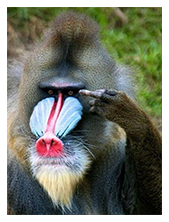

PSNR = inf dB
MSE = 0.00
Elapsed: 0.09 seconds
****************
****************
nearest_neighbour


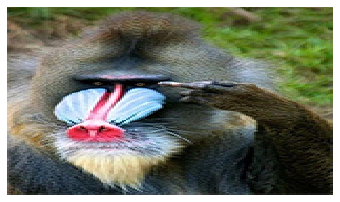

Elapsed: 6.21 seconds
****************
****************
bilinear


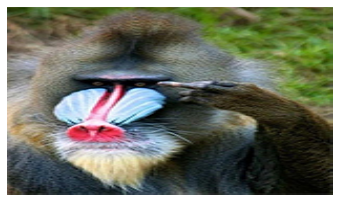

Elapsed: 8.59 seconds
****************
****************
gaussian 0.3


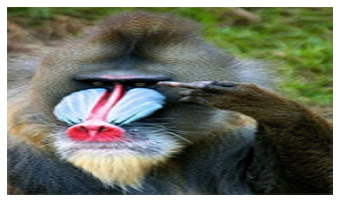

Elapsed: 269.26 seconds
****************


In [304]:
sy, sx = 0.9, 2.1
    
run(mandrill)

old_height, old_width = mandrill.height, mandrill.width
# print(f"{old_height}x{old_width}")
backward_map = calculate_all_backward_scale_mapping(old_height, old_width, sy, sx)

run(mandrill, nearest_neighbour, backward_map)
run(mandrill, bilinear, backward_map)
run(mandrill, gaussian03, backward_map)

## Part 3: Rotation Transformation

Implement a simple forward scale mapping. Given **x** and **y**, translate them (use the **height center** and **width center** as the origin) and rotate them using the **cosine of t** and the **sine of t**.

In [305]:
def forward_rotation_mapping(old_y: float, old_x: float, height_center: float, width_center: float, cost: float, sint: float) -> (float, float):
    new_x = cost * (old_x - width_center) - sint * (old_y - height_center) + width_center;
    new_y = sint * (old_x - width_center) + cost * (old_y - height_center) + height_center;
    return new_y, new_x

Now implement a backward mapping operator. Given everything, where did each pixel translated from? The result may be a "fractional" pixel.

You can implement this function by a single call to *forward_rotation_mapping*, think how. Partial points will be given to students who do not call *forward_scale_mapping*.

In [306]:
def backward_rotation_mapping(new_y: float, new_x: float, height_center: float, width_center: float, cost: float, sint: float) -> (float, float):
    return forward_rotation_mapping(new_y, new_x, height_center, width_center,  cost, -1*sint)

We will now test your code for sanity.

In [307]:
class RotationTest(TestCase):
    def test(self):
        height, width = randint(1, 768), randint(1, 1024)
        y, x = randint(0, height - 1), randint(0, width - 1)
        t = uniform(0, 360)

        cost, sint = cos(t), sin(t)

        height_center = (height - 1) / 2
        width_center = (width - 1) / 2

        new_y, new_x = forward_rotation_mapping(y, x, height_center, width_center, cost, sint)
        old_new_y, old_new_x = backward_rotation_mapping(new_y, new_x, height_center, width_center, cost, sint)
        self.assertAlmostEqual(y, old_new_y, msg="Diff in y")
        self.assertAlmostEqual(x, old_new_x, msg="Diff in x")

RotationTest().test()

Now let's create a full backward mapping dictionary. Given a source image's dimensions, you need to calculate the target image's dimensions, and then for every target pixel **(new_x, new_y)**, store the source pixel **(old_x, old_y)** in the dictionary.

In [308]:
def calculate_all_backward_rotation_mapping(height: int, width: int, t: float) -> dict:
    """

    :rtype: dict
    :param height: Height of the image in pixels
    :param width: Width of the image in pixels
    :param t: Forward rotation angle in degrees (in relation to the center of the image)
    :return: A mapping from forward integer pixels (y, x) to the backward fractional pixels (old_y, old_x)
    """
    backward_map = {}
    for y in range(0, height):
        for x in range(0, width):
            cost, sint = cos(t), sin(t)
            backward_map[(y, x)] = backward_rotation_mapping(y, x, height//2, width//2, cost, sint)
    
    return backward_map

Let's begin rotating the mandrill 10 times, 36° each, with our sampling methods. We expect to see unwanted artifacts near the edges, because the image is not padded.

****************


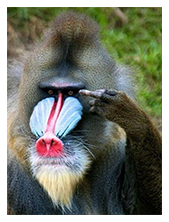

PSNR = inf dB
MSE = 0.00
Elapsed: 0.15 seconds
****************
****************
nearest_neighbour


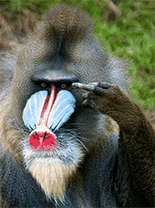

PSNR = 8.62 dB
MSE = 8942.67
Elapsed: 32.78 seconds
****************
****************
bilinear


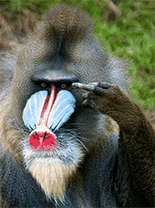

PSNR = 8.87 dB
MSE = 8433.26
Elapsed: 46.70 seconds
****************
****************
gaussian 0.3


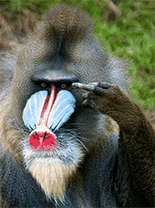

PSNR = 8.87 dB
MSE = 8429.65
Elapsed: 160.89 seconds
****************


In [309]:
t = 36
assert 360 % t == 0
iters = 360 // t    

run(mandrill)

backward_map = calculate_all_backward_rotation_mapping(mandrill.height, mandrill.width, t)

run(mandrill, nearest_neighbour, backward_map, num_iters=iters, gif=True)
run(mandrill, bilinear, backward_map, num_iters=iters, gif=True)
run(mandrill, gaussian03, backward_map, num_iters=iters, gif=True)

Implement the ***pad*** function. It should take an image and return a larger image, having the original image in the center and white pixels around it, such that no pixels will be lost during a rotation operation.
<ol>
    <li>Hint: Where would a corner pixel translate under a 45 degrees rotation? Think of a square source image for example.</li>
    <li>Hint: Should the target image be square? Is there symmetry in the probem?</li>
</ol>
Partial points will be given for a larger padding than needed.

In [333]:
def pad(image: MyImage) -> MyImage:
    """
    by rotating the rectengular image we create a circle with the radius length of the furthest away point from the center of the image which are the corners.
    since circle is not supported by ndarray we will use a square.
    """ 
    
    dim_y, dim_x = image.height, image.width
    center_y, center_x = dim_y//2, dim_x//2
    radious = ceil(sqrt(pow(dim_y - center_y, 2) + pow(dim_x - center_x, 2)))
    padded_dim = 2*radious
    print(f"radious is: {radious}")
    new_tensor  = ndarray(shape=(padded_dim, padded_dim, 3), dtype=uint8)
    shift_y = (padded_dim - dim_y)//2
    shift_x = (padded_dim - dim_x)//2
    print(f"original size: {dim_y}x{dim_x}, padded_size: {padded_dim}x{padded_dim} shift_y = {shift_y}, shift_x = {shift_x}")
    for y in range(padded_dim):
        for x in range(padded_dim):
            new_tensor[(y,x)] = [255, 255, 255] 
    for y in range(image.height):
        for x in range(image.width):
            new_tensor[(shift_y+y,shift_x + x)] = image.tensor[(y, x)] 
             
    return MyImage(new_tensor)

radious is: 130
original size: 208x155, padded_size: 260x260 shift_y = 26, shift_x = 52
****************


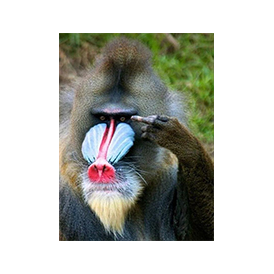

PSNR = inf dB
MSE = 0.00
Elapsed: 0.09 seconds
****************
****************
nearest_neighbour


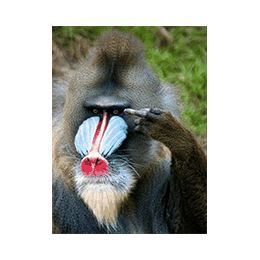

PSNR = 7.68 dB
MSE = 11089.56
Elapsed: 36.15 seconds
****************
****************
bilinear


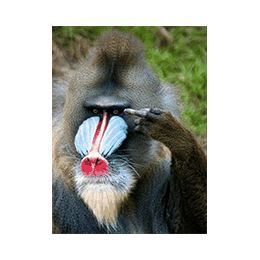

PSNR = 7.82 dB
MSE = 10736.37
Elapsed: 41.53 seconds
****************
****************
gaussian 0.3


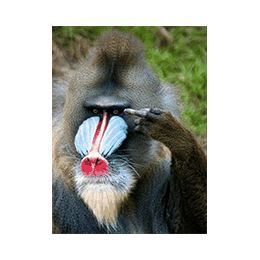

PSNR = 7.84 dB
MSE = 10688.69
Elapsed: 235.85 seconds
****************


In [334]:
padded_mandrill = pad(mandrill)

run(padded_mandrill)

backward_map = calculate_all_backward_rotation_mapping(padded_mandrill.height, padded_mandrill.width, t)

run(padded_mandrill, nearest_neighbour, backward_map, num_iters=iters, gif=True)
run(padded_mandrill, bilinear, backward_map, num_iters=iters, gif=True)
run(padded_mandrill, gaussian03, backward_map, num_iters=iters, gif=True)

**Bonus**: load an image of your choice and define your own Gaussian, such that for 10 rotations, the PSNR is higher and the MSE is lower in comparison to bilinear. Attach the image to your submission.

Partial points will be given for unsuccessful attempts.

In [21]:
# The Gaussian's standard deviation
my_std = 1.0
# The distance of the regular grid's sampling
my_d = 1.0
# The epsilon to add to the sampling result
my_epsilon = 1.0

my_gaussian = partial(parametric_gaussian, std=my_std, d=my_d, epsilon=my_epsilon)
my_gaussian.__name__ = 'my gaussian'

my_image = PILImage.open("my_image.jpg").convert("RGB")
my_image = MyImage(array(my_image))
my_image = pad(my_image)

run(my_image)

backward_map = calculate_all_backward_rotation_mapping(my_image.height, my_image.width, t)

run(my_image, bilinear, backward_map, num_iters=iters, gif=True)
run(my_image, my_gaussian, backward_map, num_iters=iters, gif=True)

FileNotFoundError: [Errno 2] No such file or directory: 'path/to/your/image.jpg'